In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.animation import ArtistAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from IPython import display
import numpy as np
import seaborn as sns
import colorsys
from collections import defaultdict
import os
from scipy import stats as sstats
import scipy.special as scipy_special

import torch
from einops import reduce, rearrange, asnumpy, repeat

from irwg.models import VAE
from irwg.data.toy import plot_data_pairwise, ToyDataset, ToyCustomTestDataset
from irwg.data.missing_data_module import MissingDataModule, MISSINGNESS, DATASET
from irwg.utils.stats import load_stats
from irwg.utils.mog_utils import sample_sparse_mog

from irwg.utils.vae_marginal_logprob import get_marginal_logprob, get_latent_post_mean
from irwg.utils.mog_utils import compute_conditional_mog_parameters_nonbatched

In [2]:
mpl.rc('font',**{'family':'serif'})
mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble']=r"\usepackage{amsmath} \usepackage{amsfonts}"

plt.style.use('seaborn-colorblind')

In [3]:
def neon_plot(x, y, ax=None, *, label, color, zorder=5, alpha=0.05):
    if ax is None:
        ax = plt.gca()
    line, = ax.plot(x, y, lw=1, zorder=zorder+1)
    for cont in range(6, 1, -1):
        ax.plot(x, y, lw=cont, color=color, zorder=zorder,
                alpha=alpha, label=label)
    return ax

class HandlerColormap(mpl.legend_handler.HandlerBase):
    def __init__(self, cmap, num_stripes=8, rasterized=False, **kw):
        mpl.legend_handler.HandlerBase.__init__(self, **kw)
        self.cmap = cmap
        self.num_stripes = num_stripes
        self.rasterized = rasterized
    def create_artists(self, legend, orig_handle, 
                       xdescent, ydescent, width, height, fontsize, trans):
        stripes = []
        for i in range(self.num_stripes):
            s = mpl.patches.Rectangle([xdescent + i * width / self.num_stripes, ydescent], 
                                      width / self.num_stripes, 
                                      height, 
                                      fc=self.cmap((2 * i + 1) / (2 * self.num_stripes)), 
                                      transform=trans,
                                     rasterized=self.rasterized)
            stripes.append(s)
        return stripes

In [4]:
def create_grid(min_v, max_v, bins=100):
    """Creates the grid for visualising 2D marginal densities"""
    x0, x1 = np.mgrid[min_v:max_v*1.01:(max_v-min_v)/bins, 
                      min_v:max_v*1.01:(max_v-min_v)/bins]
    pos = np.empty(x0.shape + (2,))
    pos[:, :, 0] = x0
    pos[:, :, 1] = x1
    return x0, x1, torch.tensor(pos).float()

def create_mv_mog(comp_logits, means, *, covs=None, scale_trils=None):
    mix = torch.distributions.Categorical(logits=comp_logits)
    multi_norms = torch.distributions.MultivariateNormal(
        loc=means, covariance_matrix=covs, scale_tril=scale_trils)
    comp = torch.distributions.Independent(multi_norms, 0)
    mog = torch.distributions.MixtureSameFamily(mix, comp)

    return mog

def create_univariate_mog(comp_logits, means, variances):
    mix = torch.distributions.Categorical(logits=comp_logits)
    norms = torch.distributions.Normal(
        loc=means, scale=variances**0.5)
    mog = torch.distributions.MixtureSameFamily(mix, norms)
    return mog
    

def marginal_log_prob_mog(X, params, dims):
    """Marginal log-probability of the chosen dimensions evaluated at X"""
    comp_logits = params['comp_logits']
    means = params['means'][:, dims]
    covs = params['covs'][:, dims, :][:, :, dims]
    
    mog = create_mv_mog(comp_logits, means, covs=covs)
    
    return mog.log_prob(X)

def univariate_log_prob_mog(X, params, dim):
    comp_logits = params['comp_logits']
    means = params['means'][:, dim]
    var = params['covs'][:, :, dim][:, dim]
    
    mog = create_univariate_mog(comp_logits, means, var)
    
    return mog.log_prob(X)

def plot_pairwise_marginal_contourfs(fig, grid_spec, dims, limits, *, ax=None, mog_params=None,
                                     vae=None, levels=10, vae_integration_kwargs={},
                                     bins=100, data=None, log_domain=False, 
                                     rasterize_contours=False, scatter_color='b', 
                                     hide_ticks=True):
    """Used for plotting pairwise 2D marginals as filled contour plots"""
    min_v, max_v = limits
    
    if ax is not None:
        assert dims == 2
    
    artists = []
    for i in range(0, dims):
        for j in range(i+1, dims):
            # Plot pairs of dimensions
            if ax is None:
                ax = fig.add_subplot(grid_spec[i, j-1])
            artists.append(ax)

            x0, x1, pos = create_grid(min_v, max_v, bins=bins)

            assert not (vae is not None and mog_params is not None)
            if mog_params is not None:
                log_pdf = marginal_log_prob_mog(pos, mog_params, dims=[i, j])
            elif vae is not None:
                d1, d2 = pos.shape[0], pos.shape[1]
                pos = rearrange(pos, 'd1 d2 d -> (d1 d2) d')
                M = torch.ones_like(pos)
                with torch.inference_mode():
                    log_pdf = get_marginal_logprob(vae, (pos, M), **vae_integration_kwargs)
                    log_pdf = rearrange(log_pdf, '(d1 d2) -> d1 d2', d1=d1, d2=d2)
#                 pos = rearrange(pos, '(d1 d2) d -> d1 d2 d', d1=d1, d2=d2)
            else:
                raise NotImplementedError()
            pdf = torch.exp(log_pdf)

            contour = ax.contourf(x1, x0, log_pdf if log_domain else pdf, levels=levels)
            
            if rasterize_contours:
                for c in contour.collections:
                    c.set_rasterized(True)
            
            if data is not None:
                ax.scatter(data[:, j], data[:, i], alpha=0.4, marker='.', color=scatter_color)

            if hide_ticks:
                ax.tick_params(left=False, labelleft=False,
                               bottom=False, labelbottom=False)

            # Set common limits
            ax.set_ylim(min_v, max_v)
            ax.set_xlim(min_v, max_v)

            if i == 0:
                ax.set_title(f'dim={j}', fontsize=12)
            if j == 1:
                ax.set_ylabel(f'dim={i}', fontsize=12)

        # Create dummy axes to add labels on the left-hand side
        if 0 < i < (dims-1):
            ax = fig.add_subplot(dims-1, dims-1, i*(dims-1)+1)
            artists.append(ax)
            ax.set_ylabel(f'dim={i}', fontsize=12)
            # Hide the dummy axes
            ax.xaxis.set_visible(False)
            plt.setp(ax.spines.values(), visible=False)
            ax.tick_params(left=False, labelleft=False)
            ax.patch.set_visible(False)

    if grid_spec is not None:
        grid_spec.tight_layout(fig)
    
    return artists

In [5]:
def mog_compute_conditional_logpdf(x, X_true, M, params):
    miss_idx = np.where(~M)[0][0]
    
    mog_cond_comp_logprob, mog_cond_means, mog_cond_covs = compute_conditional_mog_parameters_nonbatched(
                torch.tensor(X_true), torch.tensor(M), 
                torch.tensor(params['comp_logits']), 
                torch.tensor(params['means']), 
                torch.tensor(params['covs']))

    cond_params = {'comp_logits': mog_cond_comp_logprob,
               'means': mog_cond_means,
               'covs': mog_cond_covs}

    mog_logprob = univariate_log_prob_mog(torch.tensor(x), cond_params, miss_idx)
    
    return mog_logprob

def vae_compute_conditional_logpdf(x, dx, X_true, M, vae, params, vae_integration_kwargs):
    obs_idx = np.where(M)[0][0]
    miss_idx = np.where(~M)[0][0]
    
    with torch.inference_mode():
        pos = torch.empty(x.shape[0], 2)
        pos[:, miss_idx] = torch.tensor(x)
        pos[:, obs_idx] = torch.tensor(X_true[obs_idx])
        mask = torch.ones_like(pos)
        joint_log_pdf = get_marginal_logprob(vae, (pos, mask), **vae_integration_kwargs)
        vae_log_pxo = torch.logsumexp(joint_log_pdf + torch.log(torch.tensor(dx)), dim=0)
        vae_log_pdf = joint_log_pdf - vae_log_pxo
        
    return vae_log_pdf

def vae_encoder_latent_posterior_expected_value(pos, vae, *, temperature=None):
    if isinstance(pos, np.ndarray):
        pos = torch.tensor(pos)
        
    with torch.inference_mode():
        latent_params = vae.var_latent_network(pos)
        if temperature is not None:
            latent_params = vae.distribution_param_tempering(latent_params,
                                                               vae.hparams.var_latent_distribution,
                                                               temperature=temperature)
        latent_distr = vae.create_distribution(latent_params, vae.hparams.var_latent_distribution)
    exp_vals = latent_distr.mean.sum(-1)
    
    return exp_vals

def vae_encoder_latent_posterior_expected_value_1d(x, X_true, M, vae, *, temperature=None):
    obs_idx = np.where(M)[0][0]
    miss_idx = np.where(~M)[0][0]
    if isinstance(x, np.ndarray):
        x = torch.tensor(x)
        
    with torch.inference_mode():
        pos = torch.empty(x.shape[0], 2)
        pos[:, miss_idx] = x
        pos[:, obs_idx] = torch.tensor(X_true[obs_idx])
        
        exp_vals = vae_encoder_latent_posterior_expected_value(pos, vae, temperature=temperature)
    
    return exp_vals

def vae_encoder_latent_posterior_logpdf_1d(x, M, X_true, vae, vae_integration_kwargs, *, temperature=None):
    obs_idx = np.where(M)[0][0]
    miss_idx = np.where(~M)[0][0]
    if isinstance(x, np.ndarray):
        x = torch.tensor(x)
        
    with torch.inference_mode():
        pos = torch.empty(x.shape[0], 2)
        pos[:, miss_idx] = x
        pos[:, obs_idx] = torch.tensor(X_true[obs_idx])
    
        latent_params = vae.var_latent_network(pos)
        if temperature is not None:
            latent_params = vae.distribution_param_tempering(latent_params,
                                                               vae.hparams.var_latent_distribution,
                                                               temperature=temperature)
        latent_distr = vae.create_distribution(latent_params, vae.hparams.var_latent_distribution)
        
        Z = torch.linspace(vae_integration_kwargs['latent_min'], 
                           vae_integration_kwargs['latent_max'], 
                           vae_integration_kwargs['latent_bins'])
        
        log_prob = latent_distr.log_prob(Z)
        
    return log_prob

In [6]:
def plot_2d_vae_var_latent_expected_values(fig, vae, limits, *, ax=None, bins=100, hide_ticks=False, add_colorbar=False, c_ax=None):
    """For a 2d observed space plot the encoded latent expected values"""
    min_v, max_v = limits
    
    artists = []
    if ax is None:
        ax = fig.add_subplot()
    artists.append(ax)
    
    x0, x1, pos = create_grid(min_v, max_v, bins=bins)
    
    d1, d2 = pos.shape[0], pos.shape[1]
    pos = rearrange(pos, 'd1 d2 d -> (d1 d2) d')
    exp_vals = vae_encoder_latent_posterior_expected_value(pos, vae)
#     with torch.inference_mode():
#         latent_params = vae.var_latent_network(pos)
#         latent_distr = vae.create_distribution(latent_params, vae.hparams.var_latent_distribution)
#     exp_vals = latent_distr.mean.sum(-1)
    exp_vals = rearrange(exp_vals, '(d1 d2) -> d1 d2', d1=d1, d2=d2)
    
    im = ax.imshow(exp_vals, extent=(min_v, max_v, min_v, max_v), origin='lower')
#     contour = ax.contourf(x1, x0, exp_vals, levels=40)
    
    if add_colorbar:
#         cb = fig.colorbar(im, ax=ax,  anchor=(0, 0.3), location='right')
#         artists.append(cb)
#         divider = make_axes_locatable(ax)
#         cax = divider.append_axes('right', size='0%', pad=0.00)
        fig.colorbar(im, cax=c_ax, orientation='vertical')
        artists.append(c_ax)
    
    if hide_ticks:
        ax.tick_params(left=False, labelleft=False,
                       bottom=False, labelbottom=False,
                       top=False, labeltop=False)
    
    ax.set_title(f'dim={1}', fontsize=12)
    ax.set_ylabel(f'dim={0}', fontsize=12)
    
    fig.tight_layout()
    
    return artists

In [7]:
def plot_2d_vae_latent_post_expected_values(fig, vae, limits, *, ax=None, bins=100, vae_integration_kwargs={}, hide_ticks=False,
                                           add_colorbar=False, c_ax=None):
    """For a 2d observed space plot the true latent expected values"""
    min_v, max_v = limits
    
    artists = []
    if ax is None:
        ax = fig.add_subplot()
    artists.append(ax)
    
    x0, x1, pos = create_grid(min_v, max_v, bins=bins)
    
    d1, d2 = pos.shape[0], pos.shape[1]
    pos = rearrange(pos, 'd1 d2 d -> (d1 d2) d')
    M = torch.ones_like(pos)
    with torch.inference_mode():
        post_mean, _, _ = get_latent_post_mean(vae, (pos, M), **vae_integration_kwargs)
    post_mean = post_mean.sum(-1)
    post_mean = rearrange(post_mean, '(d1 d2) -> d1 d2', d1=d1, d2=d2)
    
    im = ax.imshow(post_mean, extent=(min_v, max_v, min_v, max_v), origin='lower')
    
    if add_colorbar:
#         cb = fig.colorbar(im, ax=ax,  anchor=(0, 0.3), location='right')
#         artists.append(cb)
#         divider = make_axes_locatable(ax)
#         cax = divider.append_axes('right', size='0%', pad=0.00)
        fig.colorbar(im, cax=c_ax, orientation='vertical')
        artists.append(c_ax)
    
    if hide_ticks:
        ax.tick_params(left=False, labelleft=False,
                       bottom=False, labelbottom=False,
                       top=False, labeltop=False)
    
    ax.set_title(f'dim={1}', fontsize=12)
    ax.set_ylabel(f'dim={0}', fontsize=12)
    
    fig.tight_layout()
    
    return artists

def vae_true_latent_posterior_logpdf_1d(x, X_true, M, vae, vae_integration_kwargs):
    obs_idx = np.where(M)[0][0]
    miss_idx = np.where(~M)[0][0]
    if isinstance(x, np.ndarray):
        x = torch.tensor(x)
        
    with torch.inference_mode():
        pos = torch.empty(x.shape[0], 2)
        pos[:, miss_idx] = x
        pos[:, obs_idx] = torch.tensor(X_true[obs_idx])
        M = torch.ones_like(pos)
    
        with torch.inference_mode():
            cond_mean, cond_logprob, Z = get_latent_post_mean(vae, (pos, M), **vae_integration_kwargs)
            cond_logprob = rearrange(cond_logprob, 'z d -> d z')

    return cond_logprob


def vae_true_latent_posterior_expected_value_1d(x, X_true, M, vae, vae_integration_kwargs):
    obs_idx = np.where(M)[0][0]
    miss_idx = np.where(~M)[0][0]
    if isinstance(x, np.ndarray):
        x = torch.tensor(x)
        
    with torch.inference_mode():
        pos = torch.empty(x.shape[0], 2)
        pos[:, miss_idx] = x
        pos[:, obs_idx] = torch.tensor(X_true[obs_idx])
        M = torch.ones_like(pos)
    
        with torch.inference_mode():
            cond_mean, cond_logprob, Z = get_latent_post_mean(vae, (pos, M), **vae_integration_kwargs)
            cond_logprob = rearrange(cond_logprob, 'z d -> d z')

    return cond_mean

In [8]:
def compute_divergences_between_logpds_arrays(logpdf1, logpdf2, dx):
    logpdf1 = logpdf1.astype(np.double)
    logpdf2 = logpdf2.astype(np.double)
    dx = np.array(dx, dtype=np.double)
    
    diff = logpdf1 - logpdf2
    
    pdf1 = np.exp(logpdf1)
    kl_fow = np.sum(pdf1*diff*dx)
    
    pdf2 = np.exp(logpdf2)
    kl_rev = np.sum(pdf2*(-diff)*dx)
    
    logpdfm = scipy_special.logsumexp(rearrange([logpdf1, logpdf2], 'p x -> p x', p=2), axis=0) - np.log(2)
    
    jsd = 0.5*(np.sum(pdf1*(logpdf1 - logpdfm)*dx) + np.sum(pdf2*(logpdf2 - logpdfm)*dx))
    
    return kl_fow, kl_rev, jsd

In [82]:
def load_imputations_from_experiment(path, expand_dims=False):
    versions = os.listdir(path)
    if len(versions) > 1:
        versions = list(sorted([int(v.split('version_')[1]) for v in versions]))
        v = versions[-1]
        v = f'version_{v}'
        print(f'Multiple versions found in {path}, loading {v}.')
    else:
        v = versions[0]
        
    path = os.path.join(path, v)
    
    imp_files = [f for f in os.listdir(path) if f.startswith('imputations_') and f.endswith('.npz')]
    batch_idxs = [int(f.split('imputations_')[1].split('.npz')[0]) for f in imp_files]
    imp_files = [f for _, f in sorted(zip(batch_idxs, imp_files))]
    data = defaultdict(list)
    for f in imp_files:
        f = np.load(os.path.join(path, f))
        keys = list(f.keys())
        for k in keys:
            if k == 'imputations':
                data[k].append(f[k])
            elif (k =='masks' or k=='true_X') and expand_dims:
                data[k].append(np.expand_dims(f[k], -2))
            else:
                data[k].append(f[k])
    
    for k in list(data.keys()):
        if k == 'imputations':
            data[k] = np.concatenate(data[k], axis=1)
            data[k] = rearrange(data[k], 't b k ... -> b k t ...')
        elif k == 'latents':
            data[k] = np.concatenate(data[k], axis=1)
            data[k] = rearrange(data[k], 't b k ... -> b k t ...')
        else:
            data[k] = np.concatenate(data[k], axis=0)

    return data

def load_imputations_from_experiment_after_final_irwg_resampling(path):
    versions = os.listdir(path)
    if len(versions) > 1:
        versions = list(sorted([int(v.split('version_')[1]) for v in versions]))
        v = versions[-1]
        v = f'version_{v}'
        print(f'Multiple versions found in {path}, loading {v}.')
    else:
        v = versions[0]
        
    path = os.path.join(path, v)
    
    imp_files = [f for f in os.listdir(path) if f.startswith('irwg_imputations_after_final_resampling_') and f.endswith('.npz')]
    batch_idxs = [int(f.split('irwg_imputations_after_final_resampling_')[1].split('.npz')[0]) for f in imp_files]
    imp_files = [f for _, f in sorted(zip(batch_idxs, imp_files))]
    data = defaultdict(list)
    for f in imp_files:
        f = np.load(os.path.join(path, f))
        keys = list(f.keys())
        for k in keys:
            if k == 'imputations':
                data[k].append(f[k])
#             elif (k =='masks' or k=='true_X') and expand_dims:
#                 data[k].append(np.expand_dims(f[k], -2))
            else:
                data[k].append(f[k])
    
    for k in list(data.keys()):
        if k == 'imputations':
            data[k] = np.concatenate(data[k], axis=1)
            data[k] = rearrange(data[k], 't b k ... -> b k t ...')
        elif k == 'latents':
            data[k] = np.concatenate(data[k], axis=1)
            data[k] = rearrange(data[k], 't b k ... -> b k t ...')
        else:
            data[k] = np.concatenate(data[k], axis=0)
            
    return data

In [10]:
dataset = 'toy_grid2dmog4'

## MoG data contours 

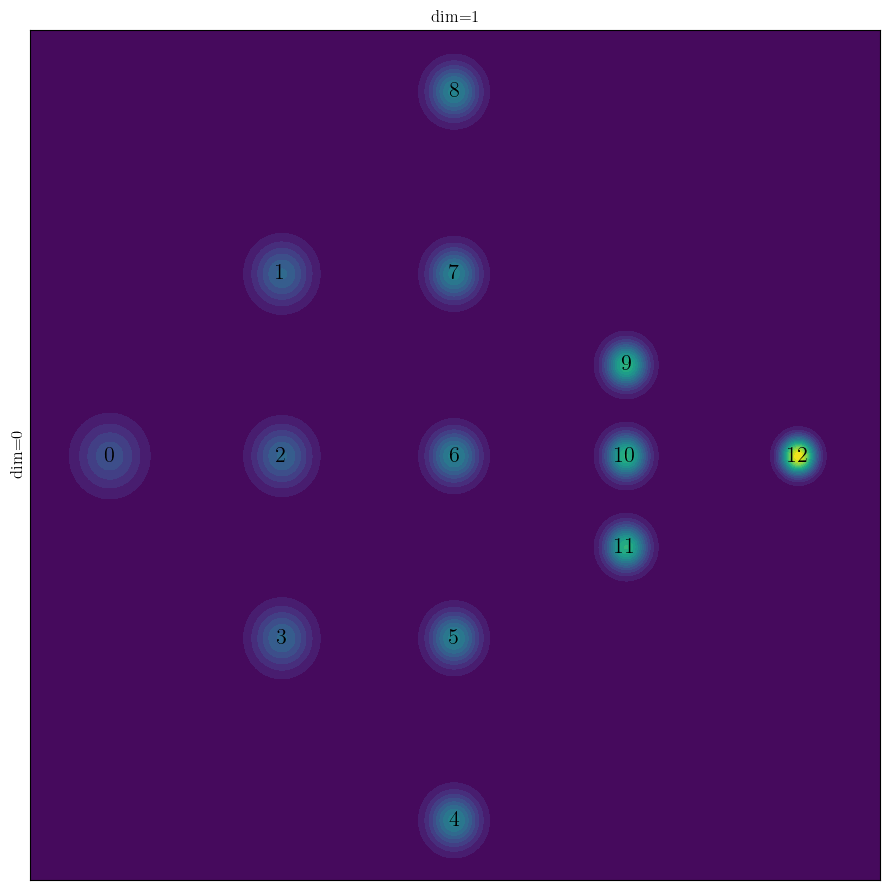

In [13]:
data = ToyDataset(root='../data', filename='data_grid2dmog4', split = 'train')
dims = data[:].shape[-1]

fig = plt.figure(figsize=(9,9))
gs = gridspec.GridSpec(ncols=dims-1, nrows=dims-1, figure=fig)

max_v = data[:].max()
min_v = data[:].min()

params = {
    'comp_logits': torch.tensor(np.log(data.data_file['comp_probs'])),
    'covs': torch.tensor(data.data_file['covs']),
    'means': torch.tensor(data.data_file['means'])
}

artists = plot_pairwise_marginal_contourfs(fig, gs, dims, (min_v, max_v), 
                                           mog_params=params, 
                                           rasterize_contours=True,
                                           bins=2000, 
#                                            data=data[:20]
                                           levels=20,
                                                  )

for i in range(len(params['means'])):
    mean_i = asnumpy(params['means'][i])
    artists[0].text(mean_i[1], mean_i[0], f'{i}', va='center', ha='center', fontsize=16)

# fig.savefig('figures/grid2dmog4.pdf')

## VAE inspection 

### Pretrained (supervised)

In [14]:
vae_path = (f'../logs/{dataset}/imputation/vae_comptrain/seed_m20220118_d20220118/lightning_logs/'
            'version_0/checkpoints/last.ckpt')
vae = VAE.load_from_checkpoint(vae_path)
vae = vae.eval()

num_datapoints = 3000
vae_samples = vae.sample(num_datapoints)


dims = data[:].shape[-1]

max_v = data[:].max()
min_v = data[:].min()

params = {
    'comp_logits': torch.tensor(np.log(data.data_file['comp_probs'])),
    'covs': torch.tensor(data.data_file['covs']),
    'means': torch.tensor(data.data_file['means'])
}


frames = []

fig = plt.figure(figsize=(9,9))
gs = gridspec.GridSpec(ncols=dims-1, nrows=dims-1, figure=fig)

artists = plot_pairwise_marginal_contourfs(fig, gs, dims, (min_v, max_v), 
                                           mog_params=params, 
                                           rasterize_contours=True,
                                           bins=100, 
#                                            data=data[:num_datapoints]
                                           levels=20,
                                           hide_ticks=False,
                                                  )
for i in range(len(params['means'])):
    mean_i = asnumpy(params['means'][i])
    artists[0].text(mean_i[1], mean_i[0], f'{i}', va='center', ha='center', fontsize=16)

frames.append(artists)

# artists = plot_pairwise_marginal_contourfs(fig, gs, dims, (min_v, max_v), 
#                                            mog_params=params, 
#                                            rasterize_contours=True,
#                                            bins=100, 
#                                            data=data[:num_datapoints],
#                                            scatter_color='m',
#                                            levels=20,
#                                            hide_ticks=False,
#                                            )

# for i in range(len(params['means'])):
#     mean_i = asnumpy(params['means'][i])
#     artists[0].text(mean_i[1], mean_i[0], f'{i}', va='center', ha='center', fontsize=16)

# frames.append(artists)

# artists = plot_pairwise_marginal_contourfs(fig, gs, dims, (min_v, max_v), 
#                                            mog_params=params, 
#                                            rasterize_contours=True,
#                                            bins=100, 
#                                            data=vae_samples,
#                                            scatter_color='r',
#                                            levels=20,
#                                            hide_ticks=False,
#                                            )

# for i in range(len(params['means'])):
#     mean_i = asnumpy(params['means'][i])
#     artists[0].text(mean_i[1], mean_i[0], f'{i}', va='center', ha='center', fontsize=16)

# frames.append(artists)

artists = plot_pairwise_marginal_contourfs(fig, gs, dims, (min_v, max_v), 
#                                            mog_params=params, 
                                           vae=vae,
                                           vae_integration_kwargs={'latent_min':0., 
                                                                   'latent_max':1.+1e-8, 
                                                                   'latent_bins': 100},
                                           rasterize_contours=True,
                                           bins=100, 
                                           levels=20,
                                           hide_ticks=False,
                                           )
for i in range(len(params['means'])):
    mean_i = asnumpy(params['means'][i])
    artists[0].text(mean_i[1], mean_i[0], f'{i}', va='center', ha='center', fontsize=16)

frames.append(artists)

artists = plot_2d_vae_var_latent_expected_values(fig, vae=vae, limits=(min_v, max_v), 
                                           bins=100, 
                                           hide_ticks=False,
                                           )
for i in range(len(params['means'])):
    mean_i = asnumpy(params['means'][i])
    artists[0].text(mean_i[1], mean_i[0], f'{i}', va='center', ha='center', fontsize=16)

frames.append(artists)

artists = plot_2d_vae_latent_post_expected_values(fig, vae=vae, limits=(min_v, max_v), 
                                                  bins=100, 
                                                  vae_integration_kwargs={'latent_min':0., 
                                                                   'latent_max':1.+1e-8, 
                                                                   'latent_bins': 100},
                                                  hide_ticks=False,
                                                  )

for i in range(len(params['means'])):
    mean_i = asnumpy(params['means'][i])
    artists[0].text(mean_i[1], mean_i[0], f'{i}', va='center', ha='center', fontsize=16)

frames.append(artists)


plt.close(fig)

anim = ArtistAnimation(fig, frames)
video = anim.to_jshtml()
# Alternative, but low-resolution
# video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)

/home/vaidas/miniconda3/envs/irwg/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'generator_network' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['generator_network'])`.
  rank_zero_warn(
/home/vaidas/miniconda3/envs/irwg/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'var_latent_network' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['var_latent_network'])`.
  rank_zero_warn(
/tmp/ipykernel_3408463/1868704828.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_3408463/2431994216.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be inco

#### Paper Figure 

/tmp/ipykernel_116430/2431994216.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_116430/3397196256.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos[:, obs_idx] = torch.tensor(X_true[obs_idx])
/tmp/ipykernel_116430/2431994216.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos[:, obs_idx] = torch.tensor(X_true[obs_idx])


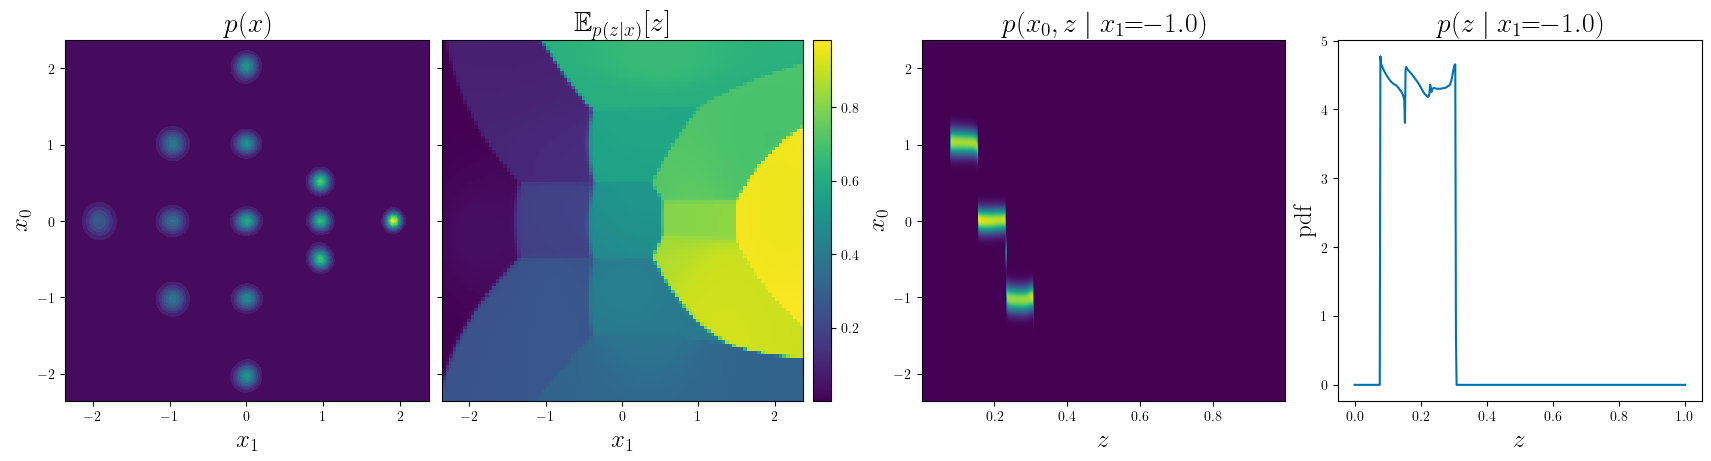

In [197]:
## Figure

vae_path = (f'../logs/{dataset}/imputation/vae_comptrain/seed_m20220118_d20220118/lightning_logs/'
            'version_0/checkpoints/last.ckpt')
vae = VAE.load_from_checkpoint(vae_path)
vae = vae.eval()

dims = data[:].shape[-1]

max_v = data[:].max()
min_v = data[:].min()

params = {
    'comp_logits': torch.tensor(np.log(data.data_file['comp_probs'])),
    'covs': torch.tensor(data.data_file['covs']),
    'means': torch.tensor(data.data_file['means'])
}

fig = plt.figure(figsize=(17,4.5), constrained_layout=True)
gs = gridspec.GridSpec(ncols=5, nrows=1, figure=fig, 
                       width_ratios=[20,20,1, 20, 20],
                       top=0.9
                      )

ax = fig.add_subplot(gs[0, 0])

artists1 = plot_pairwise_marginal_contourfs(fig, None, dims, (min_v, max_v), ax=ax,
#                                            mog_params=params, 
                                           vae=vae,
                                           vae_integration_kwargs={'latent_min':0., 
                                                                   'latent_max':1.+1e-8, 
                                                                   'latent_bins': 100},
                                           rasterize_contours=True,
                                           bins=100, 
                                           levels=20,
                                           hide_ticks=False,
                                           )

ax = fig.add_subplot(gs[0, 1])
cax = fig.add_subplot(gs[0, 2])

# artists = plot_2d_vae_var_latent_expected_values(fig, vae=vae, ax=ax, limits=(min_v, max_v), 
#                                            bins=100, 
#                                            hide_ticks=False,
#                                                  add_colorbar=True,
#                                                    c_ax=cax
#                                            )


artists2 = plot_2d_vae_latent_post_expected_values(fig, vae=vae, ax=ax, limits=(min_v, max_v), 
                                                  bins=100, 
                                                  vae_integration_kwargs={'latent_min':0., 
                                                                   'latent_max':1.+1e-8, 
                                                                   'latent_bins': 100},
                                                  hide_ticks=False,
                                                   add_colorbar=True,
                                                   c_ax=cax
                                                  )

ax = fig.add_subplot(gs[0, 3])

limits = (min_v, max_v)
bins = 5000

vae_integration_kwargs={'latent_min':0., 
                        'latent_max':1.+1e-8, 
                        'latent_bins': 500}
X_true = torch.tensor([float('nan'), -1.])
M = torch.tensor([0, 1], dtype=torch.bool)

x = np.linspace(limits[0], limits[1], bins, dtype=np.float32)
dx = (limits[1] - limits[0]) / bins

vae_logpdf = vae_compute_conditional_logpdf(x, dx, X_true, M, vae, params, vae_integration_kwargs)
vae_logpdf = asnumpy(vae_logpdf)
vae_pdf = np.exp(vae_logpdf)
# ax.plot(x, vae_pdf ,linewidth=5., label='True VAE')

vae_latent_pdf_kwargs={'latent_min':0.+1e-6, 
                        'latent_max':1.-1e-6, 
                        'latent_bins': 500}
latent_x_bins = 5000
latent_x = np.linspace(limits[0], limits[1], latent_x_bins, dtype=np.float32)

pz_logpdf = vae_true_latent_posterior_logpdf_1d(latent_x, X_true, M, vae, vae_latent_pdf_kwargs)
pz_logpdf = rearrange(asnumpy(pz_logpdf), 'd z -> z d')
pz_pdf = np.exp(pz_logpdf)

pzp_logpdf = pz_logpdf + vae_logpdf[None, :]
pzp_pdf = np.exp(pzp_logpdf)

im = ax.imshow(pzp_pdf.T, 
                    extent=(vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max'],
                           limits[0], limits[1],), 
                    origin='lower', aspect='auto')
# ax.set_title('$z$', fontsize=20)
obs_value = X_true[torch.where(M)].item()
ax.set_title(f'$p(x_0, z \mid x_1\!\!=\!\!{obs_value})$', fontsize=20)
ax.set_xlabel('$z$', fontsize=18)
ax.set_ylabel('$x_0$', fontsize=18)

ax = fig.add_subplot(gs[0, 4])

pz_marg_logpdf = torch.logsumexp(torch.tensor(pzp_logpdf), dim=-1) + torch.log(torch.tensor(dx))
pz_marg_pdf = torch.exp(pz_marg_logpdf)
pz_marg_pdf = pz_marg_pdf.numpy()
Z = torch.linspace(vae_integration_kwargs['latent_min'], vae_integration_kwargs['latent_max'], 
                   vae_integration_kwargs['latent_bins'])

ax.plot(Z, pz_marg_pdf)
ax.set_title(f'$p(z \mid x_1\!\!=\!\!{obs_value})$', fontsize=20)
ax.set_xlabel('$z$', fontsize=18)
ax.set_ylabel('pdf', fontsize=18)


# artists1[0].text(0.5, 1.1, '$p(x)$',
#         verticalalignment='center', horizontalalignment='center',
#         transform=artists1[0].transAxes,fontsize=15)
artists1[0].set_title('$p(x)$', fontsize=20)
artists1[0].set_xlabel('$x_1$', fontsize=18)
artists1[0].set_ylabel('$x_0$', fontsize=18)

artists2[0].set_ylabel('')
artists2[0].set_yticklabels([])
# artists2[0].text(0.5, 1.1, '$\mathbb{E}_{p(z \mid x)}[z]$',
#         verticalalignment='center', horizontalalignment='center',
#         transform=artists2[0].transAxes,fontsize=15)
artists2[0].set_title('$\mathbb{E}_{p(z \mid x)}[z]$', fontsize=20)
artists2[0].set_xlabel('$x_1$', fontsize=18)

# gs.tight_layout()

fig.savefig('./figures/mog2dgrid_model_and_expected_latents_and_conditional_examples.pdf')

#### Pitfalls + marginal over z

/tmp/ipykernel_3408463/3397196256.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos[:, obs_idx] = torch.tensor(X_true[obs_idx])
/tmp/ipykernel_3408463/2431994216.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos[:, obs_idx] = torch.tensor(X_true[obs_idx])


NameError: name 'artists1' is not defined

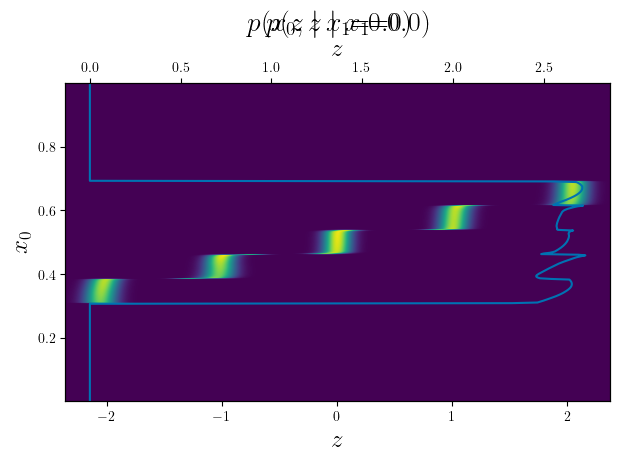

In [20]:
## Figure

vae_path = (f'../logs/{dataset}/imputation/vae_comptrain/seed_m20220118_d20220118/lightning_logs/'
            'version_0/checkpoints/last.ckpt')
vae = VAE.load_from_checkpoint(vae_path)
vae = vae.eval()

dims = data[:].shape[-1]

max_v = data[:].max()
min_v = data[:].min()

params = {
    'comp_logits': torch.tensor(np.log(data.data_file['comp_probs'])),
    'covs': torch.tensor(data.data_file['covs']),
    'means': torch.tensor(data.data_file['means'])
}

fig = plt.figure(figsize=(17,4.5), constrained_layout=True)
gs = gridspec.GridSpec(ncols=3, nrows=1, figure=fig, 
                       top=0.9
                      )

ax = fig.add_subplot(gs[0, 0])

limits = (min_v, max_v)
bins = 5000

vae_integration_kwargs={'latent_min':0., 
                        'latent_max':1.+1e-8, 
                        'latent_bins': 500}
X_true = torch.tensor([float('nan'), 0.])
M = torch.tensor([0, 1], dtype=torch.bool)

x = np.linspace(limits[0], limits[1], bins, dtype=np.float32)
dx = (limits[1] - limits[0]) / bins

vae_logpdf = vae_compute_conditional_logpdf(x, dx, X_true, M, vae, params, vae_integration_kwargs)
vae_logpdf = asnumpy(vae_logpdf)
vae_pdf = np.exp(vae_logpdf)
# ax.plot(x, vae_pdf ,linewidth=5., label='True VAE')

vae_latent_pdf_kwargs={'latent_min':0.+1e-6, 
                        'latent_max':1.-1e-6, 
                        'latent_bins': 500}
latent_x_bins = 5000
latent_x = np.linspace(limits[0], limits[1], latent_x_bins, dtype=np.float32)

pz_logpdf = vae_true_latent_posterior_logpdf_1d(latent_x, X_true, M, vae, vae_latent_pdf_kwargs)
pz_logpdf = rearrange(asnumpy(pz_logpdf), 'd z -> z d')
pz_pdf = np.exp(pz_logpdf)

pzp_logpdf = pz_logpdf + vae_logpdf[None, :]
pzp_pdf = np.exp(pzp_logpdf)

im = ax.imshow(pzp_pdf, 
                    extent=(limits[0], limits[1],
                           vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                    origin='lower', aspect='auto')
# ax.set_title('$z$', fontsize=20)
obs_value = X_true[torch.where(M)].item()
ax.set_title(f'$p(x_0, z \mid x_1\!\!=\!\!{obs_value})$', fontsize=20)
ax.set_xlabel('$z$', fontsize=18)
ax.set_ylabel('$x_0$', fontsize=18)

# ax = fig.add_subplot(gs[0, 1])
ax = ax.twiny()

pz_marg_logpdf = torch.logsumexp(torch.tensor(pzp_logpdf), dim=-1) + torch.log(torch.tensor(dx))
pz_marg_pdf = torch.exp(pz_marg_logpdf)
pz_marg_pdf = pz_marg_pdf.numpy()
Z = torch.linspace(vae_integration_kwargs['latent_min'], vae_integration_kwargs['latent_max'], 
                   vae_integration_kwargs['latent_bins'])

ax.plot(pz_marg_pdf, Z)
ax.set_title(f'$p(z \mid x_1\!\!=\!\!{obs_value})$', fontsize=20)
ax.set_xlabel('$z$', fontsize=18)
ax.set_ylabel('pdf', fontsize=18)


# artists1[0].text(0.5, 1.1, '$p(x)$',
#         verticalalignment='center', horizontalalignment='center',
#         transform=artists1[0].transAxes,fontsize=15)
artists1[0].set_title('$p(x)$', fontsize=20)
artists1[0].set_xlabel('$x_1$', fontsize=18)
artists1[0].set_ylabel('$x_0$', fontsize=18)

artists2[0].set_ylabel('')
artists2[0].set_yticklabels([])
# artists2[0].text(0.5, 1.1, '$\mathbb{E}_{p(z \mid x)}[z]$',
#         verticalalignment='center', horizontalalignment='center',
#         transform=artists2[0].transAxes,fontsize=15)
artists2[0].set_title('$\mathbb{E}_{p(z \mid x)}[z]$', fontsize=20)
artists2[0].set_xlabel('$x_1$', fontsize=18)

# gs.tight_layout()

# fig.savefig('./figures/mog2dgrid_model_and_expected_latents_and_conditional_examples.pdf')

### Finetuned with ELBO 

In [25]:
vae_path = (f'../logs/{dataset}/imputation/vae_from_pretrained_comptrain/seed_m20220118_d20220118/lightning_logs/'
            'version_0/checkpoints/last.ckpt')
vae = VAE.load_from_checkpoint(vae_path)
vae = vae.eval()

num_datapoints = 3000
vae_samples = vae.sample(num_datapoints)


dims = data[:].shape[-1]

max_v = data[:].max()
min_v = data[:].min()

params = {
    'comp_logits': torch.tensor(np.log(data.data_file['comp_probs'])),
    'covs': torch.tensor(data.data_file['covs']),
    'means': torch.tensor(data.data_file['means'])
}


frames = []

fig = plt.figure(figsize=(9,9))
gs = gridspec.GridSpec(ncols=dims-1, nrows=dims-1, figure=fig)

artists = plot_pairwise_marginal_contourfs(fig, gs, dims, (min_v, max_v), 
                                           mog_params=params, 
                                           rasterize_contours=True,
                                           bins=100, 
#                                            data=data[:num_datapoints]
                                           levels=20,
                                           hide_ticks=False,
                                                  )
for i in range(len(params['means'])):
    mean_i = asnumpy(params['means'][i])
    artists[0].text(mean_i[1], mean_i[0], f'{i}', va='center', ha='center', fontsize=16)

frames.append(artists)

# artists = plot_pairwise_marginal_contourfs(fig, gs, dims, (min_v, max_v), 
#                                            mog_params=params, 
#                                            rasterize_contours=True,
#                                            bins=100, 
#                                            data=data[:num_datapoints],
#                                            scatter_color='m',
#                                            levels=20,
#                                            hide_ticks=False,
#                                            )

# for i in range(len(params['means'])):
#     mean_i = asnumpy(params['means'][i])
#     artists[0].text(mean_i[1], mean_i[0], f'{i}', va='center', ha='center', fontsize=16)

# frames.append(artists)

# artists = plot_pairwise_marginal_contourfs(fig, gs, dims, (min_v, max_v), 
#                                            mog_params=params, 
#                                            rasterize_contours=True,
#                                            bins=100, 
#                                            data=vae_samples,
#                                            scatter_color='r',
#                                            levels=20,
#                                            hide_ticks=False,
#                                            )

# for i in range(len(params['means'])):
#     mean_i = asnumpy(params['means'][i])
#     artists[0].text(mean_i[1], mean_i[0], f'{i}', va='center', ha='center', fontsize=16)

# frames.append(artists)

artists = plot_pairwise_marginal_contourfs(fig, gs, dims, (min_v, max_v), 
#                                            mog_params=params, 
                                           vae=vae,
                                           vae_integration_kwargs={'latent_min':0., 
                                                                   'latent_max':1.+1e-8, 
                                                                   'latent_bins': 100},
                                           rasterize_contours=True,
                                           bins=100, 
                                           levels=20,
                                           hide_ticks=False,
                                           )
for i in range(len(params['means'])):
    mean_i = asnumpy(params['means'][i])
    artists[0].text(mean_i[1], mean_i[0], f'{i}', va='center', ha='center', fontsize=16)


frames.append(artists)

artists = plot_2d_vae_var_latent_expected_values(fig, vae=vae, limits=(min_v, max_v), 
                                           bins=100, 
                                           hide_ticks=False,
                                           )
for i in range(len(params['means'])):
    mean_i = asnumpy(params['means'][i])
    artists[0].text(mean_i[1], mean_i[0], f'{i}', va='center', ha='center', fontsize=16)

frames.append(artists)

artists = plot_2d_vae_latent_post_expected_values(fig, vae=vae, limits=(min_v, max_v), 
                                                  bins=100, 
                                                  vae_integration_kwargs={'latent_min':0., 
                                                                   'latent_max':1.+1e-8, 
                                                                   'latent_bins': 100},
                                           hide_ticks=False,
                                                  )
for i in range(len(params['means'])):
    mean_i = asnumpy(params['means'][i])
    artists[0].text(mean_i[1], mean_i[0], f'{i}', va='center', ha='center', fontsize=16)

frames.append(artists)


plt.close(fig)

anim = ArtistAnimation(fig, frames)
video = anim.to_jshtml()
# Alternative, but low-resolution
# video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)

/home/vaidas/miniconda3/envs/irwg/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'generator_network' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['generator_network'])`.
  rank_zero_warn(
/home/vaidas/miniconda3/envs/irwg/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'var_latent_network' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['var_latent_network'])`.
  rank_zero_warn(
/tmp/ipykernel_697127/1998006740.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_697127/4151012803.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorr

### Finetuned with ELBO (only encoder)

In [26]:
vae_path = (f'../logs/{dataset}/imputation/vae_from_pretrained_comptrain_fixgenerator/seed_m20220118_d20220118/lightning_logs/'
            'version_0/checkpoints/last.ckpt')
vae = VAE.load_from_checkpoint(vae_path)
vae = vae.eval()

num_datapoints = 3000
vae_samples = vae.sample(num_datapoints)


dims = data[:].shape[-1]

max_v = data[:].max()
min_v = data[:].min()

params = {
    'comp_logits': torch.tensor(np.log(data.data_file['comp_probs'])),
    'covs': torch.tensor(data.data_file['covs']),
    'means': torch.tensor(data.data_file['means'])
}


frames = []

fig = plt.figure(figsize=(9,9))
gs = gridspec.GridSpec(ncols=dims-1, nrows=dims-1, figure=fig)

artists = plot_pairwise_marginal_contourfs(fig, gs, dims, (min_v, max_v), 
                                           mog_params=params, 
                                           rasterize_contours=True,
                                           bins=100, 
#                                            data=data[:num_datapoints]
                                           levels=20,
                                           hide_ticks=False,
                                                  )
for i in range(len(params['means'])):
    mean_i = asnumpy(params['means'][i])
    artists[0].text(mean_i[1], mean_i[0], f'{i}', va='center', ha='center', fontsize=16)

frames.append(artists)

# artists = plot_pairwise_marginal_contourfs(fig, gs, dims, (min_v, max_v), 
#                                            mog_params=params, 
#                                            rasterize_contours=True,
#                                            bins=100, 
#                                            data=data[:num_datapoints],
#                                            scatter_color='m',
#                                            levels=20,
#                                            hide_ticks=False,
#                                            )

# for i in range(len(params['means'])):
#     mean_i = asnumpy(params['means'][i])
#     artists[0].text(mean_i[1], mean_i[0], f'{i}', va='center', ha='center', fontsize=16)

# frames.append(artists)

# artists = plot_pairwise_marginal_contourfs(fig, gs, dims, (min_v, max_v), 
#                                            mog_params=params, 
#                                            rasterize_contours=True,
#                                            bins=100, 
#                                            data=vae_samples,
#                                            scatter_color='r',
#                                            levels=20,
#                                            hide_ticks=False,
#                                            )

# for i in range(len(params['means'])):
#     mean_i = asnumpy(params['means'][i])
#     artists[0].text(mean_i[1], mean_i[0], f'{i}', va='center', ha='center', fontsize=16)

# frames.append(artists)

artists = plot_pairwise_marginal_contourfs(fig, gs, dims, (min_v, max_v), 
#                                            mog_params=params, 
                                           vae=vae,
                                           vae_integration_kwargs={'latent_min':0., 
                                                                   'latent_max':1.+1e-8, 
                                                                   'latent_bins': 100},
                                           rasterize_contours=True,
                                           bins=100, 
                                           levels=20,
                                           hide_ticks=False,
                                           )
for i in range(len(params['means'])):
    mean_i = asnumpy(params['means'][i])
    artists[0].text(mean_i[1], mean_i[0], f'{i}', va='center', ha='center', fontsize=16)

frames.append(artists)

artists = plot_2d_vae_var_latent_expected_values(fig, vae=vae, limits=(min_v, max_v), 
                                           bins=100, 
                                           hide_ticks=False,
                                           )
for i in range(len(params['means'])):
    mean_i = asnumpy(params['means'][i])
    artists[0].text(mean_i[1], mean_i[0], f'{i}', va='center', ha='center', fontsize=16)

frames.append(artists)

artists = plot_2d_vae_latent_post_expected_values(fig, vae=vae, limits=(min_v, max_v), 
                                                  bins=100, 
                                                  vae_integration_kwargs={'latent_min':0., 
                                                                   'latent_max':1.+1e-8, 
                                                                   'latent_bins': 100},
                                           hide_ticks=False,
                                                  )
for i in range(len(params['means'])):
    mean_i = asnumpy(params['means'][i])
    artists[0].text(mean_i[1], mean_i[0], f'{i}', va='center', ha='center', fontsize=16)

frames.append(artists)


plt.close(fig)

anim = ArtistAnimation(fig, frames)
video = anim.to_jshtml()
# Alternative, but low-resolution
# video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)

/home/vaidas/miniconda3/envs/irwg/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'generator_network' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['generator_network'])`.
  rank_zero_warn(
/home/vaidas/miniconda3/envs/irwg/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'var_latent_network' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['var_latent_network'])`.
  rank_zero_warn(
/tmp/ipykernel_697127/1998006740.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_697127/4151012803.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorr

## Imputations 

### Pretrained (supervised)

#### MWG failures due to large valleys in $p(x_m \mid x_o)$

In [24]:
vae_model_name = 'vae_comptrain'
checkpoint_name = 'last'
vae_path = (f'../logs/{dataset}/imputation/{vae_model_name}/seed_m20220118_d20220118/lightning_logs/'
            f'version_0/checkpoints/{checkpoint_name}.ckpt')

imp_path_template = (f'../logs/{dataset}/imputation/sampling/{vae_model_name}/'
                     '{}/seed_m20220118_d20220118/lightning_logs/')
imputation_cfgs = {
    'MWG PGW1 K=1 it50000': {
        'path': imp_path_template.format('mwg_k1_no_warmup_it50000')
    },
#     'MWGM PGW1 K=1 it50000': {
#         'path': imp_path_template.format('mwgm_k1_no_warmup_it50000')
#     },
    'MWGM+H PGW1 K=1 it50000': {
        'path': imp_path_template.format('mwgm_usehistinproposal_k1_no_warmup_it50000')
    },
#     'MWGM+H PGW1 K=1 it500000': {
#         'path': imp_path_template.format('mwgm_usehistinproposal_k1_no_warmup_it500000')
#     },
    'MWGM+RH PGW1 K=1 it50000': {
        'path': imp_path_template.format('mwgm_userestricthist_000prior_k1_no_warmup_it50000')
    },
    'IRWG K=5 DMIS GR it10000': {
        'path': imp_path_template.format('irwg_k5_dmis_gr_mult_it10000')
    },
}

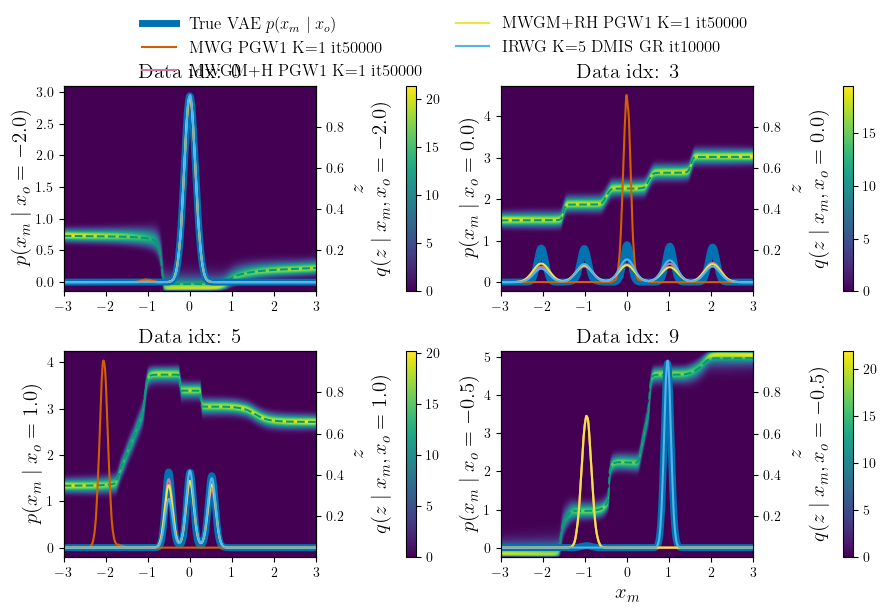

In [25]:
limits = (-3, 3)
bins = 5000

data_idxs = [0, 3, 5, 9]
plot_mog = False


plot_var_latent = True
plot_true_latent = False
assert not (plot_var_latent and plot_true_latent)
latent_pdf_plot_log = False
plot_latent_joint_vae = False
var_temperature=None

pdf_plot_log = False

plot_scatter = False
scatter_alpha = 0.1
vae_integration_kwargs={'latent_min':0., 
                        'latent_max':1.+1e-8, 
                        'latent_bins': 500}
latent_x_bins = 5000
vae_latent_pdf_kwargs={'latent_min':0.+1e-6, 
                        'latent_max':1.-1e-6, 
                        'latent_bins': 500}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = colors + ['r', 'm', 'w', 'g', 'k', 'c', 'y', 'tomato']
color_idx = 0

vae = VAE.load_from_checkpoint(vae_path)
vae = vae.eval()

fig, ax = plt.subplots(2, 2, figsize=(9, 6))
ax = ax.flatten()

divergences = {}
for d, data_idx in enumerate(data_idxs):
    color_idx = 0
    divergences[data_idx] = {}
    for i, (method, cfg) in enumerate(imputation_cfgs.items()):
        divergences[data_idx][method] = {}
        imputations = load_imputations_from_experiment(cfg['path'])

        X_imp = imputations['imputations'][data_idx]
        M = imputations['masks'][data_idx, 0]
        miss_idx = np.where(~M)[0][0]
        X_imp = X_imp[..., miss_idx]
        X_imp = rearrange(X_imp, 'k t -> (k t)')

        X_true = imputations['true_X'][data_idx, 0]
        obs_idx = np.where(M)[0][0]

        x = np.linspace(limits[0], limits[1], bins, dtype=np.float32)
        dx = (limits[1] - limits[0]) / bins
        
        # Plot MoG
        if i == 0 and plot_mog:
            mog_logpdf = mog_compute_conditional_logpdf(x, X_true, M, params)
            mog_logpdf = asnumpy(mog_logpdf)
            mog_pdf = np.exp(asnumpy)
            ax[d].plot(x, mog_logpdf if pdf_plot_log else mog_pdf ,linewidth=5., 
                              color=colors[color_idx], label='True MoG $p(x_m \mid x_o)$')
            color_idx += 1

        # Plot VAE
        if i == 0:
            vae_logpdf = vae_compute_conditional_logpdf(x, dx, X_true, M, vae, params, vae_integration_kwargs)
            vae_logpdf = asnumpy(vae_logpdf)
            vae_pdf = np.exp(vae_logpdf)
            ax[d].plot(x, vae_logpdf if pdf_plot_log else vae_pdf ,linewidth=5., 
                              color=colors[color_idx], label='True VAE $p(x_m \mid x_o)$')
            
            color_idx += 1
            
            max_height = vae_pdf.max()
            
        # Plot var latent
        if i == 0 and plot_var_latent:
            latent_x = np.linspace(limits[0], limits[1], latent_x_bins, dtype=np.float32)
            
            ax_twin = ax[d].twinx()
            
            encoder_z_exp_vals = vae_encoder_latent_posterior_expected_value_1d(latent_x, X_true, M, vae, temperature=var_temperature)
            ax_twin.plot(latent_x, encoder_z_exp_vals, color=colors[color_idx], linestyle='--')
            color_idx += 1
            
            q_logpdf = vae_encoder_latent_posterior_logpdf_1d(latent_x, M, X_true, vae, vae_latent_pdf_kwargs, temperature=var_temperature)
            q_logpdf = rearrange(asnumpy(q_logpdf), 'd z -> z d')
            q_pdf = np.exp(q_logpdf)
            if plot_latent_joint_vae:
                qp_logpdf = q_logpdf + vae_logpdf[None, :]
                qp_pdf = np.exp(qp_logpdf)
                im = ax_twin.imshow(qp_logpdf if latent_pdf_plot_log else qp_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower')
            else:
                im = ax_twin.imshow(q_logpdf if latent_pdf_plot_log else q_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower')
            fig.colorbar(im, ax=ax_twin, anchor=(2., 0.5))
            
            ax_twin.set_aspect('auto')
            ax_twin.set_zorder(ax[d].get_zorder() - 1)
            
            latent_plotting_pdf_label_prefix = ''
            if latent_pdf_plot_log:
                latent_plotting_pdf_label_prefix = '\log'
            if plot_latent_joint_vae:
                ax_twin.set_ylabel(f'$z$\r\n${latent_plotting_pdf_label_prefix} pq(x_m, z \mid x_o={X_true[obs_idx]})$', fontsize=15)
            else:
                ax_twin.set_ylabel(f'$z$\r\n${latent_plotting_pdf_label_prefix} q(z \mid x_m, x_o={X_true[obs_idx]})$', fontsize=15)
            ax[d].patch.set_alpha(0.)
            
        # Plot true latent
        if i == 0 and plot_true_latent:
            latent_x = np.linspace(limits[0], limits[1], latent_x_bins, dtype=np.float32)
            
            ax_twin = ax[d].twinx()
            
            true_z_exp_vals = vae_true_latent_posterior_expected_value_1d(latent_x, X_true, M, vae, vae_latent_pdf_kwargs)
            ax_twin.plot(latent_x, true_z_exp_vals, color=colors[color_idx], linestyle='--')
            color_idx += 1
            
            pz_logpdf = vae_true_latent_posterior_logpdf_1d(latent_x, X_true, M, vae, vae_latent_pdf_kwargs)
            pz_logpdf = rearrange(asnumpy(pz_logpdf), 'd z -> z d')
            pz_pdf = np.exp(pz_logpdf)
            if plot_latent_joint_vae:
                pzp_logpdf = pz_logpdf + vae_logpdf[None, :]
                pzp_pdf = np.exp(pzp_logpdf)
                
                im = ax_twin.imshow(pzp_logpdf if latent_pdf_plot_log else pzp_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower')
            else:
                im = ax_twin.imshow(pz_logpdf if latent_pdf_plot_log else pz_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower')
            fig.colorbar(im, ax=ax_twin, anchor=(2., 0.5))
            
            ax_twin.set_aspect('auto')
            ax_twin.set_zorder(ax[d].get_zorder() - 1)
            
            latent_plotting_pdf_label_prefix = ''
            if latent_pdf_plot_log:
                latent_plotting_pdf_label_prefix = '\log'
            if plot_latent_joint_vae:
                ax_twin.set_ylabel(f'$z$\r\n${latent_plotting_pdf_label_prefix} p(x_m, z \mid x_o={X_true[obs_idx]})$', fontsize=15)
            else:
                ax_twin.set_ylabel(f'$z$\r\n${latent_plotting_pdf_label_prefix} p(z \mid x_m, x_o={X_true[obs_idx]})$', fontsize=15)
            ax[d].patch.set_alpha(0.)

            
        # Plot KDE
        kde_imp = sstats.gaussian_kde(X_imp)
        logpdf = kde_imp.logpdf(x)
        pdf = np.exp(logpdf)
        ax[d].plot(x, logpdf if pdf_plot_log else pdf, color=colors[color_idx], label=method)
        
        if plot_scatter:
            scatter_height = max_height/20
            ax[d].scatter(X_imp, np.zeros(X_imp.shape[0])-(i+1)*scatter_height, 
                                 marker='.', alpha=scatter_alpha,
                                 color=colors[color_idx])
            
        color_idx += 1
        
        plotting_pdf_label_prefix = ''
        if pdf_plot_log:
            plotting_pdf_label_prefix = '\log'
        ax[d].set_ylabel(f'${plotting_pdf_label_prefix} p(x_m \mid x_o={X_true[obs_idx]})$', fontsize=15)
        
#         ax[d].set_title(f'Data idx: {data_idx}, observed value: {X_true}, observed dim: {obs_idx}', fontsize=15)
        ax[d].set_title(f'Data idx: {data_idx}', fontsize=15)
        
        
        # Compute KL divergences
        kl_fow, kl_rev, jsd = compute_divergences_between_logpds_arrays(vae_logpdf, logpdf, dx)
        divergences[data_idx][method]['kl_fow'] = kl_fow
        divergences[data_idx][method]['kl_rev'] = kl_rev
        divergences[data_idx][method]['jsd'] = jsd
    divergences[data_idx]['title'] = f'Data idx: {data_idx}, observed value: {X_true}, observed dim: {obs_idx}'

#     ax[data_idx].legend(fancybox=True, framealpha=0.4)
#     if plot_true_latent or plot_var_latent:
#         ax[data_idx].legend(bbox_to_anchor=(1.7, 1.00))
#     else:
#         ax[data_idx].legend(bbox_to_anchor=(1.01, 1.00))
#     ax[d].legend(loc='best')
    ax[d].set_xlim(limits[0], limits[1])
    
ax[d].set_xlabel('$x_m$', fontsize=15)
fig.subplots_adjust(wspace=10)

fig.tight_layout(rect=(0, 0, 1, 0.95))
ax[0].legend(ncol=2, 
          bbox_to_anchor=(0.5, 0.95), 
          bbox_transform=fig.transFigure, 
          loc='center',
          fontsize=12,
          frameon=False)

# fig.savefig('figures/2dgridmog4_mwg_failures.pdf')
# fig.savefig('figures/2dgridmog4_mwg_vs_mwgm_failures.pdf')
# fig.savefig('figures/2dgridmog4_mwg_vs_mwgm_and_irwg.pdf')

In [22]:
for data_idx, divs in divergences.items():
    print(divs['title'])
    divs = {m: d for (m, d) in divs.items() if m != 'title' }
    print(f'| {"Method":<35} | {"KL(p||q)":<11} | {"KL(q||p)":<11} | {"JSD(p||q)":<11} |')
    print('-'*60+'-'*16)
    smallest = {}
    for i, (method, metrics) in enumerate(divs.items()):
        for k, v in metrics.items():
            if i == 0 or smallest[k] > v:
                smallest[k] = v
                smallest[f'method_{k}'] = method
            
    for method, metrics in divs.items():
        klfow_star, klrev_star, jsd_star = '', '', ''
        if smallest['method_kl_fow'] == method:
            klfow_star = '*'
        if smallest['method_kl_rev'] == method:
            klrev_star = '*'
        if smallest['method_jsd'] == method:
            jsd_star = '*'
            
        print(f'| {method:<35} | {metrics["kl_fow"]:<8,.5f}{klfow_star:<3} | {metrics["kl_rev"]:<8,.5f}{klrev_star:<3} | {metrics["jsd"]:<8,.5f}{jsd_star:<3} |')
    print()

Data idx: 0, observed value: [nan -2.], observed dim: 1
| Method                              | KL(p||q)    | KL(q||p)    | JSD(p||q)   |
----------------------------------------------------------------------------
| MWG PGW1 K=1 it50000                | 0.01308     | 0.28890     | 0.00443     |
| MWGM+H PGW1 K=1 it50000             | 0.00184 *   | 0.03127 *   | 0.00053 *   |

Data idx: 3, observed value: [nan  0.], observed dim: 1
| Method                              | KL(p||q)    | KL(q||p)    | JSD(p||q)   |
----------------------------------------------------------------------------
| MWG PGW1 K=1 it50000                | 3,819.76044    | 1.66681     | 0.42529     |
| MWGM+H PGW1 K=1 it50000             | 0.32048 *   | 0.72909 *   | 0.09217 *   |

Data idx: 5, observed value: [nan  1.], observed dim: 1
| Method                              | KL(p||q)    | KL(q||p)    | JSD(p||q)   |
----------------------------------------------------------------------------
| MWG PGW1 K=1 it50000

#### Latent failures due to large valleys in $p(z \mid x_o)$

In [13]:
vae_model_name = 'vae_comptrain'
checkpoint_name = 'last'
vae_path = (f'../logs/{dataset}/imputation/{vae_model_name}/seed_m20220118_d20220118/lightning_logs/'
            f'version_0/checkpoints/{checkpoint_name}.ckpt')

imp_path_template = (f'../logs/{dataset}/imputation/sampling/{vae_model_name}/'
                     '{}/seed_m20220118_d20220118/lightning_logs/')
imputation_cfgs = {
    'MWG PGW1 K=1 it50000': {
        'path': imp_path_template.format('mwg_k1_no_warmup_it50000')
    },
#     'MWGM PGW1 K=1 it50000': {
#         'path': imp_path_template.format('mwgm_k1_no_warmup_it50000')
#     },
    'MWGM+H PGW1 K=1 it50000': {
        'path': imp_path_template.format('mwgm_usehistinproposal_k1_no_warmup_it50000')
    },
#     'MWGM+H PGW1 K=1 it500000': {
#         'path': imp_path_template.format('mwgm_usehistinproposal_k1_no_warmup_it500000')
#     },
    'IRWG K=5 DMIS GR it10000': {
        'path': imp_path_template.format('irwg_k5_dmis_gr_mult_it10000')
    },
}

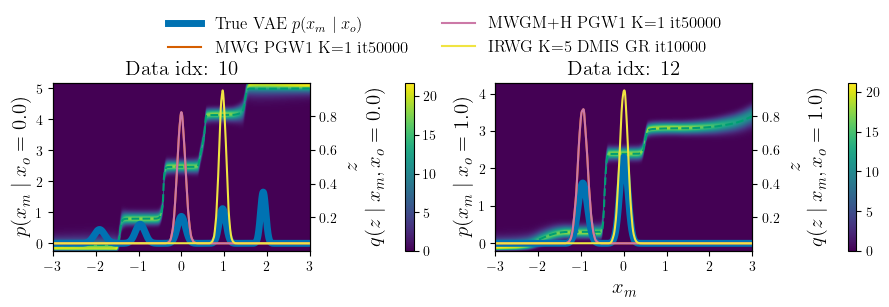

In [26]:
limits = (-3, 3)
bins = 5000

data_idxs = [10, 12]
plot_mog = False


plot_var_latent = True
plot_true_latent = False
assert not (plot_var_latent and plot_true_latent)
latent_pdf_plot_log = False
plot_latent_joint_vae = False
var_temperature=None

pdf_plot_log = False

plot_scatter = False
scatter_alpha = 0.1
vae_integration_kwargs={'latent_min':0., 
                        'latent_max':1.+1e-8, 
                        'latent_bins': 500}
latent_x_bins = 5000
vae_latent_pdf_kwargs={'latent_min':0.+1e-6, 
                        'latent_max':1.-1e-6, 
                        'latent_bins': 500}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = colors + ['r', 'm', 'w', 'g', 'k', 'c', 'y', 'tomato']
color_idx = 0

vae = VAE.load_from_checkpoint(vae_path)
vae = vae.eval()

fig, ax = plt.subplots(1, 2, figsize=(9, 3))
ax = ax.flatten()

divergences = {}
for d, data_idx in enumerate(data_idxs):
    color_idx = 0
    divergences[data_idx] = {}
    for i, (method, cfg) in enumerate(imputation_cfgs.items()):
        divergences[data_idx][method] = {}
        imputations = load_imputations_from_experiment(cfg['path'])

        X_imp = imputations['imputations'][data_idx]
        M = imputations['masks'][data_idx, 0]
        miss_idx = np.where(~M)[0][0]
        X_imp = X_imp[..., miss_idx]
        X_imp = rearrange(X_imp, 'k t -> (k t)')

        X_true = imputations['true_X'][data_idx, 0]
        obs_idx = np.where(M)[0][0]

        x = np.linspace(limits[0], limits[1], bins, dtype=np.float32)
        dx = (limits[1] - limits[0]) / bins
        
        # Plot MoG
        if i == 0 and plot_mog:
            mog_logpdf = mog_compute_conditional_logpdf(x, X_true, M, params)
            mog_logpdf = asnumpy(mog_logpdf)
            mog_pdf = np.exp(asnumpy)
            ax[d].plot(x, mog_logpdf if pdf_plot_log else mog_pdf ,linewidth=5., 
                              color=colors[color_idx], label='True MoG $p(x_m \mid x_o)$')
            color_idx += 1

        # Plot VAE
        if i == 0:
            vae_logpdf = vae_compute_conditional_logpdf(x, dx, X_true, M, vae, params, vae_integration_kwargs)
            vae_logpdf = asnumpy(vae_logpdf)
            vae_pdf = np.exp(vae_logpdf)
            ax[d].plot(x, vae_logpdf if pdf_plot_log else vae_pdf ,linewidth=5., 
                              color=colors[color_idx], label='True VAE $p(x_m \mid x_o)$')
            
            color_idx += 1
            
            max_height = vae_pdf.max()
            
        # Plot var latent
        if i == 0 and plot_var_latent:
            latent_x = np.linspace(limits[0], limits[1], latent_x_bins, dtype=np.float32)
            
            ax_twin = ax[d].twinx()
            
            encoder_z_exp_vals = vae_encoder_latent_posterior_expected_value_1d(latent_x, X_true, M, vae, temperature=var_temperature)
            ax_twin.plot(latent_x, encoder_z_exp_vals, color=colors[color_idx], linestyle='--')
            color_idx += 1
            
            q_logpdf = vae_encoder_latent_posterior_logpdf_1d(latent_x, M, X_true, vae, vae_latent_pdf_kwargs, temperature=var_temperature)
            q_logpdf = rearrange(asnumpy(q_logpdf), 'd z -> z d')
            q_pdf = np.exp(q_logpdf)
            if plot_latent_joint_vae:
                qp_logpdf = q_logpdf + vae_logpdf[None, :]
                qp_pdf = np.exp(qp_logpdf)
                im = ax_twin.imshow(qp_logpdf if latent_pdf_plot_log else qp_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower')
            else:
                im = ax_twin.imshow(q_logpdf if latent_pdf_plot_log else q_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower')
            fig.colorbar(im, ax=ax_twin, anchor=(2., 0.5))
            
            ax_twin.set_aspect('auto')
            ax_twin.set_zorder(ax[d].get_zorder() - 1)
            
            latent_plotting_pdf_label_prefix = ''
            if latent_pdf_plot_log:
                latent_plotting_pdf_label_prefix = '\log'
            if plot_latent_joint_vae:
                ax_twin.set_ylabel(f'$z$\r\n${latent_plotting_pdf_label_prefix} pq(x_m, z \mid x_o={X_true[obs_idx]})$', fontsize=15)
            else:
                ax_twin.set_ylabel(f'$z$\r\n${latent_plotting_pdf_label_prefix} q(z \mid x_m, x_o={X_true[obs_idx]})$', fontsize=15)
            ax[d].patch.set_alpha(0.)
            
        # Plot true latent
        if i == 0 and plot_true_latent:
            latent_x = np.linspace(limits[0], limits[1], latent_x_bins, dtype=np.float32)
            
            ax_twin = ax[d].twinx()
            
            true_z_exp_vals = vae_true_latent_posterior_expected_value_1d(latent_x, X_true, M, vae, vae_latent_pdf_kwargs)
            ax_twin.plot(latent_x, true_z_exp_vals, color=colors[color_idx], linestyle='--')
            color_idx += 1
            
            pz_logpdf = vae_true_latent_posterior_logpdf_1d(latent_x, X_true, M, vae, vae_latent_pdf_kwargs)
            pz_logpdf = rearrange(asnumpy(pz_logpdf), 'd z -> z d')
            pz_pdf = np.exp(pz_logpdf)
            if plot_latent_joint_vae:
                pzp_logpdf = pz_logpdf + vae_logpdf[None, :]
                pzp_pdf = np.exp(pzp_logpdf)
                
                im = ax_twin.imshow(pzp_logpdf if latent_pdf_plot_log else pzp_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower')
            else:
                im = ax_twin.imshow(pz_logpdf if latent_pdf_plot_log else pz_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower')
            fig.colorbar(im, ax=ax_twin, anchor=(2., 0.5))
            
            ax_twin.set_aspect('auto')
            ax_twin.set_zorder(ax[d].get_zorder() - 1)
            
            latent_plotting_pdf_label_prefix = ''
            if latent_pdf_plot_log:
                latent_plotting_pdf_label_prefix = '\log'
            if plot_latent_joint_vae:
                ax_twin.set_ylabel(f'$z$\r\n${latent_plotting_pdf_label_prefix} p(x_m, z \mid x_o={X_true[obs_idx]})$', fontsize=15)
            else:
                ax_twin.set_ylabel(f'$z$\r\n${latent_plotting_pdf_label_prefix} p(z \mid x_m, x_o={X_true[obs_idx]})$', fontsize=15)
            ax[d].patch.set_alpha(0.)

            
        # Plot KDE
        kde_imp = sstats.gaussian_kde(X_imp)
        logpdf = kde_imp.logpdf(x)
        pdf = np.exp(logpdf)
        ax[d].plot(x, logpdf if pdf_plot_log else pdf, color=colors[color_idx], label=method)
        
        if plot_scatter:
            scatter_height = max_height/20
            ax[d].scatter(X_imp, np.zeros(X_imp.shape[0])-(i+1)*scatter_height, 
                                 marker='.', alpha=scatter_alpha,
                                 color=colors[color_idx])
            
        color_idx += 1
        
        plotting_pdf_label_prefix = ''
        if pdf_plot_log:
            plotting_pdf_label_prefix = '\log'
        ax[d].set_ylabel(f'${plotting_pdf_label_prefix} p(x_m \mid x_o={X_true[obs_idx]})$', fontsize=15)
        
#         ax[d].set_title(f'Data idx: {data_idx}, observed value: {X_true}, observed dim: {obs_idx}', fontsize=15)
        ax[d].set_title(f'Data idx: {data_idx}', fontsize=15)
        
        
        # Compute KL divergences
        kl_fow, kl_rev, jsd = compute_divergences_between_logpds_arrays(vae_logpdf, logpdf, dx)
        divergences[data_idx][method]['kl_fow'] = kl_fow
        divergences[data_idx][method]['kl_rev'] = kl_rev
        divergences[data_idx][method]['jsd'] = jsd
    divergences[data_idx]['title'] = f'Data idx: {data_idx}, observed value: {X_true}, observed dim: {obs_idx}'

#     ax[data_idx].legend(fancybox=True, framealpha=0.4)
#     if plot_true_latent or plot_var_latent:
#         ax[data_idx].legend(bbox_to_anchor=(1.7, 1.00))
#     else:
#         ax[data_idx].legend(bbox_to_anchor=(1.01, 1.00))
#     ax[d].legend(loc='best')
    ax[d].set_xlim(limits[0], limits[1])
    
ax[d].set_xlabel('$x_m$', fontsize=15)
fig.subplots_adjust(wspace=10)

fig.tight_layout(rect=(0, 0, 1, 0.89))
ax[0].legend(ncol=2, 
          bbox_to_anchor=(0.5, 0.92), 
          bbox_transform=fig.transFigure, 
          loc='center',
          fontsize=12,
          frameon=False)

# fig.savefig('figures/2dgridmog4_latent_mixing_failures.pdf')

In [23]:
for data_idx, divs in divergences.items():
    print(divs['title'])
    divs = {m: d for (m, d) in divs.items() if m != 'title' }
    print(f'| {"Method":<35} | {"KL(p||q)":<11} | {"KL(q||p)":<11} | {"JSD(p||q)":<11} |')
    print('-'*60+'-'*16)
    smallest = {}
    for i, (method, metrics) in enumerate(divs.items()):
        for k, v in metrics.items():
            if i == 0 or smallest[k] > v:
                smallest[k] = v
                smallest[f'method_{k}'] = method
            
    for method, metrics in divs.items():
        klfow_star, klrev_star, jsd_star = '', '', ''
        if smallest['method_kl_fow'] == method:
            klfow_star = '*'
        if smallest['method_kl_rev'] == method:
            klrev_star = '*'
        if smallest['method_jsd'] == method:
            jsd_star = '*'
            
        print(f'| {method:<35} | {metrics["kl_fow"]:<8,.5f}{klfow_star:<3} | {metrics["kl_rev"]:<8,.5f}{klrev_star:<3} | {metrics["jsd"]:<8,.5f}{jsd_star:<3} |')
    print()

Data idx: 10, observed value: [ 0. nan], observed dim: 0
| Method                              | KL(p||q)    | KL(q||p)    | JSD(p||q)   |
----------------------------------------------------------------------------
| MWG PGW1 K=1 it50000                | 4,186.95517    | 1.56934     | 0.41557     |
| MWGM+H PGW1 K=1 it50000             | 4,182.55677    | 1.56936     | 0.41557     |
| IRWG K=5 DMIS GR it10000            | 531.38768*   | 1.49095 *   | 0.40043 *   |

Data idx: 12, observed value: [ 1. nan], observed dim: 0
| Method                              | KL(p||q)    | KL(q||p)    | JSD(p||q)   |
----------------------------------------------------------------------------
| MWG PGW1 K=1 it50000                | 453.82947    | 0.81101     | 0.24734     |
| MWGM+H PGW1 K=1 it50000             | 460.21799    | 0.81102     | 0.24734     |
| IRWG K=5 DMIS GR it10000            | 4.59319 *   | 0.58627 *   | 0.18542 *   |



#### Multiple chains K=500  it=100 for addressing the latent failures

In [87]:
vae_model_name = 'vae_comptrain'
checkpoint_name = 'last'
vae_path = (f'../logs/{dataset}/imputation/{vae_model_name}/seed_m20220118_d20220118/lightning_logs/'
            f'version_0/checkpoints/{checkpoint_name}.ckpt')

imp_path_template = (f'../logs/{dataset}/imputation/sampling/{vae_model_name}/'
                     '{}/seed_m20220118_d20220118/lightning_logs/')
imputation_cfgs = {
    'MWG PGW1 K=500 it100': {
        'path': imp_path_template.format('mwg_k500_no_warmup_it100')
    },
    'MWGM+H PGW1 K=500 it100': {
        'path': imp_path_template.format('mwgm_usehist_k500_no_warmup_it100')
    },
    'IRWG K=500 DMIS GR it100': {
        'path': imp_path_template.format('irwg_k500_dmis_gr_mult_it100')
    },
    'IRWG K=500 DMISG GLR5 it100': {
        'path': imp_path_template.format('irwg_k500_dmisg_glr5_mult_it100')
    },
}

vae 1.0000001220703123
MWG PGW1 K=500 it100 0.9998000002920802
MWGM+H PGW1 K=500 it100 0.9998000002845395
IRWG K=500 DMIS GR it100 0.9997999983758478
IRWG K=500 DMISG GLR5 it100 0.9998000002679176
vae 0.9999999023437499
MWG PGW1 K=500 it100 0.9997999999733487
MWGM+H PGW1 K=500 it100 0.9997999999341096
IRWG K=500 DMIS GR it100 0.9997999997054704
IRWG K=500 DMISG GLR5 it100 0.9997999996238436


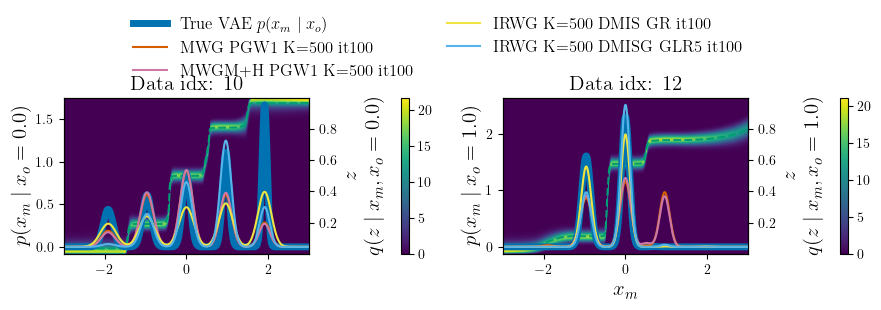

In [91]:
limits = (-3, 3)
bins = 5000
dx = (limits[1]-limits[0])/bins

data_idxs = [10, 12]
plot_mog = False


plot_var_latent = True
plot_true_latent = False
assert not (plot_var_latent and plot_true_latent)
latent_pdf_plot_log = False
plot_latent_joint_vae = False
var_temperature=None

pdf_plot_log = False

plot_scatter = False
scatter_alpha = 0.1
vae_integration_kwargs={'latent_min':0., 
                        'latent_max':1.+1e-8, 
                        'latent_bins': 5000}
latent_x_bins = 5000
vae_latent_pdf_kwargs={'latent_min':0.+1e-6, 
                        'latent_max':1.-1e-6, 
                        'latent_bins': 5000}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = colors + ['r', 'm', 'w', 'g', 'k', 'c', 'y', 'tomato']
color_idx = 0

vae = VAE.load_from_checkpoint(vae_path)
vae = vae.eval()

fig, ax = plt.subplots(1, 2, figsize=(9, 3))
ax = ax.flatten()

divergences = {}
for d, data_idx in enumerate(data_idxs):
    color_idx = 0
    divergences[data_idx] = {}
    for i, (method, cfg) in enumerate(imputation_cfgs.items()):
        divergences[data_idx][method] = {}
        imputations = load_imputations_from_experiment(cfg['path'])

        X_imp = imputations['imputations'][data_idx]
        M = imputations['masks'][data_idx, 0]
        miss_idx = np.where(~M)[0][0]
        X_imp = X_imp[..., miss_idx]
        X_imp = rearrange(X_imp, 'k t -> (k t)')

        X_true = imputations['true_X'][data_idx, 0]
        obs_idx = np.where(M)[0][0]

        x = np.linspace(limits[0], limits[1], bins, dtype=np.float32)
        dx = (limits[1] - limits[0]) / bins
        
        # Plot MoG
        if i == 0 and plot_mog:
            mog_logpdf = mog_compute_conditional_logpdf(x, X_true, M, params)
            mog_logpdf = asnumpy(mog_logpdf)
            mog_pdf = np.exp(asnumpy)
            ax[d].plot(x, mog_logpdf if pdf_plot_log else mog_pdf ,linewidth=5., 
                              color=colors[color_idx], label='True MoG $p(x_m \mid x_o)$')
            color_idx += 1

        # Plot VAE
        if i == 0:
            vae_logpdf = vae_compute_conditional_logpdf(x, dx, X_true, M, vae, params, vae_integration_kwargs)
            vae_logpdf = asnumpy(vae_logpdf)
            vae_pdf = np.exp(vae_logpdf)
            ax[d].plot(x, vae_logpdf if pdf_plot_log else vae_pdf ,linewidth=5., 
                              color=colors[color_idx], label='True VAE $p(x_m \mid x_o)$')
            print('vae', vae_pdf.sum()*dx)
            
            color_idx += 1
            
            max_height = vae_pdf.max()
            
        # Plot var latent
        if i == 0 and plot_var_latent:
            latent_x = np.linspace(limits[0], limits[1], latent_x_bins, dtype=np.float32)
            
            ax_twin = ax[d].twinx()
            
            encoder_z_exp_vals = vae_encoder_latent_posterior_expected_value_1d(latent_x, X_true, M, vae, temperature=var_temperature)
            ax_twin.plot(latent_x, encoder_z_exp_vals, color=colors[color_idx], linestyle='--')
            color_idx += 1
            
            q_logpdf = vae_encoder_latent_posterior_logpdf_1d(latent_x, M, X_true, vae, vae_latent_pdf_kwargs, temperature=var_temperature)
            q_logpdf = rearrange(asnumpy(q_logpdf), 'd z -> z d')
            q_pdf = np.exp(q_logpdf)
            if plot_latent_joint_vae:
                qp_logpdf = q_logpdf + vae_logpdf[None, :]
                qp_pdf = np.exp(qp_logpdf)
                im = ax_twin.imshow(qp_logpdf if latent_pdf_plot_log else qp_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower')
            else:
                im = ax_twin.imshow(q_logpdf if latent_pdf_plot_log else q_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower')
            fig.colorbar(im, ax=ax_twin, anchor=(2., 0.5))
            
            ax_twin.set_aspect('auto')
            ax_twin.set_zorder(ax[d].get_zorder() - 1)
            
            latent_plotting_pdf_label_prefix = ''
            if latent_pdf_plot_log:
                latent_plotting_pdf_label_prefix = '\log'
            if plot_latent_joint_vae:
                ax_twin.set_ylabel(f'$z$\r\n${latent_plotting_pdf_label_prefix} pq(x_m, z \mid x_o={X_true[obs_idx]})$', fontsize=15)
            else:
                ax_twin.set_ylabel(f'$z$\r\n${latent_plotting_pdf_label_prefix} q(z \mid x_m, x_o={X_true[obs_idx]})$', fontsize=15)
            ax[d].patch.set_alpha(0.)
            
        # Plot true latent
        if i == 0 and plot_true_latent:
            latent_x = np.linspace(limits[0], limits[1], latent_x_bins, dtype=np.float32)
            
            ax_twin = ax[d].twinx()
            
            true_z_exp_vals = vae_true_latent_posterior_expected_value_1d(latent_x, X_true, M, vae, vae_latent_pdf_kwargs)
            ax_twin.plot(latent_x, true_z_exp_vals, color=colors[color_idx], linestyle='--')
            color_idx += 1
            
            pz_logpdf = vae_true_latent_posterior_logpdf_1d(latent_x, X_true, M, vae, vae_latent_pdf_kwargs)
            pz_logpdf = rearrange(asnumpy(pz_logpdf), 'd z -> z d')
            pz_pdf = np.exp(pz_logpdf)
            if plot_latent_joint_vae:
                pzp_logpdf = pz_logpdf + vae_logpdf[None, :]
                pzp_pdf = np.exp(pzp_logpdf)
                
                im = ax_twin.imshow(pzp_logpdf if latent_pdf_plot_log else pzp_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower')
            else:
                im = ax_twin.imshow(pz_logpdf if latent_pdf_plot_log else pz_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower')
            fig.colorbar(im, ax=ax_twin, anchor=(2., 0.5))
            
            ax_twin.set_aspect('auto')
            ax_twin.set_zorder(ax[d].get_zorder() - 1)
            
            latent_plotting_pdf_label_prefix = ''
            if latent_pdf_plot_log:
                latent_plotting_pdf_label_prefix = '\log'
            if plot_latent_joint_vae:
                ax_twin.set_ylabel(f'$z$\r\n${latent_plotting_pdf_label_prefix} p(x_m, z \mid x_o={X_true[obs_idx]})$', fontsize=15)
            else:
                ax_twin.set_ylabel(f'$z$\r\n${latent_plotting_pdf_label_prefix} p(z \mid x_m, x_o={X_true[obs_idx]})$', fontsize=15)
            ax[d].patch.set_alpha(0.)

            
        # Plot KDE
        kde_imp = sstats.gaussian_kde(X_imp)
        logpdf = kde_imp.logpdf(x)
        pdf = np.exp(logpdf)
        ax[d].plot(x, logpdf if pdf_plot_log else pdf, color=colors[color_idx], label=method)
        print(method, pdf.sum()*dx)
        
        if plot_scatter:
            scatter_height = max_height/20
            ax[d].scatter(X_imp, np.zeros(X_imp.shape[0])-(i+1)*scatter_height, 
                                 marker='.', alpha=scatter_alpha,
                                 color=colors[color_idx])
            
        color_idx += 1
        
        plotting_pdf_label_prefix = ''
        if pdf_plot_log:
            plotting_pdf_label_prefix = '\log'
        ax[d].set_ylabel(f'${plotting_pdf_label_prefix} p(x_m \mid x_o={X_true[obs_idx]})$', fontsize=15)
        
#         ax[d].set_title(f'Data idx: {data_idx}, observed value: {X_true}, observed dim: {obs_idx}', fontsize=15)
        ax[d].set_title(f'Data idx: {data_idx}', fontsize=15)
        
        
        # Compute KL divergences
        kl_fow, kl_rev, jsd = compute_divergences_between_logpds_arrays(vae_logpdf, logpdf, dx)
        divergences[data_idx][method]['kl_fow'] = kl_fow
        divergences[data_idx][method]['kl_rev'] = kl_rev
        divergences[data_idx][method]['jsd'] = jsd
    divergences[data_idx]['title'] = f'Data idx: {data_idx}, observed value: {X_true}, observed dim: {obs_idx}'

#     ax[data_idx].legend(fancybox=True, framealpha=0.4)
#     if plot_true_latent or plot_var_latent:
#         ax[data_idx].legend(bbox_to_anchor=(1.7, 1.00))
#     else:
#         ax[data_idx].legend(bbox_to_anchor=(1.01, 1.00))
#     ax[d].legend(loc='best')
    ax[d].set_xlim(limits[0], limits[1])
    
ax[d].set_xlabel('$x_m$', fontsize=15)
fig.subplots_adjust(wspace=10)

fig.tight_layout(rect=(0, 0, 1, 0.85))
ax[0].legend(ncol=2, 
          bbox_to_anchor=(0.5, 0.89), 
          bbox_transform=fig.transFigure, 
          loc='center',
          fontsize=12,
          frameon=False)

# fig.savefig('figures/2dgridmog4_i100_500_chains_somedataonly.pdf')

In [68]:
for data_idx, divs in divergences.items():
    print(divs['title'])
    divs = {m: d for (m, d) in divs.items() if m != 'title' }
    print(f'| {"Method":<35} | {"KL(p||q)":<11} | {"KL(q||p)":<11} | {"JSD(p||q)":<11} |')
    print('-'*60+'-'*16)
    smallest = {}
    for i, (method, metrics) in enumerate(divs.items()):
        for k, v in metrics.items():
            if i == 0 or smallest[k] > v:
                smallest[k] = v
                smallest[f'method_{k}'] = method
            
    for method, metrics in divs.items():
        klfow_star, klrev_star, jsd_star = '', '', ''
        if smallest['method_kl_fow'] == method:
            klfow_star = '*'
        if smallest['method_kl_rev'] == method:
            klrev_star = '*'
        if smallest['method_jsd'] == method:
            jsd_star = '*'
            
        print(f'| {method:<35} | {metrics["kl_fow"]:<8,.5f}{klfow_star:<3} | {metrics["kl_rev"]:<8,.5f}{klrev_star:<3} | {metrics["jsd"]:<8,.5f}{jsd_star:<3} |')
    print()

Data idx: 10, observed value: [ 0. nan], observed dim: 0
| Method                              | KL(p||q)    | KL(q||p)    | JSD(p||q)   |
----------------------------------------------------------------------------
| MWG PGW1 K=500 it100                | 0.37358     | 0.52578     | 0.09024 *   |
| MWGM+H PGW1 K=500 it100             | 0.38600     | 0.51633 *   | 0.09168     |
| IRWG K=500 DMIS GR it100            | 0.33346 *   | 0.95897     | 0.09674     |
| IRWG K=500 DMISG GLR5 it100         | 0.46395     | 0.54089     | 0.10045     |

Data idx: 12, observed value: [ 1. nan], observed dim: 0
| Method                              | KL(p||q)    | KL(q||p)    | JSD(p||q)   |
----------------------------------------------------------------------------
| MWG PGW1 K=500 it100                | 0.44500     | 2.89230     | 0.13950     |
| MWGM+H PGW1 K=500 it100             | 0.40439     | 2.54457     | 0.12759     |
| IRWG K=500 DMIS GR it100            | 0.02062 *   | 0.11444 *   | 0.00576

#### Temperature for addressing latent failures 

In [78]:
vae_model_name = 'vae_comptrain'
checkpoint_name = 'last'
vae_path = (f'../logs/{dataset}/imputation/{vae_model_name}/seed_m20220118_d20220118/lightning_logs/'
            f'version_0/checkpoints/{checkpoint_name}.ckpt')

imp_path_template = (f'../logs/{dataset}/imputation/sampling/{vae_model_name}/'
                     '{}/seed_m20220118_d20220118/lightning_logs/')
imputation_cfgs = {
    'MWG PGW1 K=1 temp=0.05 it50000': {
        'path': imp_path_template.format('mwg_k1_no_warmup_temp005_it50000')
    },
    'MWGM+H PGW1 K=1 temp=0.05 it50000': {
        'path': imp_path_template.format('mwgm_usehist_k1_no_warmup_temp005_it50000')
    },
    'IRWG K=5 DMIS GR temp=0.05 it10000': {
        'path': imp_path_template.format('irwg_k5_temp005_dmis_gr_mult_it10000')
    },
}

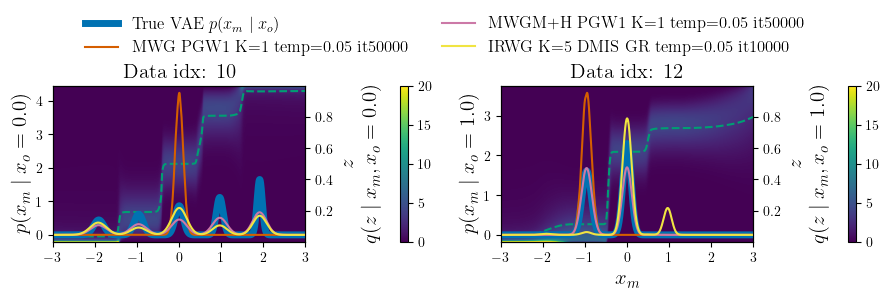

In [85]:
limits = (-3, 3)
bins = 5000

data_idxs = [10, 12]
plot_mog = False


plot_var_latent = True
plot_true_latent = False
assert not (plot_var_latent and plot_true_latent)
latent_pdf_plot_log = False
plot_latent_joint_vae = False
var_temperature=0.05

pdf_plot_log = False

plot_scatter = False
scatter_alpha = 0.1
vae_integration_kwargs={'latent_min':0., 
                        'latent_max':1.+1e-8, 
                        'latent_bins': 500}
latent_x_bins = 5000
vae_latent_pdf_kwargs={'latent_min':0.+1e-6, 
                        'latent_max':1.-1e-6, 
                        'latent_bins': 500}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = colors + ['r', 'm', 'w', 'g', 'k', 'c', 'y', 'tomato']
color_idx = 0

vae = VAE.load_from_checkpoint(vae_path)
vae = vae.eval()

fig, ax = plt.subplots(1, 2, figsize=(9, 3))
ax = ax.flatten()

divergences = {}
for d, data_idx in enumerate(data_idxs):
    color_idx = 0
    divergences[data_idx] = {}
    for i, (method, cfg) in enumerate(imputation_cfgs.items()):
        divergences[data_idx][method] = {}
        imputations = load_imputations_from_experiment(cfg['path'])

        X_imp = imputations['imputations'][data_idx]
        M = imputations['masks'][data_idx, 0]
        miss_idx = np.where(~M)[0][0]
        X_imp = X_imp[..., miss_idx]
        X_imp = rearrange(X_imp, 'k t -> (k t)')

        X_true = imputations['true_X'][data_idx, 0]
        obs_idx = np.where(M)[0][0]

        x = np.linspace(limits[0], limits[1], bins, dtype=np.float32)
        dx = (limits[1] - limits[0]) / bins
        
        # Plot MoG
        if i == 0 and plot_mog:
            mog_logpdf = mog_compute_conditional_logpdf(x, X_true, M, params)
            mog_logpdf = asnumpy(mog_logpdf)
            mog_pdf = np.exp(asnumpy)
            ax[d].plot(x, mog_logpdf if pdf_plot_log else mog_pdf ,linewidth=5., 
                              color=colors[color_idx], label='True MoG $p(x_m \mid x_o)$')
            color_idx += 1

        # Plot VAE
        if i == 0:
            vae_logpdf = vae_compute_conditional_logpdf(x, dx, X_true, M, vae, params, vae_integration_kwargs)
            vae_logpdf = asnumpy(vae_logpdf)
            vae_pdf = np.exp(vae_logpdf)
            ax[d].plot(x, vae_logpdf if pdf_plot_log else vae_pdf ,linewidth=5., 
                              color=colors[color_idx], label='True VAE $p(x_m \mid x_o)$')
            
            color_idx += 1
            
            max_height = vae_pdf.max()
            
        # Plot var latent
        if i == 0 and plot_var_latent:
            latent_x = np.linspace(limits[0], limits[1], latent_x_bins, dtype=np.float32)
            
            ax_twin = ax[d].twinx()
            
            encoder_z_exp_vals = vae_encoder_latent_posterior_expected_value_1d(latent_x, X_true, M, vae, temperature=var_temperature)
            ax_twin.plot(latent_x, encoder_z_exp_vals, color=colors[color_idx], linestyle='--')
            color_idx += 1
            
            q_logpdf = vae_encoder_latent_posterior_logpdf_1d(latent_x, M, X_true, vae, vae_latent_pdf_kwargs, temperature=var_temperature)
            q_logpdf = rearrange(asnumpy(q_logpdf), 'd z -> z d')
            q_pdf = np.exp(q_logpdf)
            if plot_latent_joint_vae:
                qp_logpdf = q_logpdf + vae_logpdf[None, :]
                qp_pdf = np.exp(qp_logpdf)
                qp_pdf = np.clip(qp_pdf, a_min=None, a_max=20)
                
                im = ax_twin.imshow(qp_logpdf if latent_pdf_plot_log else qp_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower')
            else:
                q_pdf = np.clip(q_pdf, a_min=None, a_max=20)
                im = ax_twin.imshow(q_logpdf if latent_pdf_plot_log else q_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower')
            fig.colorbar(im, ax=ax_twin, anchor=(2., 0.5))
            
            ax_twin.set_aspect('auto')
            ax_twin.set_zorder(ax[d].get_zorder() - 1)
            
            latent_plotting_pdf_label_prefix = ''
            if latent_pdf_plot_log:
                latent_plotting_pdf_label_prefix = '\log'
            if plot_latent_joint_vae:
                ax_twin.set_ylabel(f'$z$\r\n${latent_plotting_pdf_label_prefix} pq(x_m, z \mid x_o={X_true[obs_idx]})$', fontsize=15)
            else:
                ax_twin.set_ylabel(f'$z$\r\n${latent_plotting_pdf_label_prefix} q(z \mid x_m, x_o={X_true[obs_idx]})$', fontsize=15)
            ax[d].patch.set_alpha(0.)
            
        # Plot true latent
        if i == 0 and plot_true_latent:
            latent_x = np.linspace(limits[0], limits[1], latent_x_bins, dtype=np.float32)
            
            ax_twin = ax[d].twinx()
            
            true_z_exp_vals = vae_true_latent_posterior_expected_value_1d(latent_x, X_true, M, vae, vae_latent_pdf_kwargs)
            ax_twin.plot(latent_x, true_z_exp_vals, color=colors[color_idx], linestyle='--')
            color_idx += 1
            
            pz_logpdf = vae_true_latent_posterior_logpdf_1d(latent_x, X_true, M, vae, vae_latent_pdf_kwargs)
            pz_logpdf = rearrange(asnumpy(pz_logpdf), 'd z -> z d')
            pz_pdf = np.exp(pz_logpdf)
            if plot_latent_joint_vae:
                pzp_logpdf = pz_logpdf + vae_logpdf[None, :]
                pzp_pdf = np.exp(pzp_logpdf)
                pzp_pdf = np.clip(pzp_pdf, a_min=None, a_max=20)
                
                im = ax_twin.imshow(pzp_logpdf if latent_pdf_plot_log else pzp_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower')
            else:
                pz_pdf = np.clip(pz_pdf, a_min=None, a_max=20)
                im = ax_twin.imshow(pz_logpdf if latent_pdf_plot_log else pz_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower')
            fig.colorbar(im, ax=ax_twin, anchor=(2., 0.5))
            
            ax_twin.set_aspect('auto')
            ax_twin.set_zorder(ax[d].get_zorder() - 1)
            
            latent_plotting_pdf_label_prefix = ''
            if latent_pdf_plot_log:
                latent_plotting_pdf_label_prefix = '\log'
            if plot_latent_joint_vae:
                ax_twin.set_ylabel(f'$z$\r\n${latent_plotting_pdf_label_prefix} p(x_m, z \mid x_o={X_true[obs_idx]})$', fontsize=15)
            else:
                ax_twin.set_ylabel(f'$z$\r\n${latent_plotting_pdf_label_prefix} p(z \mid x_m, x_o={X_true[obs_idx]})$', fontsize=15)
            ax[d].patch.set_alpha(0.)

            
        # Plot KDE
        kde_imp = sstats.gaussian_kde(X_imp)
        logpdf = kde_imp.logpdf(x)
        pdf = np.exp(logpdf)
        ax[d].plot(x, logpdf if pdf_plot_log else pdf, color=colors[color_idx], label=method)
        
        if plot_scatter:
            scatter_height = max_height/20
            ax[d].scatter(X_imp, np.zeros(X_imp.shape[0])-(i+1)*scatter_height, 
                                 marker='.', alpha=scatter_alpha,
                                 color=colors[color_idx])
            
        color_idx += 1
        
        plotting_pdf_label_prefix = ''
        if pdf_plot_log:
            plotting_pdf_label_prefix = '\log'
        ax[d].set_ylabel(f'${plotting_pdf_label_prefix} p(x_m \mid x_o={X_true[obs_idx]})$', fontsize=15)
        
#         ax[d].set_title(f'Data idx: {data_idx}, observed value: {X_true}, observed dim: {obs_idx}', fontsize=15)
        ax[d].set_title(f'Data idx: {data_idx}', fontsize=15)
        
        
        # Compute KL divergences
        kl_fow, kl_rev, jsd = compute_divergences_between_logpds_arrays(vae_logpdf, logpdf, dx)
        divergences[data_idx][method]['kl_fow'] = kl_fow
        divergences[data_idx][method]['kl_rev'] = kl_rev
        divergences[data_idx][method]['jsd'] = jsd
    divergences[data_idx]['title'] = f'Data idx: {data_idx}, observed value: {X_true}, observed dim: {obs_idx}'

#     ax[data_idx].legend(fancybox=True, framealpha=0.4)
#     if plot_true_latent or plot_var_latent:
#         ax[data_idx].legend(bbox_to_anchor=(1.7, 1.00))
#     else:
#         ax[data_idx].legend(bbox_to_anchor=(1.01, 1.00))
#     ax[d].legend(loc='best')
    ax[d].set_xlim(limits[0], limits[1])
    
ax[d].set_xlabel('$x_m$', fontsize=15)
fig.subplots_adjust(wspace=10)

fig.tight_layout(rect=(0, 0, 1, 0.85))
ax[0].legend(ncol=2, 
          bbox_to_anchor=(0.5, 0.89), 
          bbox_transform=fig.transFigure, 
          loc='center',
          fontsize=12,
          frameon=False)

# fig.savefig('figures/2dgridmog4_temp005_somedataonly.pdf')

In [86]:
# fig.savefig('figures/2dgridmog4_temp005_somedataonly.pdf')

In [68]:
for data_idx, divs in divergences.items():
    print(divs['title'])
    divs = {m: d for (m, d) in divs.items() if m != 'title' }
    print(f'| {"Method":<35} | {"KL(p||q)":<11} | {"KL(q||p)":<11} | {"JSD(p||q)":<11} |')
    print('-'*60+'-'*16)
    smallest = {}
    for i, (method, metrics) in enumerate(divs.items()):
        for k, v in metrics.items():
            if i == 0 or smallest[k] > v:
                smallest[k] = v
                smallest[f'method_{k}'] = method
            
    for method, metrics in divs.items():
        klfow_star, klrev_star, jsd_star = '', '', ''
        if smallest['method_kl_fow'] == method:
            klfow_star = '*'
        if smallest['method_kl_rev'] == method:
            klrev_star = '*'
        if smallest['method_jsd'] == method:
            jsd_star = '*'
            
        print(f'| {method:<35} | {metrics["kl_fow"]:<8,.5f}{klfow_star:<3} | {metrics["kl_rev"]:<8,.5f}{klrev_star:<3} | {metrics["jsd"]:<8,.5f}{jsd_star:<3} |')
    print()

Data idx: 10, observed value: [ 0. nan], observed dim: 0
| Method                              | KL(p||q)    | KL(q||p)    | JSD(p||q)   |
----------------------------------------------------------------------------
| MWG PGW1 K=500 it100                | 0.37358     | 0.52578     | 0.09024 *   |
| MWGM+H PGW1 K=500 it100             | 0.38600     | 0.51633 *   | 0.09168     |
| IRWG K=500 DMIS GR it100            | 0.33346 *   | 0.95897     | 0.09674     |
| IRWG K=500 DMISG GLR5 it100         | 0.46395     | 0.54089     | 0.10045     |

Data idx: 12, observed value: [ 1. nan], observed dim: 0
| Method                              | KL(p||q)    | KL(q||p)    | JSD(p||q)   |
----------------------------------------------------------------------------
| MWG PGW1 K=500 it100                | 0.44500     | 2.89230     | 0.13950     |
| MWGM+H PGW1 K=500 it100             | 0.40439     | 2.54457     | 0.12759     |
| IRWG K=500 DMIS GR it100            | 0.02062 *   | 0.11444 *   | 0.00576

#### OOD conditionals 

In [32]:
vae_model_name = 'vae_comptrain'
checkpoint_name = 'last'
vae_path = (f'../logs/{dataset}/imputation/{vae_model_name}/seed_m20220118_d20220118/lightning_logs/'
            f'version_0/checkpoints/{checkpoint_name}.ckpt')

imp_path_template = (f'../logs/{dataset}/imputation/sampling/{vae_model_name}/'
                     '{}/seed_m20220118_d20220118/lightning_logs/')

method = 'IRWG K=5 DMIS GR it10000'
cfg = {
        'path': imp_path_template.format('irwg_k5_dmis_gr_mult_it10000')
    }

/tmp/ipykernel_416620/3397196256.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(params['comp_logits']),
/tmp/ipykernel_416620/3397196256.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(params['means']),
/tmp/ipykernel_416620/3397196256.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(params['covs']))


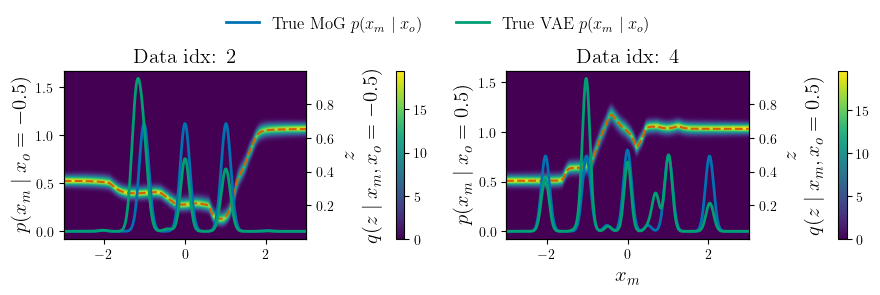

In [38]:
limits = (-3, 3)
bins = 5000

data_idxs = [2, 4]
plot_mog = True


plot_var_latent = True
plot_true_latent = False
assert not (plot_var_latent and plot_true_latent)
latent_pdf_plot_log = False
plot_latent_joint_vae = False
var_temperature=None

pdf_plot_log = False

plot_scatter = False
scatter_alpha = 0.1
vae_integration_kwargs={'latent_min':0., 
                        'latent_max':1.+1e-8, 
                        'latent_bins': 500}
latent_x_bins = 5000
vae_latent_pdf_kwargs={'latent_min':0.+1e-6, 
                        'latent_max':1.-1e-6, 
                        'latent_bins': 500}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = colors + ['r', 'm', 'w', 'g', 'k', 'c', 'y', 'tomato']
color_idx = 0

vae = VAE.load_from_checkpoint(vae_path)
vae = vae.eval()

fig, ax = plt.subplots(1, 2, figsize=(9, 3))
ax = ax.flatten()

divergences = {}
for d, data_idx in enumerate(data_idxs):
    i = 0
    color_idx = 0
    divergences[data_idx] = {}
    divergences[data_idx][method] = {}
    imputations = load_imputations_from_experiment(cfg['path'])

    X_imp = imputations['imputations'][data_idx]
    M = imputations['masks'][data_idx, 0]
    miss_idx = np.where(~M)[0][0]
    X_imp = X_imp[..., miss_idx]
    X_imp = rearrange(X_imp, 'k t -> (k t)')

    X_true = imputations['true_X'][data_idx, 0]
    obs_idx = np.where(M)[0][0]

    x = np.linspace(limits[0], limits[1], bins, dtype=np.float32)
    dx = (limits[1] - limits[0]) / bins

    # Plot MoG
    if i == 0 and plot_mog:
        mog_logpdf = mog_compute_conditional_logpdf(x, X_true, M, params)
        mog_logpdf = asnumpy(mog_logpdf)
        mog_pdf = np.exp(asnumpy(mog_logpdf))
        ax[d].plot(x, mog_logpdf if pdf_plot_log else mog_pdf ,linewidth=2., 
                          color=colors[color_idx], label='True MoG $p(x_m \mid x_o)$')
        color_idx += 1

    # Plot VAE
    if i == 0:
        vae_logpdf = vae_compute_conditional_logpdf(x, dx, X_true, M, vae, params, vae_integration_kwargs)
        vae_logpdf = asnumpy(vae_logpdf)
        vae_pdf = np.exp(vae_logpdf)
        ax[d].plot(x, vae_logpdf if pdf_plot_log else vae_pdf ,linewidth=2., 
                          color=colors[color_idx], label='True VAE $p(x_m \mid x_o)$')

        color_idx += 1

        max_height = vae_pdf.max()

    # Plot var latent
    if i == 0 and plot_var_latent:
        latent_x = np.linspace(limits[0], limits[1], latent_x_bins, dtype=np.float32)

        ax_twin = ax[d].twinx()

        encoder_z_exp_vals = vae_encoder_latent_posterior_expected_value_1d(latent_x, X_true, M, vae, temperature=var_temperature)
        ax_twin.plot(latent_x, encoder_z_exp_vals, color=colors[color_idx], linestyle='--')
        color_idx += 1

        q_logpdf = vae_encoder_latent_posterior_logpdf_1d(latent_x, M, X_true, vae, vae_latent_pdf_kwargs, temperature=var_temperature)
        q_logpdf = rearrange(asnumpy(q_logpdf), 'd z -> z d')
        q_pdf = np.exp(q_logpdf)
        if plot_latent_joint_vae:
            qp_logpdf = q_logpdf + vae_logpdf[None, :]
            qp_pdf = np.exp(qp_logpdf)
            im = ax_twin.imshow(qp_logpdf if latent_pdf_plot_log else qp_pdf, 
                           extent=(limits[0], limits[1], 
                                   vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                           origin='lower')
        else:
            im = ax_twin.imshow(q_logpdf if latent_pdf_plot_log else q_pdf, 
                           extent=(limits[0], limits[1], 
                                   vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                           origin='lower')
        fig.colorbar(im, ax=ax_twin, anchor=(2., 0.5))

        ax_twin.set_aspect('auto')
        ax_twin.set_zorder(ax[d].get_zorder() - 1)

        latent_plotting_pdf_label_prefix = ''
        if latent_pdf_plot_log:
            latent_plotting_pdf_label_prefix = '\log'
        if plot_latent_joint_vae:
            ax_twin.set_ylabel(f'$z$\r\n${latent_plotting_pdf_label_prefix} pq(x_m, z \mid x_o={X_true[obs_idx]})$', fontsize=15)
        else:
            ax_twin.set_ylabel(f'$z$\r\n${latent_plotting_pdf_label_prefix} q(z \mid x_m, x_o={X_true[obs_idx]})$', fontsize=15)
        ax[d].patch.set_alpha(0.)

    # Plot true latent
    if i == 0 and plot_true_latent:
        latent_x = np.linspace(limits[0], limits[1], latent_x_bins, dtype=np.float32)

        ax_twin = ax[d].twinx()

        true_z_exp_vals = vae_true_latent_posterior_expected_value_1d(latent_x, X_true, M, vae, vae_latent_pdf_kwargs)
        ax_twin.plot(latent_x, true_z_exp_vals, color=colors[color_idx], linestyle='--')
        color_idx += 1

        pz_logpdf = vae_true_latent_posterior_logpdf_1d(latent_x, X_true, M, vae, vae_latent_pdf_kwargs)
        pz_logpdf = rearrange(asnumpy(pz_logpdf), 'd z -> z d')
        pz_pdf = np.exp(pz_logpdf)
        if plot_latent_joint_vae:
            pzp_logpdf = pz_logpdf + vae_logpdf[None, :]
            pzp_pdf = np.exp(pzp_logpdf)

            im = ax_twin.imshow(pzp_logpdf if latent_pdf_plot_log else pzp_pdf, 
                           extent=(limits[0], limits[1], 
                                   vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                           origin='lower')
        else:
            im = ax_twin.imshow(pz_logpdf if latent_pdf_plot_log else pz_pdf, 
                           extent=(limits[0], limits[1], 
                                   vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                           origin='lower')
        fig.colorbar(im, ax=ax_twin, anchor=(2., 0.5))

        ax_twin.set_aspect('auto')
        ax_twin.set_zorder(ax[d].get_zorder() - 1)

        latent_plotting_pdf_label_prefix = ''
        if latent_pdf_plot_log:
            latent_plotting_pdf_label_prefix = '\log'
        if plot_latent_joint_vae:
            ax_twin.set_ylabel(f'$z$\r\n${latent_plotting_pdf_label_prefix} p(x_m, z \mid x_o={X_true[obs_idx]})$', fontsize=15)
        else:
            ax_twin.set_ylabel(f'$z$\r\n${latent_plotting_pdf_label_prefix} p(z \mid x_m, x_o={X_true[obs_idx]})$', fontsize=15)
        ax[d].patch.set_alpha(0.)


    # Plot KDE
#     kde_imp = sstats.gaussian_kde(X_imp)
#     logpdf = kde_imp.logpdf(x)
#     pdf = np.exp(logpdf)
#     ax[d].plot(x, logpdf if pdf_plot_log else pdf, color=colors[color_idx], label=method)

#     if plot_scatter:
#         scatter_height = max_height/20
#         ax[d].scatter(X_imp, np.zeros(X_imp.shape[0])-(i+1)*scatter_height, 
#                              marker='.', alpha=scatter_alpha,
#                              color=colors[color_idx])

#     color_idx += 1

    plotting_pdf_label_prefix = ''
    if pdf_plot_log:
        plotting_pdf_label_prefix = '\log'
    ax[d].set_ylabel(f'${plotting_pdf_label_prefix} p(x_m \mid x_o={X_true[obs_idx]})$', fontsize=15)

#         ax[d].set_title(f'Data idx: {data_idx}, observed value: {X_true}, observed dim: {obs_idx}', fontsize=15)
    ax[d].set_title(f'Data idx: {data_idx}', fontsize=15)

    ax[d].set_xlim(limits[0], limits[1])
    
ax[d].set_xlabel('$x_m$', fontsize=15)
fig.subplots_adjust(wspace=10)

fig.tight_layout(rect=(0, 0, 1, 0.89))
ax[0].legend(ncol=2, 
          bbox_to_anchor=(0.5, 0.92), 
          bbox_transform=fig.transFigure, 
          loc='center',
          fontsize=12,
          frameon=False)

# fig.savefig('figures/2dgridmog4_ood_conditionals.pdf')

#### All fail when OOD conditioning

In [11]:
vae_model_name = 'vae_comptrain'
checkpoint_name = 'last'
vae_path = (f'../logs/{dataset}/imputation/{vae_model_name}/seed_m20220118_d20220118/lightning_logs/'
            f'version_0/checkpoints/{checkpoint_name}.ckpt')

imp_path_template = (f'../logs/{dataset}/imputation/sampling/{vae_model_name}/'
                     '{}/seed_m20220118_d20220118/lightning_logs/')
imputation_cfgs = {
    'MWG PGW1 K=1 it50000': {
        'path': imp_path_template.format('mwg_k1_no_warmup_it50000')
    },
#     'MWGM PGW1 K=1 it50000': {
#         'path': imp_path_template.format('mwgm_k1_no_warmup_it50000')
#     },
    'MWGM+H PGW1 K=1 it50000': {
        'path': imp_path_template.format('mwgm_usehistinproposal_k1_no_warmup_it50000')
    },
#     'MWGM+H PGW1 K=1 it500000': {
#         'path': imp_path_template.format('mwgm_usehistinproposal_k1_no_warmup_it500000')
#     },
    'IRWG K=5 DMIS GR it10000': {
        'path': imp_path_template.format('irwg_k5_dmis_gr_mult_it10000')
    },
}

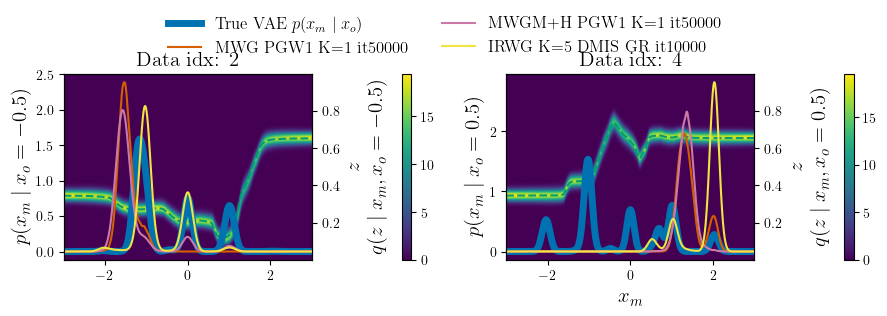

In [41]:
limits = (-3, 3)
bins = 5000

data_idxs = [2,4]
plot_mog = False


plot_var_latent = True
plot_true_latent = False
assert not (plot_var_latent and plot_true_latent)
latent_pdf_plot_log = False
plot_latent_joint_vae = False
var_temperature=None

pdf_plot_log = False

plot_scatter = False
scatter_alpha = 0.1
vae_integration_kwargs={'latent_min':0., 
                        'latent_max':1.+1e-8, 
                        'latent_bins': 500}
latent_x_bins = 5000
vae_latent_pdf_kwargs={'latent_min':0.+1e-6, 
                        'latent_max':1.-1e-6, 
                        'latent_bins': 500}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = colors + ['r', 'm', 'w', 'g', 'k', 'c', 'y', 'tomato']
color_idx = 0

vae = VAE.load_from_checkpoint(vae_path)
vae = vae.eval()

fig, ax = plt.subplots(1, 2, figsize=(9, 3))
ax = ax.flatten()

divergences = {}
for d, data_idx in enumerate(data_idxs):
    color_idx = 0
    divergences[data_idx] = {}
    for i, (method, cfg) in enumerate(imputation_cfgs.items()):
        divergences[data_idx][method] = {}
        imputations = load_imputations_from_experiment(cfg['path'])

        X_imp = imputations['imputations'][data_idx]
        M = imputations['masks'][data_idx, 0]
        miss_idx = np.where(~M)[0][0]
        X_imp = X_imp[..., miss_idx]
        X_imp = rearrange(X_imp, 'k t -> (k t)')

        X_true = imputations['true_X'][data_idx, 0]
        obs_idx = np.where(M)[0][0]

        x = np.linspace(limits[0], limits[1], bins, dtype=np.float32)
        dx = (limits[1] - limits[0]) / bins
        
        # Plot MoG
        if i == 0 and plot_mog:
            mog_logpdf = mog_compute_conditional_logpdf(x, X_true, M, params)
            mog_logpdf = asnumpy(mog_logpdf)
            mog_pdf = np.exp(asnumpy)
            ax[d].plot(x, mog_logpdf if pdf_plot_log else mog_pdf ,linewidth=5., 
                              color=colors[color_idx], label='True MoG $p(x_m \mid x_o)$')
            color_idx += 1

        # Plot VAE
        if i == 0:
            vae_logpdf = vae_compute_conditional_logpdf(x, dx, X_true, M, vae, params, vae_integration_kwargs)
            vae_logpdf = asnumpy(vae_logpdf)
            vae_pdf = np.exp(vae_logpdf)
            ax[d].plot(x, vae_logpdf if pdf_plot_log else vae_pdf ,linewidth=5., 
                              color=colors[color_idx], label='True VAE $p(x_m \mid x_o)$')
            
            color_idx += 1
            
            max_height = vae_pdf.max()
            
        # Plot var latent
        if i == 0 and plot_var_latent:
            latent_x = np.linspace(limits[0], limits[1], latent_x_bins, dtype=np.float32)
            
            ax_twin = ax[d].twinx()
            
            encoder_z_exp_vals = vae_encoder_latent_posterior_expected_value_1d(latent_x, X_true, M, vae, temperature=var_temperature)
            ax_twin.plot(latent_x, encoder_z_exp_vals, color=colors[color_idx], linestyle='--')
            color_idx += 1
            
            q_logpdf = vae_encoder_latent_posterior_logpdf_1d(latent_x, M, X_true, vae, vae_latent_pdf_kwargs, temperature=var_temperature)
            q_logpdf = rearrange(asnumpy(q_logpdf), 'd z -> z d')
            q_pdf = np.exp(q_logpdf)
            if plot_latent_joint_vae:
                qp_logpdf = q_logpdf + vae_logpdf[None, :]
                qp_pdf = np.exp(qp_logpdf)
                im = ax_twin.imshow(qp_logpdf if latent_pdf_plot_log else qp_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower')
            else:
                im = ax_twin.imshow(q_logpdf if latent_pdf_plot_log else q_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower')
            fig.colorbar(im, ax=ax_twin, anchor=(2., 0.5))
            
            ax_twin.set_aspect('auto')
            ax_twin.set_zorder(ax[d].get_zorder() - 1)
            
            latent_plotting_pdf_label_prefix = ''
            if latent_pdf_plot_log:
                latent_plotting_pdf_label_prefix = '\log'
            if plot_latent_joint_vae:
                ax_twin.set_ylabel(f'$z$\r\n${latent_plotting_pdf_label_prefix} pq(x_m, z \mid x_o={X_true[obs_idx]})$', fontsize=15)
            else:
                ax_twin.set_ylabel(f'$z$\r\n${latent_plotting_pdf_label_prefix} q(z \mid x_m, x_o={X_true[obs_idx]})$', fontsize=15)
            ax[d].patch.set_alpha(0.)
            
        # Plot true latent
        if i == 0 and plot_true_latent:
            latent_x = np.linspace(limits[0], limits[1], latent_x_bins, dtype=np.float32)
            
            ax_twin = ax[d].twinx()
            
            true_z_exp_vals = vae_true_latent_posterior_expected_value_1d(latent_x, X_true, M, vae, vae_latent_pdf_kwargs)
            ax_twin.plot(latent_x, true_z_exp_vals, color=colors[color_idx], linestyle='--')
            color_idx += 1
            
            pz_logpdf = vae_true_latent_posterior_logpdf_1d(latent_x, X_true, M, vae, vae_latent_pdf_kwargs)
            pz_logpdf = rearrange(asnumpy(pz_logpdf), 'd z -> z d')
            pz_pdf = np.exp(pz_logpdf)
            if plot_latent_joint_vae:
                pzp_logpdf = pz_logpdf + vae_logpdf[None, :]
                pzp_pdf = np.exp(pzp_logpdf)
                
                im = ax_twin.imshow(pzp_logpdf if latent_pdf_plot_log else pzp_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower')
            else:
                im = ax_twin.imshow(pz_logpdf if latent_pdf_plot_log else pz_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower')
            fig.colorbar(im, ax=ax_twin, anchor=(2., 0.5))
            
            ax_twin.set_aspect('auto')
            ax_twin.set_zorder(ax[d].get_zorder() - 1)
            
            latent_plotting_pdf_label_prefix = ''
            if latent_pdf_plot_log:
                latent_plotting_pdf_label_prefix = '\log'
            if plot_latent_joint_vae:
                ax_twin.set_ylabel(f'$z$\r\n${latent_plotting_pdf_label_prefix} p(x_m, z \mid x_o={X_true[obs_idx]})$', fontsize=15)
            else:
                ax_twin.set_ylabel(f'$z$\r\n${latent_plotting_pdf_label_prefix} p(z \mid x_m, x_o={X_true[obs_idx]})$', fontsize=15)
            ax[d].patch.set_alpha(0.)

            
        # Plot KDE
        kde_imp = sstats.gaussian_kde(X_imp)
        logpdf = kde_imp.logpdf(x)
        pdf = np.exp(logpdf)
        ax[d].plot(x, logpdf if pdf_plot_log else pdf, color=colors[color_idx], label=method)
        
        if plot_scatter:
            scatter_height = max_height/20
            ax[d].scatter(X_imp, np.zeros(X_imp.shape[0])-(i+1)*scatter_height, 
                                 marker='.', alpha=scatter_alpha,
                                 color=colors[color_idx])
            
        color_idx += 1
        
        plotting_pdf_label_prefix = ''
        if pdf_plot_log:
            plotting_pdf_label_prefix = '\log'
        ax[d].set_ylabel(f'${plotting_pdf_label_prefix} p(x_m \mid x_o={X_true[obs_idx]})$', fontsize=15)
        
#         ax[d].set_title(f'Data idx: {data_idx}, observed value: {X_true}, observed dim: {obs_idx}', fontsize=15)
        ax[d].set_title(f'Data idx: {data_idx}', fontsize=15)
        
        
        # Compute KL divergences
        kl_fow, kl_rev, jsd = compute_divergences_between_logpds_arrays(vae_logpdf, logpdf, dx)
        divergences[data_idx][method]['kl_fow'] = kl_fow
        divergences[data_idx][method]['kl_rev'] = kl_rev
        divergences[data_idx][method]['jsd'] = jsd
    divergences[data_idx]['title'] = f'Data idx: {data_idx}, observed value: {X_true}, observed dim: {obs_idx}'

#     ax[data_idx].legend(fancybox=True, framealpha=0.4)
#     if plot_true_latent or plot_var_latent:
#         ax[data_idx].legend(bbox_to_anchor=(1.7, 1.00))
#     else:
#         ax[data_idx].legend(bbox_to_anchor=(1.01, 1.00))
#     ax[d].legend(loc='best')
    ax[d].set_xlim(limits[0], limits[1])
    
ax[d].set_xlabel('$x_m$', fontsize=15)
fig.subplots_adjust(wspace=10)

fig.tight_layout(rect=(0, 0, 1, 0.95))
ax[0].legend(ncol=2, 
          bbox_to_anchor=(0.5, 0.95), 
          bbox_transform=fig.transFigure, 
          loc='center',
          fontsize=12,
          frameon=False)

# fig.savefig('figures/2dgridmog4_ood_all_fail.pdf')

In [42]:
for data_idx, divs in divergences.items():
    print(divs['title'])
    divs = {m: d for (m, d) in divs.items() if m != 'title' }
    print(f'| {"Method":<35} | {"KL(p||q)":<11} | {"KL(q||p)":<11} | {"JSD(p||q)":<11} |')
    print('-'*60+'-'*16)
    smallest = {}
    for i, (method, metrics) in enumerate(divs.items()):
        for k, v in metrics.items():
            if i == 0 or smallest[k] > v:
                smallest[k] = v
                smallest[f'method_{k}'] = method
            
    for method, metrics in divs.items():
        klfow_star, klrev_star, jsd_star = '', '', ''
        if smallest['method_kl_fow'] == method:
            klfow_star = '*'
        if smallest['method_kl_rev'] == method:
            klrev_star = '*'
        if smallest['method_jsd'] == method:
            jsd_star = '*'
            
        print(f'| {method:<35} | {metrics["kl_fow"]:<8,.5f}{klfow_star:<3} | {metrics["kl_rev"]:<8,.5f}{klrev_star:<3} | {metrics["jsd"]:<8,.5f}{jsd_star:<3} |')
    print()

Data idx: 2, observed value: [ nan -0.5], observed dim: 1
| Method                              | KL(p||q)    | KL(q||p)    | JSD(p||q)   |
----------------------------------------------------------------------------
| MWG PGW1 K=1 it50000                | 302.04931    | 3.66923     | 0.40864     |
| MWGM+H PGW1 K=1 it50000             | 1.43337     | 3.72592     | 0.34782     |
| IRWG K=5 DMIS GR it10000            | 0.47770 *   | 0.36053 *   | 0.09150 *   |

Data idx: 4, observed value: [nan 0.5], observed dim: 1
| Method                              | KL(p||q)    | KL(q||p)    | JSD(p||q)   |
----------------------------------------------------------------------------
| MWG PGW1 K=1 it50000                | 477.19338    | 5.41562     | 0.51330     |
| MWGM+H PGW1 K=1 it50000             | 1,256.51777    | 7.06380     | 0.56183     |
| IRWG K=5 DMIS GR it10000            | 4.35770 *   | 1.97189 *   | 0.41877 *   |



#### MWG pitfalls paper figure

In [14]:
vae_model_name = 'vae_comptrain'
checkpoint_name = 'last'
vae_path = (f'../logs/{dataset}/imputation/{vae_model_name}/seed_m20220118_d20220118/lightning_logs/'
            f'version_0/checkpoints/{checkpoint_name}.ckpt')

imp_path_template = (f'../logs/{dataset}/imputation/sampling/{vae_model_name}/'
                     '{}/seed_m20220118_d20220118/lightning_logs/')
imputation_cfgs = {
    'Pseudo-Gibbs': {
        'path': imp_path_template.format('pg_k1_no_warmup_it50000')
    },
#     'MWG PGW1 K=1 it50000': {
    'MWG': {
        'path': imp_path_template.format('mwg_k1_no_warmup_it50000')
    },
}

total_num_models_for_colors = 6

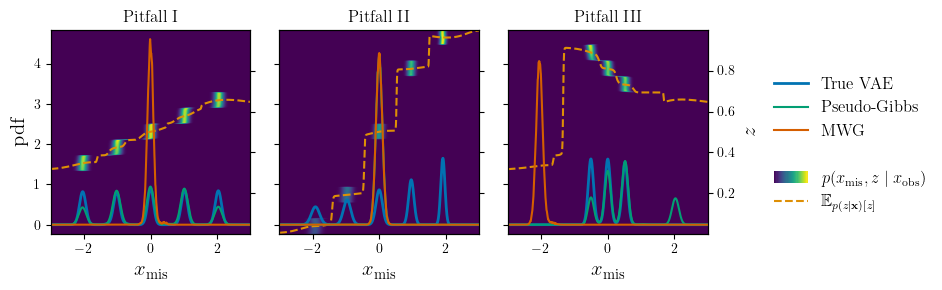

In [15]:
limits = (-3, 3)
bins = 5000

# data_idxs = [0, 1, 3, 5, 10, 12]
data_idxs = [3, 10, 5, ]
plot_mog = False

kde_bw_method = 0.05


plot_var_latent = False
plot_true_latent = True
assert not (plot_var_latent and plot_true_latent)
latent_pdf_plot_log = False
plot_latent_joint_vae = True
var_temperature=None

pdf_plot_log = False

plot_scatter = False
scatter_alpha = 0.1
vae_integration_kwargs={'latent_min':0., 
                        'latent_max':1.+1e-8, 
                        'latent_bins': 500}
latent_x_bins = 5000
vae_latent_pdf_kwargs={'latent_min':0.+1e-6, 
                        'latent_max':1.-1e-6, 
                        'latent_bins': 500}

# colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# colors = colors + ['r', 'm', 'w', 'g', 'k', 'c', 'y', 'tomato']
colors = sns.color_palette(palette='colorblind', n_colors=total_num_models_for_colors)

color_idx = 0

cm = plt.cm.viridis
# cm = sns.color_palette('mako', as_cmap=True)

# custom_imshow_vmax=50
custom_imshow_vmax=None

vae = VAE.load_from_checkpoint(vae_path)
vae = vae.eval()

# fig = plt.figure(figsize=(10,5), )#constrained_layout=True)

# gs = gridspec.GridSpec(ncols=3, nrows=2, wspace=.3, hspace=0.2)

# wgap_inner = 0.6
# gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0, 0], width_ratios=[20], wspace=wgap_inner)
# gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0, 1], width_ratios=[20], wspace=wgap_inner)
# gs3 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0, 2], width_ratios=[20], wspace=wgap_inner)
# gs4 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1, 0], width_ratios=[20], wspace=wgap_inner)
# gs5 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1, 1], width_ratios=[20], wspace=wgap_inner)
# gs6 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1, 2], width_ratios=[20], wspace=wgap_inner)

# axes = []
# caxes = []
# axes.append(fig.add_subplot(gs1[0, 0]))
# caxes.append(fig.add_subplot(gs1[0, 1]))
# axes.append(fig.add_subplot(gs2[0, 0]))
# caxes.append(fig.add_subplot(gs2[0, 1]))
# axes.append(fig.add_subplot(gs3[0, 0]))
# caxes.append(fig.add_subplot(gs3[0, 1]))
# axes.append(fig.add_subplot(gs4[0, 0]))
# caxes.append(fig.add_subplot(gs4[0, 1]))
# axes.append(fig.add_subplot(gs5[0, 0]))
# caxes.append(fig.add_subplot(gs5[0, 1]))
# axes.append(fig.add_subplot(gs6[0, 0]))
# caxes.append(fig.add_subplot(gs6[0, 1]))

fig, axes = plt.subplots(ncols=3, nrows=1, sharex=True, sharey=True, figsize=(9.5,3))
axes = axes.flatten()

divergences = {}
for d, data_idx in enumerate(data_idxs):
    color_idx = 0
    divergences[data_idx] = {}
    for i, (method, cfg) in enumerate(imputation_cfgs.items()):
        divergences[data_idx][method] = {}
        imputations = load_imputations_from_experiment(cfg['path'])

        X_imp = imputations['imputations'][data_idx]
        M = imputations['masks'][data_idx, 0]
        miss_idx = np.where(~M)[0][0]
        X_imp = X_imp[..., miss_idx]
        X_imp = rearrange(X_imp, 'k t -> (k t)')

        X_true = imputations['true_X'][data_idx, 0]
        obs_idx = np.where(M)[0][0]

        x = np.linspace(limits[0], limits[1], bins, dtype=np.float32)
        dx = (limits[1] - limits[0]) / bins
        
        # Plot MoG
        if i == 0 and plot_mog:
            mog_logpdf = mog_compute_conditional_logpdf(x, X_true, M, params)
            mog_logpdf = asnumpy(mog_logpdf)
            mog_pdf = np.exp(asnumpy)
            axes[d].plot(x, mog_logpdf if pdf_plot_log else mog_pdf ,linewidth=2., 
                              color=colors[color_idx], label='True MoG')# $p(x_m \mid x_o)$')
            color_idx += 1

        # Plot VAE
        if i == 0:
            vae_logpdf = vae_compute_conditional_logpdf(x, dx, X_true, M, vae, params, vae_integration_kwargs)
            vae_logpdf = asnumpy(vae_logpdf)
            vae_pdf = np.exp(vae_logpdf)
            axes[d].plot(x, vae_logpdf if pdf_plot_log else vae_pdf ,linewidth=2., 
                              color=colors[color_idx], label='True VAE')# $p(x_m \mid x_o)$')
            
            color_idx += 1
            
            max_height = vae_pdf.max()
            
        # Plot var latent
        if i == 0 and plot_var_latent:
            latent_x = np.linspace(limits[0], limits[1], latent_x_bins, dtype=np.float32)
            
            ax_twin = axes[d].twinx()
            
            encoder_z_exp_vals = vae_encoder_latent_posterior_expected_value_1d(latent_x, X_true, M, vae, temperature=var_temperature)
            ax_twin.plot(latent_x, encoder_z_exp_vals, color=colors[color_idx], linestyle='--', label='$\\mathbb{E}_{q(z \\mid \mathbf{x})\\left[z\\right]}$')
            color_idx += 1
            
            q_logpdf = vae_encoder_latent_posterior_logpdf_1d(latent_x, M, X_true, vae, vae_latent_pdf_kwargs, temperature=var_temperature)
            q_logpdf = rearrange(asnumpy(q_logpdf), 'd z -> z d')
            q_pdf = np.exp(q_logpdf)
            if plot_latent_joint_vae:
                qp_logpdf = q_logpdf + vae_logpdf[None, :]
                qp_pdf = np.exp(qp_logpdf)
                im = ax_twin.imshow(qp_logpdf if latent_pdf_plot_log else qp_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower',
                               cmap=cm,
                               vmax=custom_imshow_vmax)
            else:
                im = ax_twin.imshow(q_logpdf if latent_pdf_plot_log else q_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower',
                               cmap=cm,
                               vmax=custom_imshow_vmax)
#             fig.colorbar(im, cax=caxes[d],)# anchor=(2., 0.5))
#             latent_plotting_pdf_label_prefix = ''
#             if latent_pdf_plot_log:
#                 latent_plotting_pdf_label_prefix = '\log'
#             if plot_latent_joint_vae:
#                 caxes[d].set_ylabel(f'${latent_plotting_pdf_label_prefix} p(x_m, z \mid x_o={X_true[obs_idx]})$', fontsize=15)
#             else:
#                 caxes[d].set_ylabel(f'${latent_plotting_pdf_label_prefix} p(z \mid x_m, x_o={X_true[obs_idx]})$', fontsize=15)
            
            ax_twin.set_aspect('auto')
            ax_twin.set_zorder(axes[d].get_zorder() - 1)
            ax_twin.set_ylabel('$z$', fontsize=15)
            axes[d].patch.set_alpha(0.)
            
        # Plot true latent
        if i == 0 and plot_true_latent:
            latent_x = np.linspace(limits[0], limits[1], latent_x_bins, dtype=np.float32)
            
            ax_twin = axes[d].twinx()
            
            true_z_exp_vals = vae_true_latent_posterior_expected_value_1d(latent_x, X_true, M, vae, vae_latent_pdf_kwargs)
            ax_twin.plot(latent_x, true_z_exp_vals, color=colors[color_idx], linestyle='--', label='$\\mathbb{E}_{p(z \\mid \mathbf{x})\\left[z\\right]}$')
            color_idx += 1
            
            pz_logpdf = vae_true_latent_posterior_logpdf_1d(latent_x, X_true, M, vae, vae_latent_pdf_kwargs)
            pz_logpdf = rearrange(asnumpy(pz_logpdf), 'd z -> z d')
            pz_pdf = np.exp(pz_logpdf)
            if plot_latent_joint_vae:
                pzp_logpdf = pz_logpdf + vae_logpdf[None, :]
                pzp_pdf = np.exp(pzp_logpdf)
                
                im = ax_twin.imshow(pzp_logpdf if latent_pdf_plot_log else pzp_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower',
                               cmap=cm,
                               vmax=custom_imshow_vmax)
            else:
                im = ax_twin.imshow(pz_logpdf if latent_pdf_plot_log else pz_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower',
                               cmap=cm,
                               vmax=custom_imshow_vmax)
#             fig.colorbar(im, cax=caxes[d],)# anchor=(2., 0.5))
            
#             latent_plotting_pdf_label_prefix = ''
#             if latent_pdf_plot_log:
#                 latent_plotting_pdf_label_prefix = '\log'
#             if plot_latent_joint_vae:
#                 caxes[d].set_ylabel(f'${latent_plotting_pdf_label_prefix} p(x_m, z \mid x_o={X_true[obs_idx]})$', fontsize=15)
#             else:
#                 caxes[d].set_ylabel(f'${latent_plotting_pdf_label_prefix} p(z \mid x_m, x_o={X_true[obs_idx]})$', fontsize=15)
            
            ax_twin.set_aspect('auto')
            ax_twin.set_zorder(axes[d].get_zorder() - 1)
            ax_twin.set_ylabel('$z$', fontsize=15)
            axes[d].patch.set_alpha(0.)

            
        # Plot KDE
        kde_imp = sstats.gaussian_kde(X_imp, bw_method=kde_bw_method)
        logpdf = kde_imp.logpdf(x)
        pdf = np.exp(logpdf)
        axes[d].plot(x, logpdf if pdf_plot_log else pdf, color=colors[color_idx], label=method)
        
        if plot_scatter:
            scatter_height = max_height/20
            axes[d].scatter(X_imp, np.zeros(X_imp.shape[0])-(i+1)*scatter_height, 
                                 marker='.', alpha=scatter_alpha,
                                 color=colors[color_idx])
            
        color_idx += 1
        
        plotting_pdf_label_prefix = ''
        if pdf_plot_log:
            plotting_pdf_label_prefix = '\log'
#         axes[d].set_ylabel(f'${plotting_pdf_label_prefix} p(x_m \mid x_o={X_true[obs_idx]})$', fontsize=15)
        
#         axes[d].set_title(f'Data idx: {data_idx}, observed value: {X_true}, observed dim: {obs_idx}', fontsize=15)
#         axes[d].set_title(f'Data idx: {data_idx}', fontsize=15)
#         axes[d].set_title(f'$x_{obs_idx}\!=\!{X_true[obs_idx]}$', fontsize=15)
        if d == 0:
            axes[d].set_title(f'Pitfall I')
        elif d == 1:
            axes[d].set_title(f'Pitfall II')
        elif d == 2:
            axes[d].set_title(f'Pitfall III')
        
        
        # Compute KL divergences
        kl_fow, kl_rev, jsd = compute_divergences_between_logpds_arrays(vae_logpdf, logpdf, dx)
        divergences[data_idx][method]['kl_fow'] = kl_fow
        divergences[data_idx][method]['kl_rev'] = kl_rev
        divergences[data_idx][method]['jsd'] = jsd
    divergences[data_idx]['title'] = f'Data idx: {data_idx}, observed value: {X_true}, observed dim: {obs_idx}'

    axes[d].set_xlim(limits[0], limits[1])
    
#     if d > 2:
    axes[d].set_xlabel('$x_{\\text{mis}}$', fontsize=15)
    
    if d in (0,):
        axes[d].set_ylabel('pdf', fontsize=15)
    if d in (0, 1):
        ax_twin.set_yticklabels([])
        ax_twin.set_ylabel('')

        
fig.tight_layout(rect=(0, 0, 1, 0.95))

labels = []
handles = []

# Add lines from the figures
handles_ax, labels_ax = axes[1].get_legend_handles_labels()
labels.extend(labels_ax)
handles.extend(handles_ax)

# Add space in the legend
labels.append('')
handles.append(mpl.lines.Line2D([], [], color="none"))

# Add secondary axes legend items
labels.append('$p(x_{\\text{mis}}, z \mid x_{\\text{obs}})$')
countour_legend_rect = mpl.patches.Rectangle((0, 0), 1, 1)
handles.append(countour_legend_rect)

ax_twin_handles, ax_twin_labels = ax_twin.get_legend_handles_labels()
labels.extend(ax_twin_labels)
handles.extend(ax_twin_handles)

handler_map = {
    countour_legend_rect: HandlerColormap(cm, num_stripes=30)
}

# Place on top use with figsize=(8,3)
# fig.tight_layout(rect=(0, 0, 1, 0.95))
# axes[1].legend(handles, labels,
#                handler_map=handler_map,
#                ncol=5, 
#               bbox_to_anchor=(0.5, 0.95), 
#               bbox_transform=fig.transFigure, 
#               loc='center',
#               fontsize=12,
#               frameon=False)

# Place on the right use with figsize=(9.5,3)
fig.tight_layout(rect=(0, 0, 0.82, 1))
axes[1].legend(handles, labels,
               handler_map=handler_map,
               ncol=1, 
              bbox_to_anchor=(0.90, 0.5), 
              bbox_transform=fig.transFigure, 
              loc='center',
              fontsize=12,
              frameon=False)

# fig.savefig('figures/grid2dmog4_mwg_pitfalls.pdf')

In [320]:
for data_idx, divs in divergences.items():
    print(divs['title'])
    divs = {m: d for (m, d) in divs.items() if m != 'title' }
    print(f'| {"Method":<35} | {"KL(p||q)":<11} | {"KL(q||p)":<11} | {"JSD(p||q)":<11} |')
    print('-'*60+'-'*16)
    smallest = {}
    for i, (method, metrics) in enumerate(divs.items()):
        for k, v in metrics.items():
            if i == 0 or smallest[k] > v:
                smallest[k] = v
                smallest[f'method_{k}'] = method
            
    for method, metrics in divs.items():
        klfow_star, klrev_star, jsd_star = '', '', ''
        if smallest['method_kl_fow'] == method:
            klfow_star = '*'
        if smallest['method_kl_rev'] == method:
            klrev_star = '*'
        if smallest['method_jsd'] == method:
            jsd_star = '*'
            
        print(f'| {method:<35} | {metrics["kl_fow"]:<8,.5f}{klfow_star:<3} | {metrics["kl_rev"]:<8,.5f}{klrev_star:<3} | {metrics["jsd"]:<8,.5f}{jsd_star:<3} |')
    print()

Data idx: 3, observed value: [nan  0.], observed dim: 1
| Method                              | KL(p||q)    | KL(q||p)    | JSD(p||q)   |
----------------------------------------------------------------------------
| Pseudo-Gibbs                        | 0.08479 *   | 0.11712 *   | 0.02146 *   |
| MWG                                 | 20,138.89184    | 1.66725     | 0.42531     |

Data idx: 10, observed value: [ 0. nan], observed dim: 0
| Method                              | KL(p||q)    | KL(q||p)    | JSD(p||q)   |
----------------------------------------------------------------------------
| Pseudo-Gibbs                        | 22,606.56006    | 1.56963     | 0.41560     |
| MWG                                 | 22,076.84068*   | 1.56957 *   | 0.41559 *   |

Data idx: 5, observed value: [nan  1.], observed dim: 1
| Method                              | KL(p||q)    | KL(q||p)    | JSD(p||q)   |
----------------------------------------------------------------------------
| Pseudo-Gib

#### AC-MWG verification

In [50]:
vae_model_name = 'vae_comptrain'
checkpoint_name = 'last'
vae_path = (f'../logs/{dataset}/imputation/{vae_model_name}/seed_m20220118_d20220118/lightning_logs/'
            f'version_0/checkpoints/{checkpoint_name}.ckpt')

imp_path_template = (f'../logs/{dataset}/imputation/sampling/{vae_model_name}/'
                     '{}/seed_m20220118_d20220118/lightning_logs/')
imputation_cfgs = {
    'Pseudo-Gibbs': {
        'path': imp_path_template.format('pg_k1_no_warmup_it50000')
    },
#     'MWG PGW1 K=1 it50000': {
    'MWG': {
        'path': imp_path_template.format('mwg_k1_no_warmup_it50000')
    },
#     'MWGM+RH 001P PGW1 K=1 it50000': {
    'AC-MWG': {
        'path': imp_path_template.format('mwgm_userestricthist_001prior_k1_no_warmup_it50000')
    }
}

total_num_models_for_colors = 6

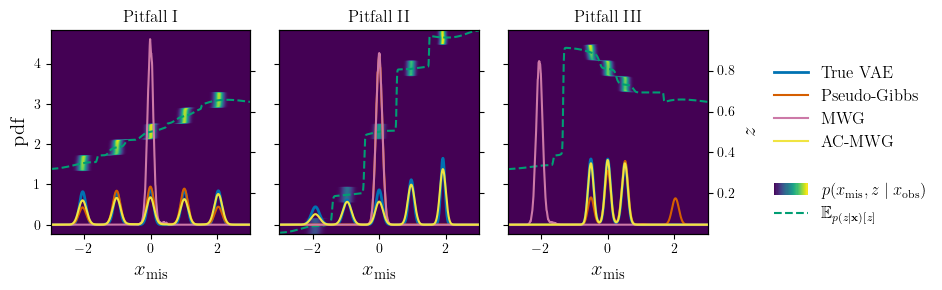

In [51]:
limits = (-3, 3)
bins = 5000

# data_idxs = [0, 1, 3, 5, 10, 12]
data_idxs = [3, 10, 5, ]
plot_mog = False

kde_bw_method = 0.05


plot_var_latent = False
plot_true_latent = True
assert not (plot_var_latent and plot_true_latent)
latent_pdf_plot_log = False
plot_latent_joint_vae = True
var_temperature=None

pdf_plot_log = False

plot_scatter = False
scatter_alpha = 0.1
vae_integration_kwargs={'latent_min':0., 
                        'latent_max':1.+1e-8, 
                        'latent_bins': 500}
latent_x_bins = 5000
vae_latent_pdf_kwargs={'latent_min':0.+1e-6, 
                        'latent_max':1.-1e-6, 
                        'latent_bins': 500}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = colors + ['r', 'm', 'w', 'g', 'k', 'c', 'y', 'tomato']
# colors = sns.color_palette(palette='colorblind', n_colors=total_num_models_for_colors)

color_idx = 0

cm = plt.cm.viridis
# cm = sns.color_palette('mako', as_cmap=True)

# custom_imshow_vmax=50
custom_imshow_vmax=None

vae = VAE.load_from_checkpoint(vae_path)
vae = vae.eval()

# fig = plt.figure(figsize=(10,5), )#constrained_layout=True)

# gs = gridspec.GridSpec(ncols=3, nrows=2, wspace=.3, hspace=0.2)

# wgap_inner = 0.6
# gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0, 0], width_ratios=[20], wspace=wgap_inner)
# gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0, 1], width_ratios=[20], wspace=wgap_inner)
# gs3 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0, 2], width_ratios=[20], wspace=wgap_inner)
# gs4 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1, 0], width_ratios=[20], wspace=wgap_inner)
# gs5 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1, 1], width_ratios=[20], wspace=wgap_inner)
# gs6 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1, 2], width_ratios=[20], wspace=wgap_inner)

# axes = []
# caxes = []
# axes.append(fig.add_subplot(gs1[0, 0]))
# caxes.append(fig.add_subplot(gs1[0, 1]))
# axes.append(fig.add_subplot(gs2[0, 0]))
# caxes.append(fig.add_subplot(gs2[0, 1]))
# axes.append(fig.add_subplot(gs3[0, 0]))
# caxes.append(fig.add_subplot(gs3[0, 1]))
# axes.append(fig.add_subplot(gs4[0, 0]))
# caxes.append(fig.add_subplot(gs4[0, 1]))
# axes.append(fig.add_subplot(gs5[0, 0]))
# caxes.append(fig.add_subplot(gs5[0, 1]))
# axes.append(fig.add_subplot(gs6[0, 0]))
# caxes.append(fig.add_subplot(gs6[0, 1]))

fig, axes = plt.subplots(ncols=3, nrows=1, sharex=True, sharey=True, figsize=(9.5,3))
axes = axes.flatten()

divergences = {}
for d, data_idx in enumerate(data_idxs):
    color_idx = 0
    divergences[data_idx] = {}
    for i, (method, cfg) in enumerate(imputation_cfgs.items()):
        divergences[data_idx][method] = {}
        imputations = load_imputations_from_experiment(cfg['path'])

        X_imp = imputations['imputations'][data_idx]
        M = imputations['masks'][data_idx, 0]
        miss_idx = np.where(~M)[0][0]
        X_imp = X_imp[..., miss_idx]
        X_imp = rearrange(X_imp, 'k t -> (k t)')

        X_true = imputations['true_X'][data_idx, 0]
        obs_idx = np.where(M)[0][0]

        x = np.linspace(limits[0], limits[1], bins, dtype=np.float32)
        dx = (limits[1] - limits[0]) / bins
        
        # Plot MoG
        if i == 0 and plot_mog:
            mog_logpdf = mog_compute_conditional_logpdf(x, X_true, M, params)
            mog_logpdf = asnumpy(mog_logpdf)
            mog_pdf = np.exp(asnumpy)
            axes[d].plot(x, mog_logpdf if pdf_plot_log else mog_pdf ,linewidth=2., 
                              color=colors[color_idx], label='True MoG')# $p(x_m \mid x_o)$')
            color_idx += 1

        # Plot VAE
        if i == 0:
            vae_logpdf = vae_compute_conditional_logpdf(x, dx, X_true, M, vae, params, vae_integration_kwargs)
            vae_logpdf = asnumpy(vae_logpdf)
            vae_pdf = np.exp(vae_logpdf)
            axes[d].plot(x, vae_logpdf if pdf_plot_log else vae_pdf ,linewidth=2., 
                              color=colors[color_idx], label='True VAE')# $p(x_m \mid x_o)$')
            
            color_idx += 1
            
            max_height = vae_pdf.max()
            
        # Plot var latent
        if i == 0 and plot_var_latent:
            latent_x = np.linspace(limits[0], limits[1], latent_x_bins, dtype=np.float32)
            
            ax_twin = axes[d].twinx()
            
            encoder_z_exp_vals = vae_encoder_latent_posterior_expected_value_1d(latent_x, X_true, M, vae, temperature=var_temperature)
            ax_twin.plot(latent_x, encoder_z_exp_vals, color=colors[color_idx], linestyle='--', label='$\\mathbb{E}_{q(z \\mid \mathbf{x})\\left[z\\right]}$')
            color_idx += 1
            
            q_logpdf = vae_encoder_latent_posterior_logpdf_1d(latent_x, M, X_true, vae, vae_latent_pdf_kwargs, temperature=var_temperature)
            q_logpdf = rearrange(asnumpy(q_logpdf), 'd z -> z d')
            q_pdf = np.exp(q_logpdf)
            if plot_latent_joint_vae:
                qp_logpdf = q_logpdf + vae_logpdf[None, :]
                qp_pdf = np.exp(qp_logpdf)
                im = ax_twin.imshow(qp_logpdf if latent_pdf_plot_log else qp_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower',
                               cmap=cm,
                               vmax=custom_imshow_vmax)
            else:
                im = ax_twin.imshow(q_logpdf if latent_pdf_plot_log else q_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower',
                               cmap=cm,
                               vmax=custom_imshow_vmax)
#             fig.colorbar(im, cax=caxes[d],)# anchor=(2., 0.5))
#             latent_plotting_pdf_label_prefix = ''
#             if latent_pdf_plot_log:
#                 latent_plotting_pdf_label_prefix = '\log'
#             if plot_latent_joint_vae:
#                 caxes[d].set_ylabel(f'${latent_plotting_pdf_label_prefix} p(x_m, z \mid x_o={X_true[obs_idx]})$', fontsize=15)
#             else:
#                 caxes[d].set_ylabel(f'${latent_plotting_pdf_label_prefix} p(z \mid x_m, x_o={X_true[obs_idx]})$', fontsize=15)
            
            ax_twin.set_aspect('auto')
            ax_twin.set_zorder(axes[d].get_zorder() - 1)
            ax_twin.set_ylabel('$z$', fontsize=15)
            axes[d].patch.set_alpha(0.)
            
        # Plot true latent
        if i == 0 and plot_true_latent:
            latent_x = np.linspace(limits[0], limits[1], latent_x_bins, dtype=np.float32)
            
            ax_twin = axes[d].twinx()
            
            true_z_exp_vals = vae_true_latent_posterior_expected_value_1d(latent_x, X_true, M, vae, vae_latent_pdf_kwargs)
            ax_twin.plot(latent_x, true_z_exp_vals, color=colors[color_idx], linestyle='--', label='$\\mathbb{E}_{p(z \\mid \mathbf{x})\\left[z\\right]}$')
            color_idx += 1
            
            pz_logpdf = vae_true_latent_posterior_logpdf_1d(latent_x, X_true, M, vae, vae_latent_pdf_kwargs)
            pz_logpdf = rearrange(asnumpy(pz_logpdf), 'd z -> z d')
            pz_pdf = np.exp(pz_logpdf)
            if plot_latent_joint_vae:
                pzp_logpdf = pz_logpdf + vae_logpdf[None, :]
                pzp_pdf = np.exp(pzp_logpdf)
                
                im = ax_twin.imshow(pzp_logpdf if latent_pdf_plot_log else pzp_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower',
                               cmap=cm,
                               vmax=custom_imshow_vmax)
            else:
                im = ax_twin.imshow(pz_logpdf if latent_pdf_plot_log else pz_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower',
                               cmap=cm,
                               vmax=custom_imshow_vmax)
#             fig.colorbar(im, cax=caxes[d],)# anchor=(2., 0.5))
            
#             latent_plotting_pdf_label_prefix = ''
#             if latent_pdf_plot_log:
#                 latent_plotting_pdf_label_prefix = '\log'
#             if plot_latent_joint_vae:
#                 caxes[d].set_ylabel(f'${latent_plotting_pdf_label_prefix} p(x_m, z \mid x_o={X_true[obs_idx]})$', fontsize=15)
#             else:
#                 caxes[d].set_ylabel(f'${latent_plotting_pdf_label_prefix} p(z \mid x_m, x_o={X_true[obs_idx]})$', fontsize=15)
            
            ax_twin.set_aspect('auto')
            ax_twin.set_zorder(axes[d].get_zorder() - 1)
            ax_twin.set_ylabel('$z$', fontsize=15)
            axes[d].patch.set_alpha(0.)

            
        # Plot KDE
        kde_imp = sstats.gaussian_kde(X_imp, bw_method=kde_bw_method)
        logpdf = kde_imp.logpdf(x)
        pdf = np.exp(logpdf)
        axes[d].plot(x, logpdf if pdf_plot_log else pdf, color=colors[color_idx], label=method)
        
        if plot_scatter:
            scatter_height = max_height/20
            axes[d].scatter(X_imp, np.zeros(X_imp.shape[0])-(i+1)*scatter_height, 
                                 marker='.', alpha=scatter_alpha,
                                 color=colors[color_idx])
            
        color_idx += 1
        
        plotting_pdf_label_prefix = ''
        if pdf_plot_log:
            plotting_pdf_label_prefix = '\log'
#         axes[d].set_ylabel(f'${plotting_pdf_label_prefix} p(x_m \mid x_o={X_true[obs_idx]})$', fontsize=15)
        
#         axes[d].set_title(f'Data idx: {data_idx}, observed value: {X_true}, observed dim: {obs_idx}', fontsize=15)
#         axes[d].set_title(f'Data idx: {data_idx}', fontsize=15)
#         axes[d].set_title(f'$x_{obs_idx}\!=\!{X_true[obs_idx]}$', fontsize=15)
        if d == 0:
            axes[d].set_title(f'Pitfall I')
        elif d == 1:
            axes[d].set_title(f'Pitfall II')
        elif d == 2:
            axes[d].set_title(f'Pitfall III')
        
        
        # Compute KL divergences
        kl_fow, kl_rev, jsd = compute_divergences_between_logpds_arrays(vae_logpdf, logpdf, dx)
        divergences[data_idx][method]['kl_fow'] = kl_fow
        divergences[data_idx][method]['kl_rev'] = kl_rev
        divergences[data_idx][method]['jsd'] = jsd
    divergences[data_idx]['title'] = f'Data idx: {data_idx}, observed value: {X_true}, observed dim: {obs_idx}'

    axes[d].set_xlim(limits[0], limits[1])
    
#     if d > 2:
    axes[d].set_xlabel('$x_{\\text{mis}}$', fontsize=15)
    
    if d in (0,):
        axes[d].set_ylabel('pdf', fontsize=15)
    if d in (0, 1):
        ax_twin.set_yticklabels([])
        ax_twin.set_ylabel('')

        
fig.tight_layout(rect=(0, 0, 1, 0.95))

labels = []
handles = []

# Add lines from the figures
handles_ax, labels_ax = axes[1].get_legend_handles_labels()
labels.extend(labels_ax)
handles.extend(handles_ax)

# Add space in the legend
labels.append('')
handles.append(mpl.lines.Line2D([], [], color="none"))

# Add secondary axes legend items
labels.append('$p(x_{\\text{mis}}, z \mid x_{\\text{obs}})$')
countour_legend_rect = mpl.patches.Rectangle((0, 0), 1, 1)
handles.append(countour_legend_rect)

ax_twin_handles, ax_twin_labels = ax_twin.get_legend_handles_labels()
labels.extend(ax_twin_labels)
handles.extend(ax_twin_handles)

handler_map = {
    countour_legend_rect: HandlerColormap(cm, num_stripes=30)
}

# Place on top use with figsize=(8,3)
# fig.tight_layout(rect=(0, 0, 1, 0.95))
# axes[1].legend(handles, labels,
#                handler_map=handler_map,
#                ncol=5, 
#               bbox_to_anchor=(0.5, 0.95), 
#               bbox_transform=fig.transFigure, 
#               loc='center',
#               fontsize=12,
#               frameon=False)

# Place on the right use with figsize=(9.5,3)
fig.tight_layout(rect=(0, 0, 0.82, 1))
axes[1].legend(handles, labels,
               handler_map=handler_map,
               ncol=1, 
              bbox_to_anchor=(0.90, 0.5), 
              bbox_transform=fig.transFigure, 
              loc='center',
              fontsize=12,
              frameon=False)

# fig.savefig('figures/grid2dmog4_ac_mwg.pdf')

In [329]:
for data_idx, divs in divergences.items():
    print(divs['title'])
    divs = {m: d for (m, d) in divs.items() if m != 'title' }
    print(f'| {"Method":<35} | {"KL(p||q)":<11} | {"KL(q||p)":<11} | {"JSD(p||q)":<11} |')
    print('-'*60+'-'*16)
    smallest = {}
    for i, (method, metrics) in enumerate(divs.items()):
        for k, v in metrics.items():
            if i == 0 or smallest[k] > v:
                smallest[k] = v
                smallest[f'method_{k}'] = method
            
    for method, metrics in divs.items():
        klfow_star, klrev_star, jsd_star = '', '', ''
        if smallest['method_kl_fow'] == method:
            klfow_star = '*'
        if smallest['method_kl_rev'] == method:
            klrev_star = '*'
        if smallest['method_jsd'] == method:
            jsd_star = '*'
            
        print(f'| {method:<35} | {metrics["kl_fow"]:<8,.5f}{klfow_star:<3} | {metrics["kl_rev"]:<8,.5f}{klrev_star:<3} | {metrics["jsd"]:<8,.5f}{jsd_star:<3} |')
    print()

Data idx: 3, observed value: [nan  0.], observed dim: 1
| Method                              | KL(p||q)    | KL(q||p)    | JSD(p||q)   |
----------------------------------------------------------------------------
| Pseudo-Gibbs                        | 0.08479     | 0.11712     | 0.02146     |
| MWG                                 | 20,138.89184    | 1.66725     | 0.42531     |
| AC-MWG                              | 0.05250 *   | 0.08614 *   | 0.01468 *   |

Data idx: 10, observed value: [ 0. nan], observed dim: 0
| Method                              | KL(p||q)    | KL(q||p)    | JSD(p||q)   |
----------------------------------------------------------------------------
| Pseudo-Gibbs                        | 22,606.56006    | 1.56963     | 0.41560     |
| MWG                                 | 22,076.84068    | 1.56957     | 0.41559     |
| AC-MWG                              | 0.07145 *   | 0.10129 *   | 0.01955 *   |

Data idx: 5, observed value: [nan  1.], observed dim: 1
| Metho

#### AC-MWG ablations

In [56]:
vae_model_name = 'vae_comptrain'
checkpoint_name = 'last'
vae_path = (f'../logs/{dataset}/imputation/{vae_model_name}/seed_m20220118_d20220118/lightning_logs/'
            f'version_0/checkpoints/{checkpoint_name}.ckpt')

imp_path_template = (f'../logs/{dataset}/imputation/sampling/{vae_model_name}/'
                     '{}/seed_m20220118_d20220118/lightning_logs/')
imputation_cfgs = {
#     'Pseudo-Gibbs': {
#         'path': imp_path_template.format('pg_k1_no_warmup_it50000')
#     },
# #     'MWG PGW1 K=1 it50000': {
#     'MWG': {
#         'path': imp_path_template.format('mwg_k1_no_warmup_it50000')
#     },
#     'MWGM+RH 001P PGW1 K=1 it50000': {
    'AC-MWG': {
        'path': imp_path_template.format('mwgm_userestricthist_001prior_k1_no_warmup_it50000')
    },
    'AC-MWG ($\epsilon=0$)': {
        'path': imp_path_template.format('ablation_mwgm_userestricthist_000prior_k1_no_warmup_it50000')
    },
    'AC-MWG\n(MWG target)': {
        'path': imp_path_template.format('ablation_mwgm_mwgtarget_userestricthist_001prior_k1_no_warmup_it50000')
    }
}

total_num_models_for_colors = 6

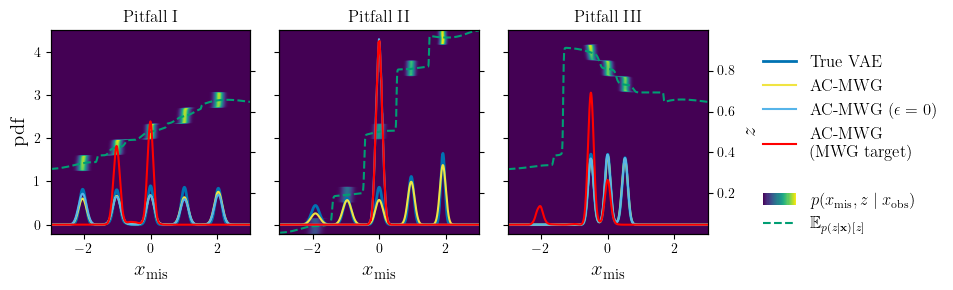

In [57]:
limits = (-3, 3)
bins = 5000

# data_idxs = [0, 1, 3, 5, 10, 12]
data_idxs = [3, 10, 5, ]
plot_mog = False

kde_bw_method = 0.05


plot_var_latent = False
plot_true_latent = True
assert not (plot_var_latent and plot_true_latent)
latent_pdf_plot_log = False
plot_latent_joint_vae = True
var_temperature=None

pdf_plot_log = False

plot_scatter = False
scatter_alpha = 0.1
vae_integration_kwargs={'latent_min':0., 
                        'latent_max':1.+1e-8, 
                        'latent_bins': 500}
latent_x_bins = 5000
vae_latent_pdf_kwargs={'latent_min':0.+1e-6, 
                        'latent_max':1.-1e-6, 
                        'latent_bins': 500}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = colors + ['r', 'm', 'w', 'g', 'k', 'c', 'y', 'tomato']
colors = colors[:2] + colors[4:]
# colors = sns.color_palette(palette='colorblind', n_colors=total_num_models_for_colors)

color_idx = 0

cm = plt.cm.viridis
# cm = sns.color_palette('mako', as_cmap=True)

# custom_imshow_vmax=50
custom_imshow_vmax=None

vae = VAE.load_from_checkpoint(vae_path)
vae = vae.eval()

# fig = plt.figure(figsize=(10,5), )#constrained_layout=True)

# gs = gridspec.GridSpec(ncols=3, nrows=2, wspace=.3, hspace=0.2)

# wgap_inner = 0.6
# gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0, 0], width_ratios=[20], wspace=wgap_inner)
# gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0, 1], width_ratios=[20], wspace=wgap_inner)
# gs3 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0, 2], width_ratios=[20], wspace=wgap_inner)
# gs4 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1, 0], width_ratios=[20], wspace=wgap_inner)
# gs5 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1, 1], width_ratios=[20], wspace=wgap_inner)
# gs6 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1, 2], width_ratios=[20], wspace=wgap_inner)

# axes = []
# caxes = []
# axes.append(fig.add_subplot(gs1[0, 0]))
# caxes.append(fig.add_subplot(gs1[0, 1]))
# axes.append(fig.add_subplot(gs2[0, 0]))
# caxes.append(fig.add_subplot(gs2[0, 1]))
# axes.append(fig.add_subplot(gs3[0, 0]))
# caxes.append(fig.add_subplot(gs3[0, 1]))
# axes.append(fig.add_subplot(gs4[0, 0]))
# caxes.append(fig.add_subplot(gs4[0, 1]))
# axes.append(fig.add_subplot(gs5[0, 0]))
# caxes.append(fig.add_subplot(gs5[0, 1]))
# axes.append(fig.add_subplot(gs6[0, 0]))
# caxes.append(fig.add_subplot(gs6[0, 1]))

fig, axes = plt.subplots(ncols=3, nrows=1, sharex=True, sharey=True, figsize=(9.5,3))
axes = axes.flatten()

divergences = {}
for d, data_idx in enumerate(data_idxs):
    color_idx = 0
    divergences[data_idx] = {}
    for i, (method, cfg) in enumerate(imputation_cfgs.items()):
        divergences[data_idx][method] = {}
        imputations = load_imputations_from_experiment(cfg['path'])

        X_imp = imputations['imputations'][data_idx]
        M = imputations['masks'][data_idx, 0]
        miss_idx = np.where(~M)[0][0]
        X_imp = X_imp[..., miss_idx]
        X_imp = rearrange(X_imp, 'k t -> (k t)')

        X_true = imputations['true_X'][data_idx, 0]
        obs_idx = np.where(M)[0][0]

        x = np.linspace(limits[0], limits[1], bins, dtype=np.float32)
        dx = (limits[1] - limits[0]) / bins
        
        # Plot MoG
        if i == 0 and plot_mog:
            mog_logpdf = mog_compute_conditional_logpdf(x, X_true, M, params)
            mog_logpdf = asnumpy(mog_logpdf)
            mog_pdf = np.exp(asnumpy)
            axes[d].plot(x, mog_logpdf if pdf_plot_log else mog_pdf ,linewidth=2., 
                              color=colors[color_idx], label='True MoG')# $p(x_m \mid x_o)$')
            color_idx += 1

        # Plot VAE
        if i == 0:
            vae_logpdf = vae_compute_conditional_logpdf(x, dx, X_true, M, vae, params, vae_integration_kwargs)
            vae_logpdf = asnumpy(vae_logpdf)
            vae_pdf = np.exp(vae_logpdf)
            axes[d].plot(x, vae_logpdf if pdf_plot_log else vae_pdf ,linewidth=2., 
                              color=colors[color_idx], label='True VAE')# $p(x_m \mid x_o)$')
            
            color_idx += 1
            
            max_height = vae_pdf.max()
            
        # Plot var latent
        if i == 0 and plot_var_latent:
            latent_x = np.linspace(limits[0], limits[1], latent_x_bins, dtype=np.float32)
            
            ax_twin = axes[d].twinx()
            
            encoder_z_exp_vals = vae_encoder_latent_posterior_expected_value_1d(latent_x, X_true, M, vae, temperature=var_temperature)
            ax_twin.plot(latent_x, encoder_z_exp_vals, color=colors[color_idx], linestyle='--', label='$\\mathbb{E}_{q(z \\mid \mathbf{x})\\left[z\\right]}$')
            color_idx += 1
            
            q_logpdf = vae_encoder_latent_posterior_logpdf_1d(latent_x, M, X_true, vae, vae_latent_pdf_kwargs, temperature=var_temperature)
            q_logpdf = rearrange(asnumpy(q_logpdf), 'd z -> z d')
            q_pdf = np.exp(q_logpdf)
            if plot_latent_joint_vae:
                qp_logpdf = q_logpdf + vae_logpdf[None, :]
                qp_pdf = np.exp(qp_logpdf)
                im = ax_twin.imshow(qp_logpdf if latent_pdf_plot_log else qp_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower',
                               cmap=cm,
                               vmax=custom_imshow_vmax)
            else:
                im = ax_twin.imshow(q_logpdf if latent_pdf_plot_log else q_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower',
                               cmap=cm,
                               vmax=custom_imshow_vmax)
#             fig.colorbar(im, cax=caxes[d],)# anchor=(2., 0.5))
#             latent_plotting_pdf_label_prefix = ''
#             if latent_pdf_plot_log:
#                 latent_plotting_pdf_label_prefix = '\log'
#             if plot_latent_joint_vae:
#                 caxes[d].set_ylabel(f'${latent_plotting_pdf_label_prefix} p(x_m, z \mid x_o={X_true[obs_idx]})$', fontsize=15)
#             else:
#                 caxes[d].set_ylabel(f'${latent_plotting_pdf_label_prefix} p(z \mid x_m, x_o={X_true[obs_idx]})$', fontsize=15)
            
            ax_twin.set_aspect('auto')
            ax_twin.set_zorder(axes[d].get_zorder() - 1)
            ax_twin.set_ylabel('$z$', fontsize=15)
            axes[d].patch.set_alpha(0.)
            
        # Plot true latent
        if i == 0 and plot_true_latent:
            latent_x = np.linspace(limits[0], limits[1], latent_x_bins, dtype=np.float32)
            
            ax_twin = axes[d].twinx()
            
            true_z_exp_vals = vae_true_latent_posterior_expected_value_1d(latent_x, X_true, M, vae, vae_latent_pdf_kwargs)
            ax_twin.plot(latent_x, true_z_exp_vals, color=colors[color_idx], linestyle='--', label='$\\mathbb{E}_{p(z \\mid \mathbf{x})\\left[z\\right]}$')
            color_idx += 1
            
            pz_logpdf = vae_true_latent_posterior_logpdf_1d(latent_x, X_true, M, vae, vae_latent_pdf_kwargs)
            pz_logpdf = rearrange(asnumpy(pz_logpdf), 'd z -> z d')
            pz_pdf = np.exp(pz_logpdf)
            if plot_latent_joint_vae:
                pzp_logpdf = pz_logpdf + vae_logpdf[None, :]
                pzp_pdf = np.exp(pzp_logpdf)
                
                im = ax_twin.imshow(pzp_logpdf if latent_pdf_plot_log else pzp_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower',
                               cmap=cm,
                               vmax=custom_imshow_vmax)
            else:
                im = ax_twin.imshow(pz_logpdf if latent_pdf_plot_log else pz_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower',
                               cmap=cm,
                               vmax=custom_imshow_vmax)
#             fig.colorbar(im, cax=caxes[d],)# anchor=(2., 0.5))
            
#             latent_plotting_pdf_label_prefix = ''
#             if latent_pdf_plot_log:
#                 latent_plotting_pdf_label_prefix = '\log'
#             if plot_latent_joint_vae:
#                 caxes[d].set_ylabel(f'${latent_plotting_pdf_label_prefix} p(x_m, z \mid x_o={X_true[obs_idx]})$', fontsize=15)
#             else:
#                 caxes[d].set_ylabel(f'${latent_plotting_pdf_label_prefix} p(z \mid x_m, x_o={X_true[obs_idx]})$', fontsize=15)
            
            ax_twin.set_aspect('auto')
            ax_twin.set_zorder(axes[d].get_zorder() - 1)
            ax_twin.set_ylabel('$z$', fontsize=15)
            axes[d].patch.set_alpha(0.)

            
        # Plot KDE
        kde_imp = sstats.gaussian_kde(X_imp, bw_method=kde_bw_method)
        logpdf = kde_imp.logpdf(x)
        pdf = np.exp(logpdf)
        axes[d].plot(x, logpdf if pdf_plot_log else pdf, color=colors[color_idx], label=method)
        
        if plot_scatter:
            scatter_height = max_height/20
            axes[d].scatter(X_imp, np.zeros(X_imp.shape[0])-(i+1)*scatter_height, 
                                 marker='.', alpha=scatter_alpha,
                                 color=colors[color_idx])
            
        color_idx += 1
        
        plotting_pdf_label_prefix = ''
        if pdf_plot_log:
            plotting_pdf_label_prefix = '\log'
#         axes[d].set_ylabel(f'${plotting_pdf_label_prefix} p(x_m \mid x_o={X_true[obs_idx]})$', fontsize=15)
        
#         axes[d].set_title(f'Data idx: {data_idx}, observed value: {X_true}, observed dim: {obs_idx}', fontsize=15)
#         axes[d].set_title(f'Data idx: {data_idx}', fontsize=15)
#         axes[d].set_title(f'$x_{obs_idx}\!=\!{X_true[obs_idx]}$', fontsize=15)
        if d == 0:
            axes[d].set_title(f'Pitfall I')
        elif d == 1:
            axes[d].set_title(f'Pitfall II')
        elif d == 2:
            axes[d].set_title(f'Pitfall III')
        
        
        # Compute KL divergences
        kl_fow, kl_rev, jsd = compute_divergences_between_logpds_arrays(vae_logpdf, logpdf, dx)
        divergences[data_idx][method]['kl_fow'] = kl_fow
        divergences[data_idx][method]['kl_rev'] = kl_rev
        divergences[data_idx][method]['jsd'] = jsd
    divergences[data_idx]['title'] = f'Data idx: {data_idx}, observed value: {X_true}, observed dim: {obs_idx}'

    axes[d].set_xlim(limits[0], limits[1])
    
#     if d > 2:
    axes[d].set_xlabel('$x_{\\text{mis}}$', fontsize=15)
    
    if d in (0,):
        axes[d].set_ylabel('pdf', fontsize=15)
    if d in (0, 1):
        ax_twin.set_yticklabels([])
        ax_twin.set_ylabel('')

        
fig.tight_layout(rect=(0, 0, 1, 0.95))

labels = []
handles = []

# Add lines from the figures
handles_ax, labels_ax = axes[1].get_legend_handles_labels()
labels.extend(labels_ax)
handles.extend(handles_ax)

# Add space in the legend
labels.append('')
handles.append(mpl.lines.Line2D([], [], color="none"))

# Add secondary axes legend items
labels.append('$p(x_{\\text{mis}}, z \mid x_{\\text{obs}})$')
countour_legend_rect = mpl.patches.Rectangle((0, 0), 1, 1)
handles.append(countour_legend_rect)

ax_twin_handles, ax_twin_labels = ax_twin.get_legend_handles_labels()
labels.extend(ax_twin_labels)
handles.extend(ax_twin_handles)

handler_map = {
    countour_legend_rect: HandlerColormap(cm, num_stripes=30)
}

# Place on top use with figsize=(8,3)
# fig.tight_layout(rect=(0, 0, 1, 0.95))
# axes[1].legend(handles, labels,
#                handler_map=handler_map,
#                ncol=5, 
#               bbox_to_anchor=(0.5, 0.95), 
#               bbox_transform=fig.transFigure, 
#               loc='center',
#               fontsize=12,
#               frameon=False)

# Place on the right use with figsize=(9.5,3)
fig.tight_layout(rect=(0, 0, 0.82, 1))
axes[1].legend(handles, labels,
               handler_map=handler_map,
               ncol=1, 
              bbox_to_anchor=(0.90, 0.5), 
              bbox_transform=fig.transFigure, 
              loc='center',
              fontsize=12,
              frameon=False)

# fig.savefig('figures/grid2dmog4_ac_mwg_ablations.pdf')

#### LAIR verification

In [20]:
vae_model_name = 'vae_comptrain'
checkpoint_name = 'last'
vae_path = (f'../logs/{dataset}/imputation/{vae_model_name}/seed_m20220118_d20220118/lightning_logs/'
            f'version_0/checkpoints/{checkpoint_name}.ckpt')

imp_path_template = (f'../logs/{dataset}/imputation/sampling/{vae_model_name}/'
                     '{}/seed_m20220118_d20220118/lightning_logs/')
imputation_cfgs = {
    'Pseudo-Gibbs': {
        'path': imp_path_template.format('pg_k1_no_warmup_it50000')
    },
#     'MWG PGW1 K=1 it50000': {
    'MWG': {
        'path': imp_path_template.format('mwg_k1_no_warmup_it50000')
    },
#     'MWGM+RH 001P PGW1 K=1 it50000': {
#     'AC-MWG': {
#         'path': imp_path_template.format('mwgm_userestricthist_001prior_k1_no_warmup_it50000')
#     }
    
# #     'IRWG K=5 DMIS GR it10000': {
#     'LAIR': {
#         'path': imp_path_template.format('irwg_k5_dmis_gr_mult_it10000')
#     },
#     'IRWG K=4 R=1 DMIS GR it10000': {
#     'LAIR': {
#         'path': imp_path_template.format('irwg_k4_dmis_gr_mult_it10000_replenish1')
#     },
#     'IRWG K=9 R=1 DMIS GR it5000': {
#     'LAIR': {
#         'path': imp_path_template.format('irwg_k9_dmis_gr_mult_it5000_replenish1')
#     },
#     'LAIR K4': {
#         'path': imp_path_template.format('irwg_k4_dmis_gr_mult_it10000_replenish1')
#     },
#     'LAIR K4 resampled': {
#         'path': imp_path_template.format('irwg_k4_dmis_gr_mult_it10000_replenish1_finalresample'),
#         'use_resampled_imps': True
#     },
#     'IRWG K=19 R=1 DMIS GR it2500': {
#     'LAIR': {
#         'path': imp_path_template.format('irwg_k19_dmis_gr_mult_it2500_replenish1')
#     },
#     'LAIR resampled': {
    'LAIR': {
        'path': imp_path_template.format('irwg_k19_dmis_gr_mult_it2500_replenish1_finalresample'),
        'use_resampled_imps': True
    },
    
}

total_num_models_for_colors = 6

KeyboardInterrupt: 

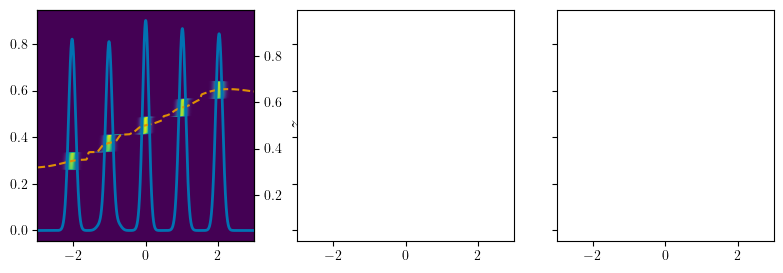

In [21]:
limits = (-3, 3)
bins = 5000

# data_idxs = [0, 1, 3, 5, 10, 12]
data_idxs = [3, 10, 5, ]
plot_mog = False

kde_bw_method = 0.05


plot_var_latent = False
plot_true_latent = True
assert not (plot_var_latent and plot_true_latent)
latent_pdf_plot_log = False
plot_latent_joint_vae = True
var_temperature=None

pdf_plot_log = False

plot_scatter = False
scatter_alpha = 0.1
vae_integration_kwargs={'latent_min':0., 
                        'latent_max':1.+1e-8, 
                        'latent_bins': 500}
latent_x_bins = 5000
vae_latent_pdf_kwargs={'latent_min':0.+1e-6, 
                        'latent_max':1.-1e-6, 
                        'latent_bins': 500}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = colors + ['r', 'm', 'w', 'g', 'k', 'c', 'y', 'tomato']
# colors = sns.color_palette(palette='colorblind', n_colors=total_num_models_for_colors)
color_idx = 0

cm = plt.cm.viridis
# cm = sns.color_palette('mako', as_cmap=True)

# custom_imshow_vmax=50
custom_imshow_vmax=None

vae = VAE.load_from_checkpoint(vae_path)
vae = vae.eval()

# fig = plt.figure(figsize=(10,5), )#constrained_layout=True)

# gs = gridspec.GridSpec(ncols=3, nrows=2, wspace=.3, hspace=0.2)

# wgap_inner = 0.6
# gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0, 0], width_ratios=[20], wspace=wgap_inner)
# gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0, 1], width_ratios=[20], wspace=wgap_inner)
# gs3 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0, 2], width_ratios=[20], wspace=wgap_inner)
# gs4 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1, 0], width_ratios=[20], wspace=wgap_inner)
# gs5 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1, 1], width_ratios=[20], wspace=wgap_inner)
# gs6 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1, 2], width_ratios=[20], wspace=wgap_inner)

# axes = []
# caxes = []
# axes.append(fig.add_subplot(gs1[0, 0]))
# caxes.append(fig.add_subplot(gs1[0, 1]))
# axes.append(fig.add_subplot(gs2[0, 0]))
# caxes.append(fig.add_subplot(gs2[0, 1]))
# axes.append(fig.add_subplot(gs3[0, 0]))
# caxes.append(fig.add_subplot(gs3[0, 1]))
# axes.append(fig.add_subplot(gs4[0, 0]))
# caxes.append(fig.add_subplot(gs4[0, 1]))
# axes.append(fig.add_subplot(gs5[0, 0]))
# caxes.append(fig.add_subplot(gs5[0, 1]))
# axes.append(fig.add_subplot(gs6[0, 0]))
# caxes.append(fig.add_subplot(gs6[0, 1]))

fig, axes = plt.subplots(ncols=3, nrows=1, sharex=True, sharey=True, figsize=(9.5,3))
axes = axes.flatten()

divergences = {}
for d, data_idx in enumerate(data_idxs):
    color_idx = 0
    divergences[data_idx] = {}
    for i, (method, cfg) in enumerate(imputation_cfgs.items()):
        divergences[data_idx][method] = {}
        imputations = load_imputations_from_experiment(cfg['path'])

        X_imp = imputations['imputations'][data_idx]
        M = imputations['masks'][data_idx, 0]
        miss_idx = np.where(~M)[0][0]
        X_imp = X_imp[..., miss_idx]
        X_imp = rearrange(X_imp, 'k t -> (k t)')

        X_true = imputations['true_X'][data_idx, 0]
        obs_idx = np.where(M)[0][0]

        x = np.linspace(limits[0], limits[1], bins, dtype=np.float32)
        dx = (limits[1] - limits[0]) / bins
        
        # Plot MoG
        if i == 0 and plot_mog:
            mog_logpdf = mog_compute_conditional_logpdf(x, X_true, M, params)
            mog_logpdf = asnumpy(mog_logpdf)
            mog_pdf = np.exp(asnumpy)
            axes[d].plot(x, mog_logpdf if pdf_plot_log else mog_pdf ,linewidth=2., 
                              color=colors[color_idx], label='True MoG')# $p(x_m \mid x_o)$')
            color_idx += 1

        # Plot VAE
        if i == 0:
            vae_logpdf = vae_compute_conditional_logpdf(x, dx, X_true, M, vae, params, vae_integration_kwargs)
            vae_logpdf = asnumpy(vae_logpdf)
            vae_pdf = np.exp(vae_logpdf)
            axes[d].plot(x, vae_logpdf if pdf_plot_log else vae_pdf ,linewidth=2., 
                              color=colors[color_idx], label='True VAE')# $p(x_m \mid x_o)$')
            
            color_idx += 1
            
            max_height = vae_pdf.max()
            
        # Plot var latent
        if i == 0 and plot_var_latent:
            latent_x = np.linspace(limits[0], limits[1], latent_x_bins, dtype=np.float32)
            
            ax_twin = axes[d].twinx()
            
            encoder_z_exp_vals = vae_encoder_latent_posterior_expected_value_1d(latent_x, X_true, M, vae, temperature=var_temperature)
            ax_twin.plot(latent_x, encoder_z_exp_vals, color=colors[color_idx], linestyle='--', label='$\\mathbb{E}_{q(z \\mid \mathbf{x})\\left[z\\right]}$')
            color_idx += 1
            
            q_logpdf = vae_encoder_latent_posterior_logpdf_1d(latent_x, M, X_true, vae, vae_latent_pdf_kwargs, temperature=var_temperature)
            q_logpdf = rearrange(asnumpy(q_logpdf), 'd z -> z d')
            q_pdf = np.exp(q_logpdf)
            if plot_latent_joint_vae:
                qp_logpdf = q_logpdf + vae_logpdf[None, :]
                qp_pdf = np.exp(qp_logpdf)
                im = ax_twin.imshow(qp_logpdf if latent_pdf_plot_log else qp_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower',
                               cmap=cm,
                               vmax=custom_imshow_vmax)
            else:
                im = ax_twin.imshow(q_logpdf if latent_pdf_plot_log else q_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower',
                               cmap=cm,
                               vmax=custom_imshow_vmax)
#             fig.colorbar(im, cax=caxes[d],)# anchor=(2., 0.5))
#             latent_plotting_pdf_label_prefix = ''
#             if latent_pdf_plot_log:
#                 latent_plotting_pdf_label_prefix = '\log'
#             if plot_latent_joint_vae:
#                 caxes[d].set_ylabel(f'${latent_plotting_pdf_label_prefix} p(x_m, z \mid x_o={X_true[obs_idx]})$', fontsize=15)
#             else:
#                 caxes[d].set_ylabel(f'${latent_plotting_pdf_label_prefix} p(z \mid x_m, x_o={X_true[obs_idx]})$', fontsize=15)
            
            ax_twin.set_aspect('auto')
            ax_twin.set_zorder(axes[d].get_zorder() - 1)
            ax_twin.set_ylabel('$z$', fontsize=15)
            axes[d].patch.set_alpha(0.)
            
        # Plot true latent
        if i == 0 and plot_true_latent:
            latent_x = np.linspace(limits[0], limits[1], latent_x_bins, dtype=np.float32)
            
            ax_twin = axes[d].twinx()
            
            true_z_exp_vals = vae_true_latent_posterior_expected_value_1d(latent_x, X_true, M, vae, vae_latent_pdf_kwargs)
            ax_twin.plot(latent_x, true_z_exp_vals, color=colors[color_idx], linestyle='--', label='$\\mathbb{E}_{p(z \\mid \mathbf{x})\\left[z\\right]}$')
            color_idx += 1
            
            pz_logpdf = vae_true_latent_posterior_logpdf_1d(latent_x, X_true, M, vae, vae_latent_pdf_kwargs)
            pz_logpdf = rearrange(asnumpy(pz_logpdf), 'd z -> z d')
            pz_pdf = np.exp(pz_logpdf)
            if plot_latent_joint_vae:
                pzp_logpdf = pz_logpdf + vae_logpdf[None, :]
                pzp_pdf = np.exp(pzp_logpdf)
                
                im = ax_twin.imshow(pzp_logpdf if latent_pdf_plot_log else pzp_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower',
                               cmap=cm,
                               vmax=custom_imshow_vmax)
            else:
                im = ax_twin.imshow(pz_logpdf if latent_pdf_plot_log else pz_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower',
                               cmap=cm,
                               vmax=custom_imshow_vmax)
#             fig.colorbar(im, cax=caxes[d],)# anchor=(2., 0.5))
            
#             latent_plotting_pdf_label_prefix = ''
#             if latent_pdf_plot_log:
#                 latent_plotting_pdf_label_prefix = '\log'
#             if plot_latent_joint_vae:
#                 caxes[d].set_ylabel(f'${latent_plotting_pdf_label_prefix} p(x_m, z \mid x_o={X_true[obs_idx]})$', fontsize=15)
#             else:
#                 caxes[d].set_ylabel(f'${latent_plotting_pdf_label_prefix} p(z \mid x_m, x_o={X_true[obs_idx]})$', fontsize=15)
            
            ax_twin.set_aspect('auto')
            ax_twin.set_zorder(axes[d].get_zorder() - 1)
            ax_twin.set_ylabel('$z$', fontsize=15)
            axes[d].patch.set_alpha(0.)

            
        # Plot KDE
        kde_imp = sstats.gaussian_kde(X_imp, bw_method=kde_bw_method)
        logpdf = kde_imp.logpdf(x)
        pdf = np.exp(logpdf)
        axes[d].plot(x, logpdf if pdf_plot_log else pdf, color=colors[color_idx], label=method)
        
        if plot_scatter:
            scatter_height = max_height/20
            axes[d].scatter(X_imp, np.zeros(X_imp.shape[0])-(i+1)*scatter_height, 
                                 marker='.', alpha=scatter_alpha,
                                 color=colors[color_idx])
            
        color_idx += 1
        
        plotting_pdf_label_prefix = ''
        if pdf_plot_log:
            plotting_pdf_label_prefix = '\log'
#         axes[d].set_ylabel(f'${plotting_pdf_label_prefix} p(x_m \mid x_o={X_true[obs_idx]})$', fontsize=15)
        
#         axes[d].set_title(f'Data idx: {data_idx}, observed value: {X_true}, observed dim: {obs_idx}', fontsize=15)
#         axes[d].set_title(f'Data idx: {data_idx}', fontsize=15)
#         axes[d].set_title(f'$x_{obs_idx}\!=\!{X_true[obs_idx]}$', fontsize=15)
        if d == 0:
            axes[d].set_title(f'Pitfall I')
        elif d == 1:
            axes[d].set_title(f'Pitfall II')
        elif d == 2:
            axes[d].set_title(f'Pitfall III')
        
        
        # Compute KL divergences
        kl_fow, kl_rev, jsd = compute_divergences_between_logpds_arrays(vae_logpdf, logpdf, dx)
        divergences[data_idx][method]['kl_fow'] = kl_fow
        divergences[data_idx][method]['kl_rev'] = kl_rev
        divergences[data_idx][method]['jsd'] = jsd
    divergences[data_idx]['title'] = f'Data idx: {data_idx}, observed value: {X_true}, observed dim: {obs_idx}'

    axes[d].set_xlim(limits[0], limits[1])
    
#     if d > 2:
    axes[d].set_xlabel('$x_{\\text{mis}}$', fontsize=15)
    
    if d in (0,):
        axes[d].set_ylabel('pdf', fontsize=15)
    if d in (0, 1):
        ax_twin.set_yticklabels([])
        ax_twin.set_ylabel('')

        
fig.tight_layout(rect=(0, 0, 1, 0.95))

labels = []
handles = []

# Add lines from the figures
handles_ax, labels_ax = axes[1].get_legend_handles_labels()
labels.extend(labels_ax)
handles.extend(handles_ax)

# Add space in the legend
labels.append('')
handles.append(mpl.lines.Line2D([], [], color="none"))

# Add secondary axes legend items
labels.append('$p(x_{\\text{mis}}, z \mid x_{\\text{obs}})$')
countour_legend_rect = mpl.patches.Rectangle((0, 0), 1, 1)
handles.append(countour_legend_rect)

ax_twin_handles, ax_twin_labels = ax_twin.get_legend_handles_labels()
labels.extend(ax_twin_labels)
handles.extend(ax_twin_handles)

handler_map = {
    countour_legend_rect: HandlerColormap(cm, num_stripes=30)
}

# Place on top use with figsize=(8,3)
# fig.tight_layout(rect=(0, 0, 1, 0.95))
# axes[1].legend(handles, labels,
#                handler_map=handler_map,
#                ncol=5, 
#               bbox_to_anchor=(0.5, 0.95), 
#               bbox_transform=fig.transFigure, 
#               loc='center',
#               fontsize=12,
#               frameon=False)

# Place on the right use with figsize=(9.5,3)
fig.tight_layout(rect=(0, 0, 0.82, 1))
axes[1].legend(handles, labels,
               handler_map=handler_map,
               ncol=1, 
              bbox_to_anchor=(0.90, 0.5), 
              bbox_transform=fig.transFigure, 
              loc='center',
              fontsize=12,
              frameon=False)

# fig.savefig('figures/grid2dmog4_lair.pdf')

In [355]:
for data_idx, divs in divergences.items():
    print(divs['title'])
    divs = {m: d for (m, d) in divs.items() if m != 'title' }
    print(f'| {"Method":<35} | {"KL(p||q)":<11} | {"KL(q||p)":<11} | {"JSD(p||q)":<11} |')
    print('-'*60+'-'*16)
    smallest = {}
    for i, (method, metrics) in enumerate(divs.items()):
        for k, v in metrics.items():
            if i == 0 or smallest[k] > v:
                smallest[k] = v
                smallest[f'method_{k}'] = method
            
    for method, metrics in divs.items():
        klfow_star, klrev_star, jsd_star = '', '', ''
        if smallest['method_kl_fow'] == method:
            klfow_star = '*'
        if smallest['method_kl_rev'] == method:
            klrev_star = '*'
        if smallest['method_jsd'] == method:
            jsd_star = '*'
            
        print(f'| {method:<35} | {metrics["kl_fow"]:<8,.5f}{klfow_star:<3} | {metrics["kl_rev"]:<8,.5f}{klrev_star:<3} | {metrics["jsd"]:<8,.5f}{jsd_star:<3} |')
    print()

Data idx: 3, observed value: [nan  0.], observed dim: 1
| Method                              | KL(p||q)    | KL(q||p)    | JSD(p||q)   |
----------------------------------------------------------------------------
| Pseudo-Gibbs                        | 0.08479     | 0.11712     | 0.02146     |
| MWG                                 | 20,138.89184    | 1.66725     | 0.42531     |
| LAIR K4                             | 0.04749     | 0.07612     | 0.01325     |
| LAIR K4 resampled                   | 0.04912     | 0.08044     | 0.01381     |
| LAIR                                | 0.04693     | 0.07309     | 0.01309     |
| LAIR resampled                      | 0.04644 *   | 0.07170 *   | 0.01296 *   |

Data idx: 10, observed value: [ 0. nan], observed dim: 0
| Method                              | KL(p||q)    | KL(q||p)    | JSD(p||q)   |
----------------------------------------------------------------------------
| Pseudo-Gibbs                        | 22,606.56006    | 1.56963     | 

#### LAIR ablations

In [47]:
vae_model_name = 'vae_comptrain'
checkpoint_name = 'last'
vae_path = (f'../logs/{dataset}/imputation/{vae_model_name}/seed_m20220118_d20220118/lightning_logs/'
            f'version_0/checkpoints/{checkpoint_name}.ckpt')

imp_path_template = (f'../logs/{dataset}/imputation/sampling/{vae_model_name}/'
                     '{}/seed_m20220118_d20220118/lightning_logs/')
imputation_cfgs = {
#     'Pseudo-Gibbs': {
#         'path': imp_path_template.format('pg_k1_no_warmup_it50000')
#     },
# #     'MWG PGW1 K=1 it50000': {
#     'MWG': {
#         'path': imp_path_template.format('mwg_k1_no_warmup_it50000')
#     },
#     'MWGM+RH 001P PGW1 K=1 it50000': {
#     'AC-MWG': {
#         'path': imp_path_template.format('mwgm_userestricthist_001prior_k1_no_warmup_it50000')
#     }
    
# #     'IRWG K=5 DMIS GR it10000': {
#     'LAIR': {
#         'path': imp_path_template.format('irwg_k5_dmis_gr_mult_it10000')
#     },
#     'IRWG K=4 R=1 DMIS GR it10000': {
#     'LAIR': {
#         'path': imp_path_template.format('irwg_k4_dmis_gr_mult_it10000_replenish1')
#     },
#     'IRWG K=9 R=1 DMIS GR it5000': {
#     'LAIR': {
#         'path': imp_path_template.format('irwg_k9_dmis_gr_mult_it5000_replenish1')
#     },
#     'LAIR K4': {
#         'path': imp_path_template.format('irwg_k4_dmis_gr_mult_it10000_replenish1')
#     },
#     'LAIR K4 resampled': {
#         'path': imp_path_template.format('irwg_k4_dmis_gr_mult_it10000_replenish1_finalresample'),
#         'use_resampled_imps': True
#     },
#     'IRWG K=19 R=1 DMIS GR it2500': {
#     'LAIR': {
#         'path': imp_path_template.format('irwg_k19_dmis_gr_mult_it2500_replenish1')
#     },
#     'LAIR resampled': {
    'LAIR': {
        'path': imp_path_template.format('irwg_k19_dmis_gr_mult_it2500_replenish1_finalresample'),
        'use_resampled_imps': True
    },
    'LAIR ($\epsilon=0.0$)': {
        'path': imp_path_template.format('ablation_irwg_k20_dmis_gr_mult_it2500_replenish0_finalresample'),
        'use_resampled_imps': True
    },
    'LAIR ($\epsilon=0.5$)': {
        'path': imp_path_template.format('ablation_irwg_k10_dmis_gr_mult_it2500_replenish10_finalresample'),
        'use_resampled_imps': True
    },
    'LAIR ($\epsilon=1.0$)': {
        'path': imp_path_template.format('ablation_standard_importance_resampling'),
    },
}

total_num_models_for_colors = 6

/home/vaidas/miniconda3/envs/irwg/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'generator_network' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['generator_network'])`.
  rank_zero_warn(
/home/vaidas/miniconda3/envs/irwg/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'var_latent_network' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['var_latent_network'])`.
  rank_zero_warn(


Multiple versions found in ../logs/toy_grid2dmog4/imputation/sampling/vae_comptrain/ablation_standard_importance_resampling/seed_m20220118_d20220118/lightning_logs/, loading version_3.
Multiple versions found in ../logs/toy_grid2dmog4/imputation/sampling/vae_comptrain/ablation_standard_importance_resampling/seed_m20220118_d20220118/lightning_logs/, loading version_3.
Multiple versions found in ../logs/toy_grid2dmog4/imputation/sampling/vae_comptrain/ablation_standard_importance_resampling/seed_m20220118_d20220118/lightning_logs/, loading version_3.


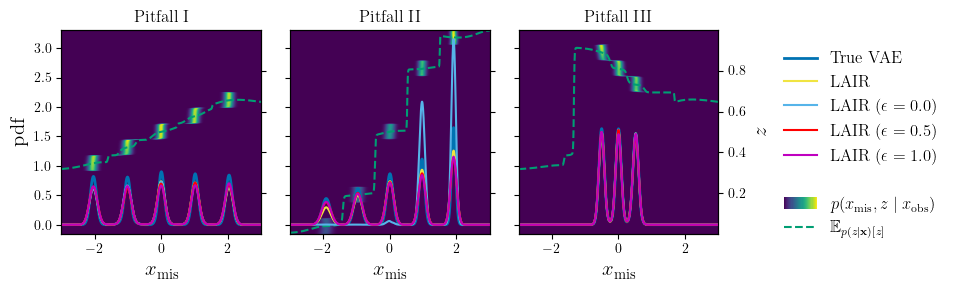

In [54]:
limits = (-3, 3)
bins = 5000

# data_idxs = [0, 1, 3, 5, 10, 12]
data_idxs = [3, 10, 5, ]
plot_mog = False

kde_bw_method = 0.05


plot_var_latent = False
plot_true_latent = True
assert not (plot_var_latent and plot_true_latent)
latent_pdf_plot_log = False
plot_latent_joint_vae = True
var_temperature=None

pdf_plot_log = False

plot_scatter = False
scatter_alpha = 0.1
vae_integration_kwargs={'latent_min':0., 
                        'latent_max':1.+1e-8, 
                        'latent_bins': 500}
latent_x_bins = 5000
vae_latent_pdf_kwargs={'latent_min':0.+1e-6, 
                        'latent_max':1.-1e-6, 
                        'latent_bins': 500}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = colors + ['r', 'm', 'w', 'g', 'k', 'c', 'y', 'tomato']
colors = colors[:2] + colors[4:]
# colors = sns.color_palette(palette='colorblind', n_colors=total_num_models_for_colors)
color_idx = 0

cm = plt.cm.viridis
# cm = sns.color_palette('mako', as_cmap=True)

# custom_imshow_vmax=50
custom_imshow_vmax=None

vae = VAE.load_from_checkpoint(vae_path)
vae = vae.eval()

# fig = plt.figure(figsize=(10,5), )#constrained_layout=True)

# gs = gridspec.GridSpec(ncols=3, nrows=2, wspace=.3, hspace=0.2)

# wgap_inner = 0.6
# gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0, 0], width_ratios=[20], wspace=wgap_inner)
# gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0, 1], width_ratios=[20], wspace=wgap_inner)
# gs3 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0, 2], width_ratios=[20], wspace=wgap_inner)
# gs4 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1, 0], width_ratios=[20], wspace=wgap_inner)
# gs5 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1, 1], width_ratios=[20], wspace=wgap_inner)
# gs6 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1, 2], width_ratios=[20], wspace=wgap_inner)

# axes = []
# caxes = []
# axes.append(fig.add_subplot(gs1[0, 0]))
# caxes.append(fig.add_subplot(gs1[0, 1]))
# axes.append(fig.add_subplot(gs2[0, 0]))
# caxes.append(fig.add_subplot(gs2[0, 1]))
# axes.append(fig.add_subplot(gs3[0, 0]))
# caxes.append(fig.add_subplot(gs3[0, 1]))
# axes.append(fig.add_subplot(gs4[0, 0]))
# caxes.append(fig.add_subplot(gs4[0, 1]))
# axes.append(fig.add_subplot(gs5[0, 0]))
# caxes.append(fig.add_subplot(gs5[0, 1]))
# axes.append(fig.add_subplot(gs6[0, 0]))
# caxes.append(fig.add_subplot(gs6[0, 1]))

fig, axes = plt.subplots(ncols=3, nrows=1, sharex=True, sharey=True, figsize=(9.5,3))
axes = axes.flatten()

divergences = {}
for d, data_idx in enumerate(data_idxs):
    color_idx = 0
    divergences[data_idx] = {}
    for i, (method, cfg) in enumerate(imputation_cfgs.items()):
        divergences[data_idx][method] = {}
        imputations = load_imputations_from_experiment(cfg['path'])

        X_imp = imputations['imputations'][data_idx]
        M = imputations['masks'][data_idx, 0]
        miss_idx = np.where(~M)[0][0]
        X_imp = X_imp[..., miss_idx]
        X_imp = rearrange(X_imp, 'k t -> (k t)')

        X_true = imputations['true_X'][data_idx, 0]
        obs_idx = np.where(M)[0][0]

        x = np.linspace(limits[0], limits[1], bins, dtype=np.float32)
        dx = (limits[1] - limits[0]) / bins
        
        # Plot MoG
        if i == 0 and plot_mog:
            mog_logpdf = mog_compute_conditional_logpdf(x, X_true, M, params)
            mog_logpdf = asnumpy(mog_logpdf)
            mog_pdf = np.exp(asnumpy)
            axes[d].plot(x, mog_logpdf if pdf_plot_log else mog_pdf ,linewidth=2., 
                              color=colors[color_idx], label='True MoG')# $p(x_m \mid x_o)$')
            color_idx += 1

        # Plot VAE
        if i == 0:
            vae_logpdf = vae_compute_conditional_logpdf(x, dx, X_true, M, vae, params, vae_integration_kwargs)
            vae_logpdf = asnumpy(vae_logpdf)
            vae_pdf = np.exp(vae_logpdf)
            axes[d].plot(x, vae_logpdf if pdf_plot_log else vae_pdf ,linewidth=2., 
                              color=colors[color_idx], label='True VAE')# $p(x_m \mid x_o)$')
            
            color_idx += 1
            
            max_height = vae_pdf.max()
            
        # Plot var latent
        if i == 0 and plot_var_latent:
            latent_x = np.linspace(limits[0], limits[1], latent_x_bins, dtype=np.float32)
            
            ax_twin = axes[d].twinx()
            
            encoder_z_exp_vals = vae_encoder_latent_posterior_expected_value_1d(latent_x, X_true, M, vae, temperature=var_temperature)
            ax_twin.plot(latent_x, encoder_z_exp_vals, color=colors[color_idx], linestyle='--', label='$\\mathbb{E}_{q(z \\mid \mathbf{x})\\left[z\\right]}$')
            color_idx += 1
            
            q_logpdf = vae_encoder_latent_posterior_logpdf_1d(latent_x, M, X_true, vae, vae_latent_pdf_kwargs, temperature=var_temperature)
            q_logpdf = rearrange(asnumpy(q_logpdf), 'd z -> z d')
            q_pdf = np.exp(q_logpdf)
            if plot_latent_joint_vae:
                qp_logpdf = q_logpdf + vae_logpdf[None, :]
                qp_pdf = np.exp(qp_logpdf)
                im = ax_twin.imshow(qp_logpdf if latent_pdf_plot_log else qp_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower',
                               cmap=cm,
                               vmax=custom_imshow_vmax)
            else:
                im = ax_twin.imshow(q_logpdf if latent_pdf_plot_log else q_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower',
                               cmap=cm,
                               vmax=custom_imshow_vmax)
#             fig.colorbar(im, cax=caxes[d],)# anchor=(2., 0.5))
#             latent_plotting_pdf_label_prefix = ''
#             if latent_pdf_plot_log:
#                 latent_plotting_pdf_label_prefix = '\log'
#             if plot_latent_joint_vae:
#                 caxes[d].set_ylabel(f'${latent_plotting_pdf_label_prefix} p(x_m, z \mid x_o={X_true[obs_idx]})$', fontsize=15)
#             else:
#                 caxes[d].set_ylabel(f'${latent_plotting_pdf_label_prefix} p(z \mid x_m, x_o={X_true[obs_idx]})$', fontsize=15)
            
            ax_twin.set_aspect('auto')
            ax_twin.set_zorder(axes[d].get_zorder() - 1)
            ax_twin.set_ylabel('$z$', fontsize=15)
            axes[d].patch.set_alpha(0.)
            
        # Plot true latent
        if i == 0 and plot_true_latent:
            latent_x = np.linspace(limits[0], limits[1], latent_x_bins, dtype=np.float32)
            
            ax_twin = axes[d].twinx()
            
            true_z_exp_vals = vae_true_latent_posterior_expected_value_1d(latent_x, X_true, M, vae, vae_latent_pdf_kwargs)
            ax_twin.plot(latent_x, true_z_exp_vals, color=colors[color_idx], linestyle='--', label='$\\mathbb{E}_{p(z \\mid \mathbf{x})\\left[z\\right]}$')
            color_idx += 1
            
            pz_logpdf = vae_true_latent_posterior_logpdf_1d(latent_x, X_true, M, vae, vae_latent_pdf_kwargs)
            pz_logpdf = rearrange(asnumpy(pz_logpdf), 'd z -> z d')
            pz_pdf = np.exp(pz_logpdf)
            if plot_latent_joint_vae:
                pzp_logpdf = pz_logpdf + vae_logpdf[None, :]
                pzp_pdf = np.exp(pzp_logpdf)
                
                im = ax_twin.imshow(pzp_logpdf if latent_pdf_plot_log else pzp_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower',
                               cmap=cm,
                               vmax=custom_imshow_vmax)
            else:
                im = ax_twin.imshow(pz_logpdf if latent_pdf_plot_log else pz_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower',
                               cmap=cm,
                               vmax=custom_imshow_vmax)
#             fig.colorbar(im, cax=caxes[d],)# anchor=(2., 0.5))
            
#             latent_plotting_pdf_label_prefix = ''
#             if latent_pdf_plot_log:
#                 latent_plotting_pdf_label_prefix = '\log'
#             if plot_latent_joint_vae:
#                 caxes[d].set_ylabel(f'${latent_plotting_pdf_label_prefix} p(x_m, z \mid x_o={X_true[obs_idx]})$', fontsize=15)
#             else:
#                 caxes[d].set_ylabel(f'${latent_plotting_pdf_label_prefix} p(z \mid x_m, x_o={X_true[obs_idx]})$', fontsize=15)
            
            ax_twin.set_aspect('auto')
            ax_twin.set_zorder(axes[d].get_zorder() - 1)
            ax_twin.set_ylabel('$z$', fontsize=15)
            axes[d].patch.set_alpha(0.)

            
        # Plot KDE
        kde_imp = sstats.gaussian_kde(X_imp, bw_method=kde_bw_method)
        logpdf = kde_imp.logpdf(x)
        pdf = np.exp(logpdf)
        axes[d].plot(x, logpdf if pdf_plot_log else pdf, color=colors[color_idx], label=method)
        
        if plot_scatter:
            scatter_height = max_height/20
            axes[d].scatter(X_imp, np.zeros(X_imp.shape[0])-(i+1)*scatter_height, 
                                 marker='.', alpha=scatter_alpha,
                                 color=colors[color_idx])
            
        color_idx += 1
        
        plotting_pdf_label_prefix = ''
        if pdf_plot_log:
            plotting_pdf_label_prefix = '\log'
#         axes[d].set_ylabel(f'${plotting_pdf_label_prefix} p(x_m \mid x_o={X_true[obs_idx]})$', fontsize=15)
        
#         axes[d].set_title(f'Data idx: {data_idx}, observed value: {X_true}, observed dim: {obs_idx}', fontsize=15)
#         axes[d].set_title(f'Data idx: {data_idx}', fontsize=15)
#         axes[d].set_title(f'$x_{obs_idx}\!=\!{X_true[obs_idx]}$', fontsize=15)
        if d == 0:
            axes[d].set_title(f'Pitfall I')
        elif d == 1:
            axes[d].set_title(f'Pitfall II')
        elif d == 2:
            axes[d].set_title(f'Pitfall III')
        
        
        # Compute KL divergences
        kl_fow, kl_rev, jsd = compute_divergences_between_logpds_arrays(vae_logpdf, logpdf, dx)
        divergences[data_idx][method]['kl_fow'] = kl_fow
        divergences[data_idx][method]['kl_rev'] = kl_rev
        divergences[data_idx][method]['jsd'] = jsd
    divergences[data_idx]['title'] = f'Data idx: {data_idx}, observed value: {X_true}, observed dim: {obs_idx}'

    axes[d].set_xlim(limits[0], limits[1])
    
#     if d > 2:
    axes[d].set_xlabel('$x_{\\text{mis}}$', fontsize=15)
    
    if d in (0,):
        axes[d].set_ylabel('pdf', fontsize=15)
    if d in (0, 1):
        ax_twin.set_yticklabels([])
        ax_twin.set_ylabel('')

        
fig.tight_layout(rect=(0, 0, 1, 0.95))

labels = []
handles = []

# Add lines from the figures
handles_ax, labels_ax = axes[1].get_legend_handles_labels()
labels.extend(labels_ax)
handles.extend(handles_ax)

# Add space in the legend
labels.append('')
handles.append(mpl.lines.Line2D([], [], color="none"))

# Add secondary axes legend items
labels.append('$p(x_{\\text{mis}}, z \mid x_{\\text{obs}})$')
countour_legend_rect = mpl.patches.Rectangle((0, 0), 1, 1)
handles.append(countour_legend_rect)

ax_twin_handles, ax_twin_labels = ax_twin.get_legend_handles_labels()
labels.extend(ax_twin_labels)
handles.extend(ax_twin_handles)

handler_map = {
    countour_legend_rect: HandlerColormap(cm, num_stripes=30)
}

# Place on top use with figsize=(8,3)
# fig.tight_layout(rect=(0, 0, 1, 0.95))
# axes[1].legend(handles, labels,
#                handler_map=handler_map,
#                ncol=5, 
#               bbox_to_anchor=(0.5, 0.95), 
#               bbox_transform=fig.transFigure, 
#               loc='center',
#               fontsize=12,
#               frameon=False)

# Place on the right use with figsize=(9.5,3)
fig.tight_layout(rect=(0, 0, 0.82, 1))
axes[1].legend(handles, labels,
               handler_map=handler_map,
               ncol=1, 
              bbox_to_anchor=(0.90, 0.5), 
              bbox_transform=fig.transFigure, 
              loc='center',
              fontsize=12,
              frameon=False)

# fig.savefig('figures/grid2dmog4_lair_ablations.pdf')

#### Website thumbnail

In [29]:
vae_model_name = 'vae_comptrain'
checkpoint_name = 'last'
vae_path = (f'../logs/{dataset}/imputation/{vae_model_name}/seed_m20220118_d20220118/lightning_logs/'
            f'version_0/checkpoints/{checkpoint_name}.ckpt')

imp_path_template = (f'../logs/{dataset}/imputation/sampling/{vae_model_name}/'
                     '{}/seed_m20220118_d20220118/lightning_logs/')
imputation_cfgs = {
    'Pseudo-Gibbs': {
        'path': imp_path_template.format('pg_k1_no_warmup_it50000')
    },
#     'MWG PGW1 K=1 it50000': {
    'MWG': {
        'path': imp_path_template.format('mwg_k1_no_warmup_it50000')
    },
#     'MWGM+RH 001P PGW1 K=1 it50000': {
    'AC-MWG': {
        'path': imp_path_template.format('mwgm_userestricthist_001prior_k1_no_warmup_it50000')
    },
    
# #     'IRWG K=5 DMIS GR it10000': {
#     'LAIR': {
#         'path': imp_path_template.format('irwg_k5_dmis_gr_mult_it10000')
#     },
#     'IRWG K=4 R=1 DMIS GR it10000': {
#     'LAIR': {
#         'path': imp_path_template.format('irwg_k4_dmis_gr_mult_it10000_replenish1')
#     },
#     'IRWG K=9 R=1 DMIS GR it5000': {
#     'LAIR': {
#         'path': imp_path_template.format('irwg_k9_dmis_gr_mult_it5000_replenish1')
#     },
#     'LAIR K4': {
#         'path': imp_path_template.format('irwg_k4_dmis_gr_mult_it10000_replenish1')
#     },
#     'LAIR K4 resampled': {
#         'path': imp_path_template.format('irwg_k4_dmis_gr_mult_it10000_replenish1_finalresample'),
#         'use_resampled_imps': True
#     },
#     'IRWG K=19 R=1 DMIS GR it2500': {
#     'LAIR': {
#         'path': imp_path_template.format('irwg_k19_dmis_gr_mult_it2500_replenish1')
#     },
#     'LAIR resampled': {
    'LAIR': {
        'path': imp_path_template.format('irwg_k19_dmis_gr_mult_it2500_replenish1_finalresample'),
        'use_resampled_imps': True
    },
    
}

total_num_models_for_colors = 5

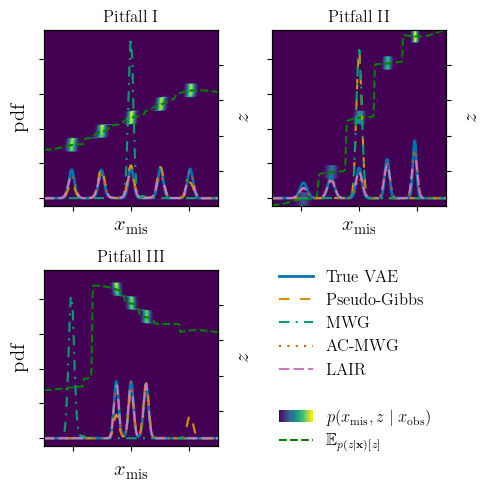

In [30]:
limits = (-3, 3)
bins = 5000

# data_idxs = [0, 1, 3, 5, 10, 12]
data_idxs = [3, 10, 5, ]
plot_mog = False

kde_bw_method = 0.05

# dashes = [
#     (None, None),
#     [5,5],
#     [5,3,1,3],
#     [1,3],
#     [5,2,5,2,5,10],
#     [5,3,1,2,1,10]
# ]

dashes = [(None, None) for _ in range(6)]

plot_var_latent = False
plot_true_latent = True
assert not (plot_var_latent and plot_true_latent)
latent_pdf_plot_log = False
plot_latent_joint_vae = True
var_temperature=None

pdf_plot_log = False

plot_scatter = False
scatter_alpha = 0.1
vae_integration_kwargs={'latent_min':0., 
                        'latent_max':1.+1e-8, 
                        'latent_bins': 500}
latent_x_bins = 5000
vae_latent_pdf_kwargs={'latent_min':0.+1e-6, 
                        'latent_max':1.-1e-6, 
                        'latent_bins': 500}

# colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# colors = colors + ['r', 'm', 'w', 'g', 'k', 'c', 'y', 'tomato']
colors = sns.color_palette(palette='colorblind', n_colors=total_num_models_for_colors)
color_idx = 0

cm = plt.cm.viridis
# cm = sns.color_palette('mako', as_cmap=True)

# custom_imshow_vmax=50
custom_imshow_vmax=None

vae = VAE.load_from_checkpoint(vae_path)
vae = vae.eval()

# fig = plt.figure(figsize=(10,5), )#constrained_layout=True)

# gs = gridspec.GridSpec(ncols=3, nrows=2, wspace=.3, hspace=0.2)

# wgap_inner = 0.6
# gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0, 0], width_ratios=[20], wspace=wgap_inner)
# gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0, 1], width_ratios=[20], wspace=wgap_inner)
# gs3 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0, 2], width_ratios=[20], wspace=wgap_inner)
# gs4 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1, 0], width_ratios=[20], wspace=wgap_inner)
# gs5 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1, 1], width_ratios=[20], wspace=wgap_inner)
# gs6 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1, 2], width_ratios=[20], wspace=wgap_inner)

# axes = []
# caxes = []
# axes.append(fig.add_subplot(gs1[0, 0]))
# caxes.append(fig.add_subplot(gs1[0, 1]))
# axes.append(fig.add_subplot(gs2[0, 0]))
# caxes.append(fig.add_subplot(gs2[0, 1]))
# axes.append(fig.add_subplot(gs3[0, 0]))
# caxes.append(fig.add_subplot(gs3[0, 1]))
# axes.append(fig.add_subplot(gs4[0, 0]))
# caxes.append(fig.add_subplot(gs4[0, 1]))
# axes.append(fig.add_subplot(gs5[0, 0]))
# caxes.append(fig.add_subplot(gs5[0, 1]))
# axes.append(fig.add_subplot(gs6[0, 0]))
# caxes.append(fig.add_subplot(gs6[0, 1]))

fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, figsize=(5,5))
axes = axes.flatten()

divergences = {}
for d, data_idx in enumerate(data_idxs):
    color_idx = 0
    divergences[data_idx] = {}
    for i, (method, cfg) in enumerate(imputation_cfgs.items()):
        divergences[data_idx][method] = {}
        imputations = load_imputations_from_experiment(cfg['path'])

        X_imp = imputations['imputations'][data_idx]
        M = imputations['masks'][data_idx, 0]
        miss_idx = np.where(~M)[0][0]
        X_imp = X_imp[..., miss_idx]
        X_imp = rearrange(X_imp, 'k t -> (k t)')

        X_true = imputations['true_X'][data_idx, 0]
        obs_idx = np.where(M)[0][0]

        x = np.linspace(limits[0], limits[1], bins, dtype=np.float32)
        dx = (limits[1] - limits[0]) / bins
        
        # Plot MoG
        if i == 0 and plot_mog:
            mog_logpdf = mog_compute_conditional_logpdf(x, X_true, M, params)
            mog_logpdf = asnumpy(mog_logpdf)
            mog_pdf = np.exp(asnumpy)
            axes[d].plot(x, mog_logpdf if pdf_plot_log else mog_pdf ,linewidth=2., dashes=dashes[color_idx],
                              color=colors[color_idx], label='True MoG')# $p(x_m \mid x_o)$')
            color_idx += 1

        # Plot VAE
        if i == 0:
            vae_logpdf = vae_compute_conditional_logpdf(x, dx, X_true, M, vae, params, vae_integration_kwargs)
            vae_logpdf = asnumpy(vae_logpdf)
            vae_pdf = np.exp(vae_logpdf)
            axes[d].plot(x, vae_logpdf if pdf_plot_log else vae_pdf ,linewidth=2., dashes=dashes[color_idx],
                              color=colors[color_idx], label='True VAE')# $p(x_m \mid x_o)$')
            
            color_idx += 1
            
            max_height = vae_pdf.max()
            
        # Plot var latent
        if i == 0 and plot_var_latent:
            latent_x = np.linspace(limits[0], limits[1], latent_x_bins, dtype=np.float32)
            
            ax_twin = axes[d].twinx()
            
            encoder_z_exp_vals = vae_encoder_latent_posterior_expected_value_1d(latent_x, X_true, M, vae, temperature=var_temperature)
            col = 'g'
            ax_twin.plot(latent_x, encoder_z_exp_vals, color=col, linestyle='--', label='$\\mathbb{E}_{q(z \\mid \mathbf{x})\\left[z\\right]}$')
#             color_idx += 1
            
            q_logpdf = vae_encoder_latent_posterior_logpdf_1d(latent_x, M, X_true, vae, vae_latent_pdf_kwargs, temperature=var_temperature)
            q_logpdf = rearrange(asnumpy(q_logpdf), 'd z -> z d')
            q_pdf = np.exp(q_logpdf)
            if plot_latent_joint_vae:
                qp_logpdf = q_logpdf + vae_logpdf[None, :]
                qp_pdf = np.exp(qp_logpdf)
                im = ax_twin.imshow(qp_logpdf if latent_pdf_plot_log else qp_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower',
                               cmap=cm,
                               vmax=custom_imshow_vmax)
            else:
                im = ax_twin.imshow(q_logpdf if latent_pdf_plot_log else q_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower',
                               cmap=cm,
                               vmax=custom_imshow_vmax)
#             fig.colorbar(im, cax=caxes[d],)# anchor=(2., 0.5))
#             latent_plotting_pdf_label_prefix = ''
#             if latent_pdf_plot_log:
#                 latent_plotting_pdf_label_prefix = '\log'
#             if plot_latent_joint_vae:
#                 caxes[d].set_ylabel(f'${latent_plotting_pdf_label_prefix} p(x_m, z \mid x_o={X_true[obs_idx]})$', fontsize=15)
#             else:
#                 caxes[d].set_ylabel(f'${latent_plotting_pdf_label_prefix} p(z \mid x_m, x_o={X_true[obs_idx]})$', fontsize=15)
            
            ax_twin.set_aspect('auto')
            ax_twin.set_zorder(axes[d].get_zorder() - 1)
            ax_twin.set_ylabel('$z$', fontsize=15)
            axes[d].patch.set_alpha(0.)
            
        # Plot true latent
        if i == 0 and plot_true_latent:
            latent_x = np.linspace(limits[0], limits[1], latent_x_bins, dtype=np.float32)
            
            ax_twin = axes[d].twinx()
            
            true_z_exp_vals = vae_true_latent_posterior_expected_value_1d(latent_x, X_true, M, vae, vae_latent_pdf_kwargs)
            col = 'g'
            ax_twin.plot(latent_x, true_z_exp_vals, color=col, linestyle='--', label='$\\mathbb{E}_{p(z \\mid \mathbf{x})\\left[z\\right]}$')
#             color_idx += 1
            
            pz_logpdf = vae_true_latent_posterior_logpdf_1d(latent_x, X_true, M, vae, vae_latent_pdf_kwargs)
            pz_logpdf = rearrange(asnumpy(pz_logpdf), 'd z -> z d')
            pz_pdf = np.exp(pz_logpdf)
            if plot_latent_joint_vae:
                pzp_logpdf = pz_logpdf + vae_logpdf[None, :]
                pzp_pdf = np.exp(pzp_logpdf)
                
                im = ax_twin.imshow(pzp_logpdf if latent_pdf_plot_log else pzp_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower',
                               cmap=cm,
                               vmax=custom_imshow_vmax)
            else:
                im = ax_twin.imshow(pz_logpdf if latent_pdf_plot_log else pz_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower',
                               cmap=cm,
                               vmax=custom_imshow_vmax)
#             fig.colorbar(im, cax=caxes[d],)# anchor=(2., 0.5))
            
#             latent_plotting_pdf_label_prefix = ''
#             if latent_pdf_plot_log:
#                 latent_plotting_pdf_label_prefix = '\log'
#             if plot_latent_joint_vae:
#                 caxes[d].set_ylabel(f'${latent_plotting_pdf_label_prefix} p(x_m, z \mid x_o={X_true[obs_idx]})$', fontsize=15)
#             else:
#                 caxes[d].set_ylabel(f'${latent_plotting_pdf_label_prefix} p(z \mid x_m, x_o={X_true[obs_idx]})$', fontsize=15)
            
            ax_twin.set_aspect('auto')
            ax_twin.set_zorder(axes[d].get_zorder() - 1)
            ax_twin.set_ylabel('$z$', fontsize=15)
            axes[d].patch.set_alpha(0.)

            
        # Plot KDE
        kde_imp = sstats.gaussian_kde(X_imp, bw_method=kde_bw_method)
        logpdf = kde_imp.logpdf(x)
        pdf = np.exp(logpdf)
        axes[d].plot(x, logpdf if pdf_plot_log else pdf, color=colors[color_idx], 
                     dashes=dashes[color_idx], label=method)
        
        if plot_scatter:
            scatter_height = max_height/20
            axes[d].scatter(X_imp, np.zeros(X_imp.shape[0])-(i+1)*scatter_height, 
                                 marker='.', alpha=scatter_alpha,
                                 color=colors[color_idx])
            
        color_idx += 1
        
        plotting_pdf_label_prefix = ''
        if pdf_plot_log:
            plotting_pdf_label_prefix = '\log'
#         axes[d].set_ylabel(f'${plotting_pdf_label_prefix} p(x_m \mid x_o={X_true[obs_idx]})$', fontsize=15)
        
#         axes[d].set_title(f'Data idx: {data_idx}, observed value: {X_true}, observed dim: {obs_idx}', fontsize=15)
#         axes[d].set_title(f'Data idx: {data_idx}', fontsize=15)
#         axes[d].set_title(f'$x_{obs_idx}\!=\!{X_true[obs_idx]}$', fontsize=15)
        if d == 0:
            axes[d].set_title(f'Pitfall I')
        elif d == 1:
            axes[d].set_title(f'Pitfall II')
        elif d == 2:
            axes[d].set_title(f'Pitfall III')
        
        
        # Compute KL divergences
        kl_fow, kl_rev, jsd = compute_divergences_between_logpds_arrays(vae_logpdf, logpdf, dx)
        divergences[data_idx][method]['kl_fow'] = kl_fow
        divergences[data_idx][method]['kl_rev'] = kl_rev
        divergences[data_idx][method]['jsd'] = jsd
    divergences[data_idx]['title'] = f'Data idx: {data_idx}, observed value: {X_true}, observed dim: {obs_idx}'

    axes[d].set_xlim(limits[0], limits[1])
    
#     if d in (1, 2):
    axes[d].set_xlabel('$x_{\\text{mis}}$', fontsize=15)
    
    if d in (0,2):
        axes[d].set_ylabel('pdf', fontsize=15)
#     if d in (0, 1):
    ax_twin.set_yticklabels([])
    ax_twin.set_ylabel('$z$')
    axes[d].set_yticklabels([])
    axes[d].set_xticklabels([])

        
        
axes[-1].axis('off')
        
fig.tight_layout()

labels = []
handles = []

# Add lines from the figures
handles_ax, labels_ax = axes[1].get_legend_handles_labels()
labels.extend(labels_ax)
handles.extend(handles_ax)

# Add space in the legend
labels.append('')
handles.append(mpl.lines.Line2D([], [], color="none"))
# labels.append('')
# handles.append(mpl.lines.Line2D([], [], color="none"))
# labels.append('')
# handles.append(mpl.lines.Line2D([], [], color="none"))

# Add secondary axes legend items
labels.append('$p(x_{\\text{mis}}, z \mid x_{\\text{obs}})$')
countour_legend_rect = mpl.patches.Rectangle((0, 0), 1, 1)
handles.append(countour_legend_rect)

ax_twin_handles, ax_twin_labels = ax_twin.get_legend_handles_labels()
labels.extend(ax_twin_labels)
handles.extend(ax_twin_handles)

handler_map = {
    countour_legend_rect: HandlerColormap(cm, num_stripes=30)
}

axes[1].legend(handles, labels,
               handler_map=handler_map,
               ncol=1, 
              bbox_to_anchor=(0.72, 0.48), 
              bbox_transform=fig.transFigure, 
              loc='upper center',
              fontsize=12,
              frameon=False)

# fig.savefig('figures/grid2dmog4_thumbnail_only_baselines.png')
# fig.savefig('figures/grid2dmog4_thumbnail_all_methods.png')

#### Pitfalls + marginal over z

In [93]:
vae_model_name = 'vae_comptrain'
checkpoint_name = 'last'
vae_path = (f'../logs/{dataset}/imputation/{vae_model_name}/seed_m20220118_d20220118/lightning_logs/'
            f'version_0/checkpoints/{checkpoint_name}.ckpt')

imp_path_template = (f'../logs/{dataset}/imputation/sampling/{vae_model_name}/'
                     '{}/seed_m20220118_d20220118/lightning_logs/')
imputation_cfgs = {
    'Pseudo-Gibbs': {
        'path': imp_path_template.format('pg_k1_no_warmup_it50000_storelatents')
    },
#     'MWG PGW1 K=1 it50000': {
    'MWG': {
        'path': imp_path_template.format('mwg_k1_no_warmup_it50000_storelatents')
    },
}

total_num_models_for_colors = 6

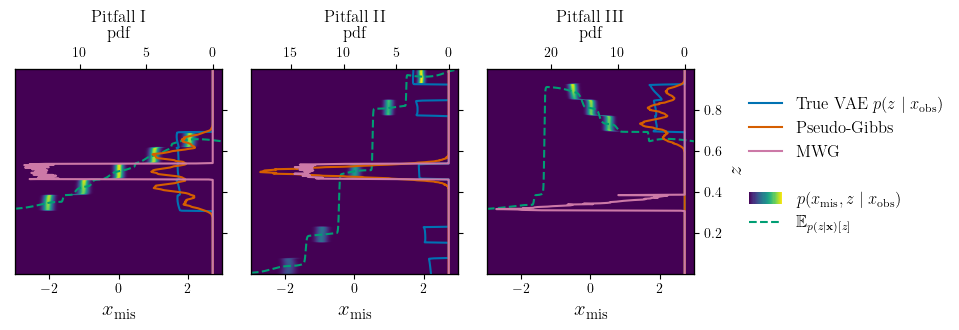

In [94]:
limits = (-3, 3)
bins = 5000

# data_idxs = [0, 1, 3, 5, 10, 12]
data_idxs = [3, 10, 5, ]
plot_mog = False

kde_bw_method = 0.02


plot_var_latent = False
plot_true_latent = True
assert not (plot_var_latent and plot_true_latent)
latent_pdf_plot_log = False
plot_latent_joint_vae = True
var_temperature=None

pdf_plot_log = False

plot_scatter = False
scatter_alpha = 0.1
vae_integration_kwargs={'latent_min':0., 
                        'latent_max':1.+1e-8, 
                        'latent_bins': 500}
latent_x_bins = 5000
vae_latent_pdf_kwargs={'latent_min':0.+1e-6, 
                        'latent_max':1.-1e-6, 
                        'latent_bins': 500}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = colors + ['r', 'm', 'w', 'g', 'k', 'c', 'y', 'tomato']
# colors = sns.color_palette(palette='colorblind', n_colors=total_num_models_for_colors)
# Swap colors
colors[0], colors[1] = colors[1], colors[0]


color_idx = 0

cm = plt.cm.viridis
# cm = sns.color_palette('mako', as_cmap=True)

# custom_imshow_vmax=50
custom_imshow_vmax=None

vae = VAE.load_from_checkpoint(vae_path)
vae = vae.eval()

# fig = plt.figure(figsize=(10,5), )#constrained_layout=True)

# gs = gridspec.GridSpec(ncols=3, nrows=2, wspace=.3, hspace=0.2)

# wgap_inner = 0.6
# gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0, 0], width_ratios=[20], wspace=wgap_inner)
# gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0, 1], width_ratios=[20], wspace=wgap_inner)
# gs3 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0, 2], width_ratios=[20], wspace=wgap_inner)
# gs4 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1, 0], width_ratios=[20], wspace=wgap_inner)
# gs5 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1, 1], width_ratios=[20], wspace=wgap_inner)
# gs6 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1, 2], width_ratios=[20], wspace=wgap_inner)

# axes = []
# caxes = []
# axes.append(fig.add_subplot(gs1[0, 0]))
# caxes.append(fig.add_subplot(gs1[0, 1]))
# axes.append(fig.add_subplot(gs2[0, 0]))
# caxes.append(fig.add_subplot(gs2[0, 1]))
# axes.append(fig.add_subplot(gs3[0, 0]))
# caxes.append(fig.add_subplot(gs3[0, 1]))
# axes.append(fig.add_subplot(gs4[0, 0]))
# caxes.append(fig.add_subplot(gs4[0, 1]))
# axes.append(fig.add_subplot(gs5[0, 0]))
# caxes.append(fig.add_subplot(gs5[0, 1]))
# axes.append(fig.add_subplot(gs6[0, 0]))
# caxes.append(fig.add_subplot(gs6[0, 1]))

fig, axes = plt.subplots(ncols=3, nrows=1, sharex=True, sharey=True, figsize=(9.5,3.4))
axes = axes.flatten()

divergences = {}
for d, data_idx in enumerate(data_idxs):
    color_idx = 0
    divergences[data_idx] = {}
    for i, (method, cfg) in enumerate(imputation_cfgs.items()):
        divergences[data_idx][method] = {}
        imputations = load_imputations_from_experiment(cfg['path'])

        X_imp = imputations['imputations'][data_idx]
        Z_imp = imputations['latents'][data_idx, 0].flatten()
        M = imputations['masks'][data_idx, 0]
        miss_idx = np.where(~M)[0][0]
        X_imp = X_imp[..., miss_idx]
        X_imp = rearrange(X_imp, 'k t -> (k t)')

        X_true = imputations['true_X'][data_idx, 0]
        obs_idx = np.where(M)[0][0]

        x = np.linspace(limits[0], limits[1], bins, dtype=np.float32)
        dx = (limits[1] - limits[0]) / bins
        
        # Plot MoG
        if i == 0 and plot_mog:
            mog_logpdf = mog_compute_conditional_logpdf(x, X_true, M, params)
            mog_logpdf = asnumpy(mog_logpdf)
            mog_pdf = np.exp(asnumpy)
#             axes[d].plot(x, mog_logpdf if pdf_plot_log else mog_pdf ,linewidth=2., 
#                               color=colors[color_idx], label='True MoG')# $p(x_m \mid x_o)$')
#             color_idx += 1

        # Plot VAE
        if i == 0:
            vae_logpdf = vae_compute_conditional_logpdf(x, dx, X_true, M, vae, params, vae_integration_kwargs)
            vae_logpdf = asnumpy(vae_logpdf)
            vae_pdf = np.exp(vae_logpdf)
#             axes[d].plot(x, vae_logpdf if pdf_plot_log else vae_pdf ,linewidth=2., 
#                               color=colors[color_idx], label='True VAE')# $p(x_m \mid x_o)$')
            
#             color_idx += 1
            
            max_height = vae_pdf.max()
            
        # Plot var latent
        if i == 0 and plot_var_latent:
            latent_x = np.linspace(limits[0], limits[1], latent_x_bins, dtype=np.float32)
            
            ax_twin = axes[d].twinx()
            
            encoder_z_exp_vals = vae_encoder_latent_posterior_expected_value_1d(latent_x, X_true, M, vae, temperature=var_temperature)
            ax_twin.plot(latent_x, encoder_z_exp_vals, color=colors[color_idx], linestyle='--', label='$\\mathbb{E}_{q(z \\mid \mathbf{x})\\left[z\\right]}$')
            color_idx += 1
            
            q_logpdf = vae_encoder_latent_posterior_logpdf_1d(latent_x, M, X_true, vae, vae_latent_pdf_kwargs, temperature=var_temperature)
            q_logpdf = rearrange(asnumpy(q_logpdf), 'd z -> z d')
            q_pdf = np.exp(q_logpdf)
            if plot_latent_joint_vae:
                qp_logpdf = q_logpdf + vae_logpdf[None, :]
                qp_pdf = np.exp(qp_logpdf)
                im = ax_twin.imshow(qp_logpdf if latent_pdf_plot_log else qp_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower',
                               cmap=cm,
                               vmax=custom_imshow_vmax)
            else:
                im = ax_twin.imshow(q_logpdf if latent_pdf_plot_log else q_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower',
                               cmap=cm,
                               vmax=custom_imshow_vmax)
#             fig.colorbar(im, cax=caxes[d],)# anchor=(2., 0.5))
#             latent_plotting_pdf_label_prefix = ''
#             if latent_pdf_plot_log:
#                 latent_plotting_pdf_label_prefix = '\log'
#             if plot_latent_joint_vae:
#                 caxes[d].set_ylabel(f'${latent_plotting_pdf_label_prefix} p(x_m, z \mid x_o={X_true[obs_idx]})$', fontsize=15)
#             else:
#                 caxes[d].set_ylabel(f'${latent_plotting_pdf_label_prefix} p(z \mid x_m, x_o={X_true[obs_idx]})$', fontsize=15)
            
            ax_twin.set_aspect('auto')
            ax_twin.set_zorder(axes[d].get_zorder() - 1)
            ax_twin.set_ylabel('$z$', fontsize=15)
            axes[d].patch.set_alpha(0.)
            
        # Plot true latent
        if i == 0 and plot_true_latent:
            latent_x = np.linspace(limits[0], limits[1], latent_x_bins, dtype=np.float32)
            
            ax_twin = axes[d].twinx()
            
            true_z_exp_vals = vae_true_latent_posterior_expected_value_1d(latent_x, X_true, M, vae, vae_latent_pdf_kwargs)
            ax_twin.plot(latent_x, true_z_exp_vals, color=colors[color_idx], linestyle='--', label='$\\mathbb{E}_{p(z \\mid \mathbf{x})\\left[z\\right]}$')
            color_idx += 1
            
            pz_logpdf = vae_true_latent_posterior_logpdf_1d(latent_x, X_true, M, vae, vae_latent_pdf_kwargs)
            pz_logpdf = rearrange(asnumpy(pz_logpdf), 'd z -> z d')
            pz_pdf = np.exp(pz_logpdf)
            if plot_latent_joint_vae:
                pzp_logpdf = pz_logpdf + vae_logpdf[None, :]
                pzp_pdf = np.exp(pzp_logpdf)
                
                im = ax_twin.imshow(pzp_logpdf if latent_pdf_plot_log else pzp_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower',
                               cmap=cm,
                               vmax=custom_imshow_vmax)
            else:
                im = ax_twin.imshow(pz_logpdf if latent_pdf_plot_log else pz_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower',
                               cmap=cm,
                               vmax=custom_imshow_vmax)
#             fig.colorbar(im, cax=caxes[d],)# anchor=(2., 0.5))
            
#             latent_plotting_pdf_label_prefix = ''
#             if latent_pdf_plot_log:
#                 latent_plotting_pdf_label_prefix = '\log'
#             if plot_latent_joint_vae:
#                 caxes[d].set_ylabel(f'${latent_plotting_pdf_label_prefix} p(x_m, z \mid x_o={X_true[obs_idx]})$', fontsize=15)
#             else:
#                 caxes[d].set_ylabel(f'${latent_plotting_pdf_label_prefix} p(z \mid x_m, x_o={X_true[obs_idx]})$', fontsize=15)
            
            ax_twin.set_aspect('auto')
            ax_twin.set_zorder(axes[d].get_zorder() - 1)
            ax_twin.set_ylabel('$z$', fontsize=15)
            axes[d].patch.set_alpha(0.)
            
            ax_twin_twin = ax_twin.twiny()
            dx = (limits[1] - limits[0]) / bins
            pz_marg_logpdf = torch.logsumexp(torch.tensor(pzp_logpdf), dim=-1) + torch.log(torch.tensor(dx))
            Z = np.linspace(vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max'], vae_latent_pdf_kwargs['latent_bins'])
            pz_marg_pdf = np.exp(pz_marg_logpdf)
            ax_twin_twin.plot(pz_marg_pdf, Z, color=colors[color_idx], label='True VAE $p(z \mid x_{\\text{obs}})$')
            color_idx += 1
            
            ax_twin_twin.yaxis.tick_right()
            ax_twin_twin.invert_xaxis()
            
        # Plot KDE
        kde_imp = sstats.gaussian_kde(Z_imp, bw_method=kde_bw_method)
        Z = np.linspace(vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max'], vae_latent_pdf_kwargs['latent_bins'])
        logpdf = kde_imp.logpdf(Z)
        pdf = np.exp(logpdf)
        ax_twin_twin.plot(logpdf if pdf_plot_log else pdf, Z, color=colors[color_idx], label=method)
        
#         if plot_scatter:
#             scatter_height = max_height/20
#             axes[d].scatter(X_imp, np.zeros(X_imp.shape[0])-(i+1)*scatter_height, 
#                                  marker='.', alpha=scatter_alpha,
#                                  color=colors[color_idx])
            
        color_idx += 1
        
        plotting_pdf_label_prefix = ''
        if pdf_plot_log:
            plotting_pdf_label_prefix = '\log'
#         axes[d].set_ylabel(f'${plotting_pdf_label_prefix} p(x_m \mid x_o={X_true[obs_idx]})$', fontsize=15)
        
#         axes[d].set_title(f'Data idx: {data_idx}, observed value: {X_true}, observed dim: {obs_idx}', fontsize=15)
#         axes[d].set_title(f'Data idx: {data_idx}', fontsize=15)
#         axes[d].set_title(f'$x_{obs_idx}\!=\!{X_true[obs_idx]}$', fontsize=15)
        if d == 0:
            axes[d].set_title(f'Pitfall I\n pdf')
        elif d == 1:
            axes[d].set_title(f'Pitfall II\n pdf')
        elif d == 2:
            axes[d].set_title(f'Pitfall III\n pdf')
        
        
#         # Compute KL divergences
#         kl_fow, kl_rev, jsd = compute_divergences_between_logpds_arrays(vae_logpdf, logpdf, dx)
#         divergences[data_idx][method]['kl_fow'] = kl_fow
#         divergences[data_idx][method]['kl_rev'] = kl_rev
#         divergences[data_idx][method]['jsd'] = jsd
#     divergences[data_idx]['title'] = f'Data idx: {data_idx}, observed value: {X_true}, observed dim: {obs_idx}'

    axes[d].set_xlim(limits[0], limits[1])
    
#     if d > 2:
    axes[d].set_xlabel('$x_{\\text{mis}}$', fontsize=15)
    
    if d in (0,):
        axes[d].set_ylabel('', fontsize=15)
        axes[d].set_yticklabels([])
        axes[d].set_yticks([])
    if d in (0, 1):
        ax_twin.set_yticklabels([])
        ax_twin.set_ylabel('')

        
fig.tight_layout(rect=(0, 0, 1, 0.95))

labels = []
handles = []

# Add lines from the figures
handles_ax, labels_ax = axes[1].get_legend_handles_labels()
labels.extend(labels_ax)
handles.extend(handles_ax)

ax_twin_twin_handles, ax_twin_twin_labels = ax_twin_twin.get_legend_handles_labels()
labels.extend(ax_twin_twin_labels)
handles.extend(ax_twin_twin_handles)

# Add space in the legend
labels.append('')
handles.append(mpl.lines.Line2D([], [], color="none"))

# Add secondary axes legend items
labels.append('$p(x_{\\text{mis}}, z \mid x_{\\text{obs}})$')
countour_legend_rect = mpl.patches.Rectangle((0, 0), 1, 1)
handles.append(countour_legend_rect)

ax_twin_handles, ax_twin_labels = ax_twin.get_legend_handles_labels()
labels.extend(ax_twin_labels)
handles.extend(ax_twin_handles)

handler_map = {
    countour_legend_rect: HandlerColormap(cm, num_stripes=30)
}

# Place on top use with figsize=(8,3)
# fig.tight_layout(rect=(0, 0, 1, 0.95))
# axes[1].legend(handles, labels,
#                handler_map=handler_map,
#                ncol=5, 
#               bbox_to_anchor=(0.5, 0.95), 
#               bbox_transform=fig.transFigure, 
#               loc='center',
#               fontsize=12,
#               frameon=False)

# Place on the right use with figsize=(9.5,3)
fig.tight_layout(rect=(0, 0, 0.81, 1))
axes[1].legend(handles, labels,
               handler_map=handler_map,
               ncol=1, 
              bbox_to_anchor=(0.90, 0.5), 
              bbox_transform=fig.transFigure, 
              loc='center',
              fontsize=12,
              frameon=False)

# fig.savefig('figures/grid2dmog4_mwg_pitfalls_latents.pdf')

#### AC-MWG verification pitfalls + Marginal over z

In [96]:
vae_model_name = 'vae_comptrain'
checkpoint_name = 'last'
vae_path = (f'../logs/{dataset}/imputation/{vae_model_name}/seed_m20220118_d20220118/lightning_logs/'
            f'version_0/checkpoints/{checkpoint_name}.ckpt')

imp_path_template = (f'../logs/{dataset}/imputation/sampling/{vae_model_name}/'
                     '{}/seed_m20220118_d20220118/lightning_logs/')
imputation_cfgs = {
    'Pseudo-Gibbs': {
        'path': imp_path_template.format('pg_k1_no_warmup_it50000_storelatents')
    },
#     'MWG PGW1 K=1 it50000': {
    'MWG': {
        'path': imp_path_template.format('mwg_k1_no_warmup_it50000_storelatents')
    },
#     'MWGM+RH 001P PGW1 K=1 it50000': {
    'AC-MWG': {
        'path': imp_path_template.format('mwgm_userestricthist_001prior_k1_no_warmup_it50000_storelatents')
    }
}

total_num_models_for_colors = 6

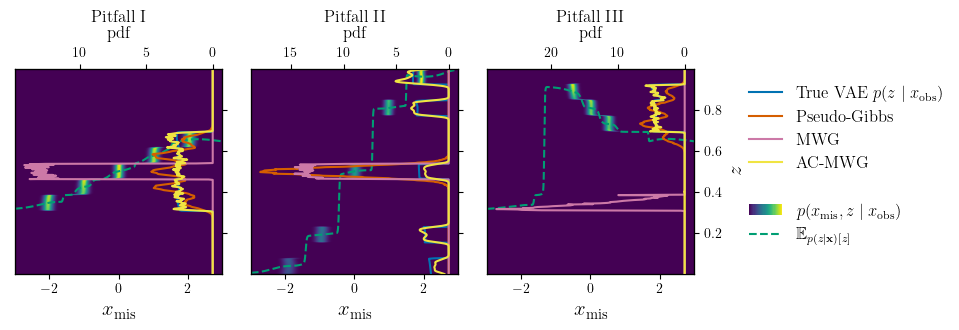

In [97]:
limits = (-3, 3)
bins = 5000

# data_idxs = [0, 1, 3, 5, 10, 12]
data_idxs = [3, 10, 5, ]
plot_mog = False

kde_bw_method = 0.02


plot_var_latent = False
plot_true_latent = True
assert not (plot_var_latent and plot_true_latent)
latent_pdf_plot_log = False
plot_latent_joint_vae = True
var_temperature=None

pdf_plot_log = False

plot_scatter = False
scatter_alpha = 0.1
vae_integration_kwargs={'latent_min':0., 
                        'latent_max':1.+1e-8, 
                        'latent_bins': 500}
latent_x_bins = 5000
vae_latent_pdf_kwargs={'latent_min':0.+1e-6, 
                        'latent_max':1.-1e-6, 
                        'latent_bins': 500}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = colors + ['r', 'm', 'w', 'g', 'k', 'c', 'y', 'tomato']
# colors = sns.color_palette(palette='colorblind', n_colors=total_num_models_for_colors)
# Swap colors
colors[0], colors[1] = colors[1], colors[0]


color_idx = 0

cm = plt.cm.viridis
# cm = sns.color_palette('mako', as_cmap=True)

# custom_imshow_vmax=50
custom_imshow_vmax=None

vae = VAE.load_from_checkpoint(vae_path)
vae = vae.eval()

# fig = plt.figure(figsize=(10,5), )#constrained_layout=True)

# gs = gridspec.GridSpec(ncols=3, nrows=2, wspace=.3, hspace=0.2)

# wgap_inner = 0.6
# gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0, 0], width_ratios=[20], wspace=wgap_inner)
# gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0, 1], width_ratios=[20], wspace=wgap_inner)
# gs3 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0, 2], width_ratios=[20], wspace=wgap_inner)
# gs4 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1, 0], width_ratios=[20], wspace=wgap_inner)
# gs5 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1, 1], width_ratios=[20], wspace=wgap_inner)
# gs6 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1, 2], width_ratios=[20], wspace=wgap_inner)

# axes = []
# caxes = []
# axes.append(fig.add_subplot(gs1[0, 0]))
# caxes.append(fig.add_subplot(gs1[0, 1]))
# axes.append(fig.add_subplot(gs2[0, 0]))
# caxes.append(fig.add_subplot(gs2[0, 1]))
# axes.append(fig.add_subplot(gs3[0, 0]))
# caxes.append(fig.add_subplot(gs3[0, 1]))
# axes.append(fig.add_subplot(gs4[0, 0]))
# caxes.append(fig.add_subplot(gs4[0, 1]))
# axes.append(fig.add_subplot(gs5[0, 0]))
# caxes.append(fig.add_subplot(gs5[0, 1]))
# axes.append(fig.add_subplot(gs6[0, 0]))
# caxes.append(fig.add_subplot(gs6[0, 1]))

fig, axes = plt.subplots(ncols=3, nrows=1, sharex=True, sharey=True, figsize=(9.5,3.4))
axes = axes.flatten()

divergences = {}
for d, data_idx in enumerate(data_idxs):
    color_idx = 0
    divergences[data_idx] = {}
    for i, (method, cfg) in enumerate(imputation_cfgs.items()):
        divergences[data_idx][method] = {}
        imputations = load_imputations_from_experiment(cfg['path'])

        X_imp = imputations['imputations'][data_idx]
        Z_imp = imputations['latents'][data_idx, 0].flatten()
        M = imputations['masks'][data_idx, 0]
        miss_idx = np.where(~M)[0][0]
        X_imp = X_imp[..., miss_idx]
        X_imp = rearrange(X_imp, 'k t -> (k t)')

        X_true = imputations['true_X'][data_idx, 0]
        obs_idx = np.where(M)[0][0]

        x = np.linspace(limits[0], limits[1], bins, dtype=np.float32)
        dx = (limits[1] - limits[0]) / bins
        
        # Plot MoG
        if i == 0 and plot_mog:
            mog_logpdf = mog_compute_conditional_logpdf(x, X_true, M, params)
            mog_logpdf = asnumpy(mog_logpdf)
            mog_pdf = np.exp(asnumpy)
#             axes[d].plot(x, mog_logpdf if pdf_plot_log else mog_pdf ,linewidth=2., 
#                               color=colors[color_idx], label='True MoG')# $p(x_m \mid x_o)$')
#             color_idx += 1

        # Plot VAE
        if i == 0:
            vae_logpdf = vae_compute_conditional_logpdf(x, dx, X_true, M, vae, params, vae_integration_kwargs)
            vae_logpdf = asnumpy(vae_logpdf)
            vae_pdf = np.exp(vae_logpdf)
#             axes[d].plot(x, vae_logpdf if pdf_plot_log else vae_pdf ,linewidth=2., 
#                               color=colors[color_idx], label='True VAE')# $p(x_m \mid x_o)$')
            
#             color_idx += 1
            
            max_height = vae_pdf.max()
            
        # Plot var latent
        if i == 0 and plot_var_latent:
            latent_x = np.linspace(limits[0], limits[1], latent_x_bins, dtype=np.float32)
            
            ax_twin = axes[d].twinx()
            
            encoder_z_exp_vals = vae_encoder_latent_posterior_expected_value_1d(latent_x, X_true, M, vae, temperature=var_temperature)
            ax_twin.plot(latent_x, encoder_z_exp_vals, color=colors[color_idx], linestyle='--', label='$\\mathbb{E}_{q(z \\mid \mathbf{x})\\left[z\\right]}$')
            color_idx += 1
            
            q_logpdf = vae_encoder_latent_posterior_logpdf_1d(latent_x, M, X_true, vae, vae_latent_pdf_kwargs, temperature=var_temperature)
            q_logpdf = rearrange(asnumpy(q_logpdf), 'd z -> z d')
            q_pdf = np.exp(q_logpdf)
            if plot_latent_joint_vae:
                qp_logpdf = q_logpdf + vae_logpdf[None, :]
                qp_pdf = np.exp(qp_logpdf)
                im = ax_twin.imshow(qp_logpdf if latent_pdf_plot_log else qp_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower',
                               cmap=cm,
                               vmax=custom_imshow_vmax)
            else:
                im = ax_twin.imshow(q_logpdf if latent_pdf_plot_log else q_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower',
                               cmap=cm,
                               vmax=custom_imshow_vmax)
#             fig.colorbar(im, cax=caxes[d],)# anchor=(2., 0.5))
#             latent_plotting_pdf_label_prefix = ''
#             if latent_pdf_plot_log:
#                 latent_plotting_pdf_label_prefix = '\log'
#             if plot_latent_joint_vae:
#                 caxes[d].set_ylabel(f'${latent_plotting_pdf_label_prefix} p(x_m, z \mid x_o={X_true[obs_idx]})$', fontsize=15)
#             else:
#                 caxes[d].set_ylabel(f'${latent_plotting_pdf_label_prefix} p(z \mid x_m, x_o={X_true[obs_idx]})$', fontsize=15)
            
            ax_twin.set_aspect('auto')
            ax_twin.set_zorder(axes[d].get_zorder() - 1)
            ax_twin.set_ylabel('$z$', fontsize=15)
            axes[d].patch.set_alpha(0.)
            
        # Plot true latent
        if i == 0 and plot_true_latent:
            latent_x = np.linspace(limits[0], limits[1], latent_x_bins, dtype=np.float32)
            
            ax_twin = axes[d].twinx()
            
            true_z_exp_vals = vae_true_latent_posterior_expected_value_1d(latent_x, X_true, M, vae, vae_latent_pdf_kwargs)
            ax_twin.plot(latent_x, true_z_exp_vals, color=colors[color_idx], linestyle='--', label='$\\mathbb{E}_{p(z \\mid \mathbf{x})\\left[z\\right]}$')
            color_idx += 1
            
            pz_logpdf = vae_true_latent_posterior_logpdf_1d(latent_x, X_true, M, vae, vae_latent_pdf_kwargs)
            pz_logpdf = rearrange(asnumpy(pz_logpdf), 'd z -> z d')
            pz_pdf = np.exp(pz_logpdf)
            if plot_latent_joint_vae:
                pzp_logpdf = pz_logpdf + vae_logpdf[None, :]
                pzp_pdf = np.exp(pzp_logpdf)
                
                im = ax_twin.imshow(pzp_logpdf if latent_pdf_plot_log else pzp_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower',
                               cmap=cm,
                               vmax=custom_imshow_vmax)
            else:
                im = ax_twin.imshow(pz_logpdf if latent_pdf_plot_log else pz_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower',
                               cmap=cm,
                               vmax=custom_imshow_vmax)
#             fig.colorbar(im, cax=caxes[d],)# anchor=(2., 0.5))
            
#             latent_plotting_pdf_label_prefix = ''
#             if latent_pdf_plot_log:
#                 latent_plotting_pdf_label_prefix = '\log'
#             if plot_latent_joint_vae:
#                 caxes[d].set_ylabel(f'${latent_plotting_pdf_label_prefix} p(x_m, z \mid x_o={X_true[obs_idx]})$', fontsize=15)
#             else:
#                 caxes[d].set_ylabel(f'${latent_plotting_pdf_label_prefix} p(z \mid x_m, x_o={X_true[obs_idx]})$', fontsize=15)
            
            ax_twin.set_aspect('auto')
            ax_twin.set_zorder(axes[d].get_zorder() - 1)
            ax_twin.set_ylabel('$z$', fontsize=15)
            axes[d].patch.set_alpha(0.)
            
            ax_twin_twin = ax_twin.twiny()
            dx = (limits[1] - limits[0]) / bins
            pz_marg_logpdf = torch.logsumexp(torch.tensor(pzp_logpdf), dim=-1) + torch.log(torch.tensor(dx))
            Z = np.linspace(vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max'], vae_latent_pdf_kwargs['latent_bins'])
            pz_marg_pdf = np.exp(pz_marg_logpdf)
            ax_twin_twin.plot(pz_marg_pdf, Z, color=colors[color_idx], label='True VAE $p(z \mid x_{\\text{obs}})$')
            color_idx += 1
            
            ax_twin_twin.yaxis.tick_right()
            ax_twin_twin.invert_xaxis()
            
        # Plot KDE
        kde_imp = sstats.gaussian_kde(Z_imp, bw_method=kde_bw_method)
        Z = np.linspace(vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max'], vae_latent_pdf_kwargs['latent_bins'])
        logpdf = kde_imp.logpdf(Z)
        pdf = np.exp(logpdf)
        ax_twin_twin.plot(logpdf if pdf_plot_log else pdf, Z, color=colors[color_idx], label=method)
        
#         if plot_scatter:
#             scatter_height = max_height/20
#             axes[d].scatter(X_imp, np.zeros(X_imp.shape[0])-(i+1)*scatter_height, 
#                                  marker='.', alpha=scatter_alpha,
#                                  color=colors[color_idx])
            
        color_idx += 1
        
        plotting_pdf_label_prefix = ''
        if pdf_plot_log:
            plotting_pdf_label_prefix = '\log'
#         axes[d].set_ylabel(f'${plotting_pdf_label_prefix} p(x_m \mid x_o={X_true[obs_idx]})$', fontsize=15)
        
#         axes[d].set_title(f'Data idx: {data_idx}, observed value: {X_true}, observed dim: {obs_idx}', fontsize=15)
#         axes[d].set_title(f'Data idx: {data_idx}', fontsize=15)
#         axes[d].set_title(f'$x_{obs_idx}\!=\!{X_true[obs_idx]}$', fontsize=15)
        if d == 0:
            axes[d].set_title(f'Pitfall I\n pdf')
        elif d == 1:
            axes[d].set_title(f'Pitfall II\n pdf')
        elif d == 2:
            axes[d].set_title(f'Pitfall III\n pdf')
        
        
#         # Compute KL divergences
#         kl_fow, kl_rev, jsd = compute_divergences_between_logpds_arrays(vae_logpdf, logpdf, dx)
#         divergences[data_idx][method]['kl_fow'] = kl_fow
#         divergences[data_idx][method]['kl_rev'] = kl_rev
#         divergences[data_idx][method]['jsd'] = jsd
#     divergences[data_idx]['title'] = f'Data idx: {data_idx}, observed value: {X_true}, observed dim: {obs_idx}'

    axes[d].set_xlim(limits[0], limits[1])
    
#     if d > 2:
    axes[d].set_xlabel('$x_{\\text{mis}}$', fontsize=15)
    
    if d in (0,):
        axes[d].set_ylabel('', fontsize=15)
        axes[d].set_yticklabels([])
        axes[d].set_yticks([])
    if d in (0, 1):
        ax_twin.set_yticklabels([])
        ax_twin.set_ylabel('')

        
fig.tight_layout(rect=(0, 0, 1, 0.95))

labels = []
handles = []

# Add lines from the figures
handles_ax, labels_ax = axes[1].get_legend_handles_labels()
labels.extend(labels_ax)
handles.extend(handles_ax)

ax_twin_twin_handles, ax_twin_twin_labels = ax_twin_twin.get_legend_handles_labels()
labels.extend(ax_twin_twin_labels)
handles.extend(ax_twin_twin_handles)

# Add space in the legend
labels.append('')
handles.append(mpl.lines.Line2D([], [], color="none"))

# Add secondary axes legend items
labels.append('$p(x_{\\text{mis}}, z \mid x_{\\text{obs}})$')
countour_legend_rect = mpl.patches.Rectangle((0, 0), 1, 1)
handles.append(countour_legend_rect)

ax_twin_handles, ax_twin_labels = ax_twin.get_legend_handles_labels()
labels.extend(ax_twin_labels)
handles.extend(ax_twin_handles)

handler_map = {
    countour_legend_rect: HandlerColormap(cm, num_stripes=30)
}

# Place on top use with figsize=(8,3)
# fig.tight_layout(rect=(0, 0, 1, 0.95))
# axes[1].legend(handles, labels,
#                handler_map=handler_map,
#                ncol=5, 
#               bbox_to_anchor=(0.5, 0.95), 
#               bbox_transform=fig.transFigure, 
#               loc='center',
#               fontsize=12,
#               frameon=False)

# Place on the right use with figsize=(9.5,3)
fig.tight_layout(rect=(0, 0, 0.81, 1))
axes[1].legend(handles, labels,
               handler_map=handler_map,
               ncol=1, 
              bbox_to_anchor=(0.90, 0.5), 
              bbox_transform=fig.transFigure, 
              loc='center',
              fontsize=12,
              frameon=False)

# fig.savefig('figures/grid2dmog4_ac_mwg_latents.pdf')

#### LAIR verification pitfalls + Marginal over z

In [98]:
vae_model_name = 'vae_comptrain'
checkpoint_name = 'last'
vae_path = (f'../logs/{dataset}/imputation/{vae_model_name}/seed_m20220118_d20220118/lightning_logs/'
            f'version_0/checkpoints/{checkpoint_name}.ckpt')

imp_path_template = (f'../logs/{dataset}/imputation/sampling/{vae_model_name}/'
                     '{}/seed_m20220118_d20220118/lightning_logs/')
imputation_cfgs = {
    'Pseudo-Gibbs': {
        'path': imp_path_template.format('pg_k1_no_warmup_it50000_storelatents')
    },
#     'MWG PGW1 K=1 it50000': {
    'MWG': {
        'path': imp_path_template.format('mwg_k1_no_warmup_it50000_storelatents')
    },
#     'MWGM+RH 001P PGW1 K=1 it50000': {
#     'AC-MWG': {
#         'path': imp_path_template.format('mwgm_userestricthist_001prior_k1_no_warmup_it50000')
#     }
    
# #     'IRWG K=5 DMIS GR it10000': {
#     'LAIR': {
#         'path': imp_path_template.format('irwg_k5_dmis_gr_mult_it10000')
#     },
#     'IRWG K=4 R=1 DMIS GR it10000': {
#     'LAIR': {
#         'path': imp_path_template.format('irwg_k4_dmis_gr_mult_it10000_replenish1')
#     },
#     'IRWG K=9 R=1 DMIS GR it5000': {
#     'LAIR': {
#         'path': imp_path_template.format('irwg_k9_dmis_gr_mult_it5000_replenish1')
#     },
#     'LAIR K4': {
#         'path': imp_path_template.format('irwg_k4_dmis_gr_mult_it10000_replenish1')
#     },
#     'LAIR K4 resampled': {
#         'path': imp_path_template.format('irwg_k4_dmis_gr_mult_it10000_replenish1_finalresample'),
#         'use_resampled_imps': True
#     },
#     'IRWG K=19 R=1 DMIS GR it2500': {
#     'LAIR': {
#         'path': imp_path_template.format('irwg_k19_dmis_gr_mult_it2500_replenish1')
#     },
#     'LAIR resampled': {
    'LAIR': {
        'path': imp_path_template.format('irwg_k19_dmis_gr_mult_it2500_replenish1_finalresample_storelatents'),
        'use_resampled_imps': True
    },
    
}

total_num_models_for_colors = 6

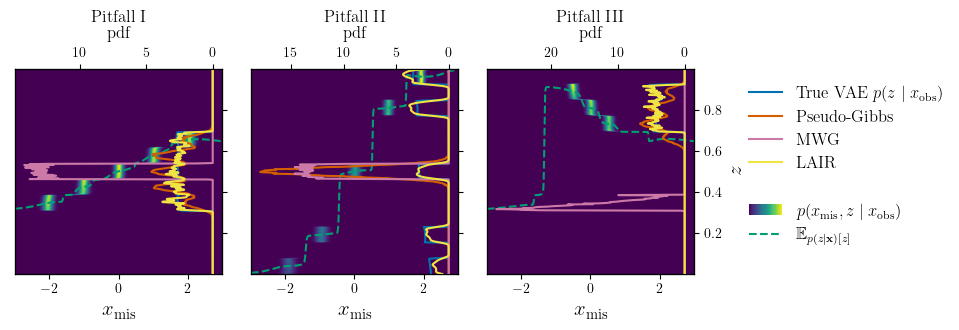

In [99]:
limits = (-3, 3)
bins = 5000

# data_idxs = [0, 1, 3, 5, 10, 12]
data_idxs = [3, 10, 5, ]
plot_mog = False

kde_bw_method = 0.02


plot_var_latent = False
plot_true_latent = True
assert not (plot_var_latent and plot_true_latent)
latent_pdf_plot_log = False
plot_latent_joint_vae = True
var_temperature=None

pdf_plot_log = False

plot_scatter = False
scatter_alpha = 0.1
vae_integration_kwargs={'latent_min':0., 
                        'latent_max':1.+1e-8, 
                        'latent_bins': 500}
latent_x_bins = 5000
vae_latent_pdf_kwargs={'latent_min':0.+1e-6, 
                        'latent_max':1.-1e-6, 
                        'latent_bins': 500}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = colors + ['r', 'm', 'w', 'g', 'k', 'c', 'y', 'tomato']
# colors = sns.color_palette(palette='colorblind', n_colors=total_num_models_for_colors)
# Swap colors
colors[0], colors[1] = colors[1], colors[0]


color_idx = 0

cm = plt.cm.viridis
# cm = sns.color_palette('mako', as_cmap=True)

# custom_imshow_vmax=50
custom_imshow_vmax=None

vae = VAE.load_from_checkpoint(vae_path)
vae = vae.eval()

# fig = plt.figure(figsize=(10,5), )#constrained_layout=True)

# gs = gridspec.GridSpec(ncols=3, nrows=2, wspace=.3, hspace=0.2)

# wgap_inner = 0.6
# gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0, 0], width_ratios=[20], wspace=wgap_inner)
# gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0, 1], width_ratios=[20], wspace=wgap_inner)
# gs3 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0, 2], width_ratios=[20], wspace=wgap_inner)
# gs4 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1, 0], width_ratios=[20], wspace=wgap_inner)
# gs5 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1, 1], width_ratios=[20], wspace=wgap_inner)
# gs6 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1, 2], width_ratios=[20], wspace=wgap_inner)

# axes = []
# caxes = []
# axes.append(fig.add_subplot(gs1[0, 0]))
# caxes.append(fig.add_subplot(gs1[0, 1]))
# axes.append(fig.add_subplot(gs2[0, 0]))
# caxes.append(fig.add_subplot(gs2[0, 1]))
# axes.append(fig.add_subplot(gs3[0, 0]))
# caxes.append(fig.add_subplot(gs3[0, 1]))
# axes.append(fig.add_subplot(gs4[0, 0]))
# caxes.append(fig.add_subplot(gs4[0, 1]))
# axes.append(fig.add_subplot(gs5[0, 0]))
# caxes.append(fig.add_subplot(gs5[0, 1]))
# axes.append(fig.add_subplot(gs6[0, 0]))
# caxes.append(fig.add_subplot(gs6[0, 1]))

fig, axes = plt.subplots(ncols=3, nrows=1, sharex=True, sharey=True, figsize=(9.5,3.4))
axes = axes.flatten()

divergences = {}
for d, data_idx in enumerate(data_idxs):
    color_idx = 0
    divergences[data_idx] = {}
    for i, (method, cfg) in enumerate(imputation_cfgs.items()):
        divergences[data_idx][method] = {}
        imputations = load_imputations_from_experiment(cfg['path'])

        X_imp = imputations['imputations'][data_idx]
        Z_imp = imputations['latents'][data_idx, 0].flatten()
        M = imputations['masks'][data_idx, 0]
        miss_idx = np.where(~M)[0][0]
        X_imp = X_imp[..., miss_idx]
        X_imp = rearrange(X_imp, 'k t -> (k t)')

        X_true = imputations['true_X'][data_idx, 0]
        obs_idx = np.where(M)[0][0]

        x = np.linspace(limits[0], limits[1], bins, dtype=np.float32)
        dx = (limits[1] - limits[0]) / bins
        
        # Plot MoG
        if i == 0 and plot_mog:
            mog_logpdf = mog_compute_conditional_logpdf(x, X_true, M, params)
            mog_logpdf = asnumpy(mog_logpdf)
            mog_pdf = np.exp(asnumpy)
#             axes[d].plot(x, mog_logpdf if pdf_plot_log else mog_pdf ,linewidth=2., 
#                               color=colors[color_idx], label='True MoG')# $p(x_m \mid x_o)$')
#             color_idx += 1

        # Plot VAE
        if i == 0:
            vae_logpdf = vae_compute_conditional_logpdf(x, dx, X_true, M, vae, params, vae_integration_kwargs)
            vae_logpdf = asnumpy(vae_logpdf)
            vae_pdf = np.exp(vae_logpdf)
#             axes[d].plot(x, vae_logpdf if pdf_plot_log else vae_pdf ,linewidth=2., 
#                               color=colors[color_idx], label='True VAE')# $p(x_m \mid x_o)$')
            
#             color_idx += 1
            
            max_height = vae_pdf.max()
            
        # Plot var latent
        if i == 0 and plot_var_latent:
            latent_x = np.linspace(limits[0], limits[1], latent_x_bins, dtype=np.float32)
            
            ax_twin = axes[d].twinx()
            
            encoder_z_exp_vals = vae_encoder_latent_posterior_expected_value_1d(latent_x, X_true, M, vae, temperature=var_temperature)
            ax_twin.plot(latent_x, encoder_z_exp_vals, color=colors[color_idx], linestyle='--', label='$\\mathbb{E}_{q(z \\mid \mathbf{x})\\left[z\\right]}$')
            color_idx += 1
            
            q_logpdf = vae_encoder_latent_posterior_logpdf_1d(latent_x, M, X_true, vae, vae_latent_pdf_kwargs, temperature=var_temperature)
            q_logpdf = rearrange(asnumpy(q_logpdf), 'd z -> z d')
            q_pdf = np.exp(q_logpdf)
            if plot_latent_joint_vae:
                qp_logpdf = q_logpdf + vae_logpdf[None, :]
                qp_pdf = np.exp(qp_logpdf)
                im = ax_twin.imshow(qp_logpdf if latent_pdf_plot_log else qp_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower',
                               cmap=cm,
                               vmax=custom_imshow_vmax)
            else:
                im = ax_twin.imshow(q_logpdf if latent_pdf_plot_log else q_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower',
                               cmap=cm,
                               vmax=custom_imshow_vmax)
#             fig.colorbar(im, cax=caxes[d],)# anchor=(2., 0.5))
#             latent_plotting_pdf_label_prefix = ''
#             if latent_pdf_plot_log:
#                 latent_plotting_pdf_label_prefix = '\log'
#             if plot_latent_joint_vae:
#                 caxes[d].set_ylabel(f'${latent_plotting_pdf_label_prefix} p(x_m, z \mid x_o={X_true[obs_idx]})$', fontsize=15)
#             else:
#                 caxes[d].set_ylabel(f'${latent_plotting_pdf_label_prefix} p(z \mid x_m, x_o={X_true[obs_idx]})$', fontsize=15)
            
            ax_twin.set_aspect('auto')
            ax_twin.set_zorder(axes[d].get_zorder() - 1)
            ax_twin.set_ylabel('$z$', fontsize=15)
            axes[d].patch.set_alpha(0.)
            
        # Plot true latent
        if i == 0 and plot_true_latent:
            latent_x = np.linspace(limits[0], limits[1], latent_x_bins, dtype=np.float32)
            
            ax_twin = axes[d].twinx()
            
            true_z_exp_vals = vae_true_latent_posterior_expected_value_1d(latent_x, X_true, M, vae, vae_latent_pdf_kwargs)
            ax_twin.plot(latent_x, true_z_exp_vals, color=colors[color_idx], linestyle='--', label='$\\mathbb{E}_{p(z \\mid \mathbf{x})\\left[z\\right]}$')
            color_idx += 1
            
            pz_logpdf = vae_true_latent_posterior_logpdf_1d(latent_x, X_true, M, vae, vae_latent_pdf_kwargs)
            pz_logpdf = rearrange(asnumpy(pz_logpdf), 'd z -> z d')
            pz_pdf = np.exp(pz_logpdf)
            if plot_latent_joint_vae:
                pzp_logpdf = pz_logpdf + vae_logpdf[None, :]
                pzp_pdf = np.exp(pzp_logpdf)
                
                im = ax_twin.imshow(pzp_logpdf if latent_pdf_plot_log else pzp_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower',
                               cmap=cm,
                               vmax=custom_imshow_vmax)
            else:
                im = ax_twin.imshow(pz_logpdf if latent_pdf_plot_log else pz_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower',
                               cmap=cm,
                               vmax=custom_imshow_vmax)
#             fig.colorbar(im, cax=caxes[d],)# anchor=(2., 0.5))
            
#             latent_plotting_pdf_label_prefix = ''
#             if latent_pdf_plot_log:
#                 latent_plotting_pdf_label_prefix = '\log'
#             if plot_latent_joint_vae:
#                 caxes[d].set_ylabel(f'${latent_plotting_pdf_label_prefix} p(x_m, z \mid x_o={X_true[obs_idx]})$', fontsize=15)
#             else:
#                 caxes[d].set_ylabel(f'${latent_plotting_pdf_label_prefix} p(z \mid x_m, x_o={X_true[obs_idx]})$', fontsize=15)
            
            ax_twin.set_aspect('auto')
            ax_twin.set_zorder(axes[d].get_zorder() - 1)
            ax_twin.set_ylabel('$z$', fontsize=15)
            axes[d].patch.set_alpha(0.)
            
            ax_twin_twin = ax_twin.twiny()
            dx = (limits[1] - limits[0]) / bins
            pz_marg_logpdf = torch.logsumexp(torch.tensor(pzp_logpdf), dim=-1) + torch.log(torch.tensor(dx))
            Z = np.linspace(vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max'], vae_latent_pdf_kwargs['latent_bins'])
            pz_marg_pdf = np.exp(pz_marg_logpdf)
            ax_twin_twin.plot(pz_marg_pdf, Z, color=colors[color_idx], label='True VAE $p(z \mid x_{\\text{obs}})$')
            color_idx += 1
            
            ax_twin_twin.yaxis.tick_right()
            ax_twin_twin.invert_xaxis()
            
        # Plot KDE
        kde_imp = sstats.gaussian_kde(Z_imp, bw_method=kde_bw_method)
        Z = np.linspace(vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max'], vae_latent_pdf_kwargs['latent_bins'])
        logpdf = kde_imp.logpdf(Z)
        pdf = np.exp(logpdf)
        ax_twin_twin.plot(logpdf if pdf_plot_log else pdf, Z, color=colors[color_idx], label=method)
        
#         if plot_scatter:
#             scatter_height = max_height/20
#             axes[d].scatter(X_imp, np.zeros(X_imp.shape[0])-(i+1)*scatter_height, 
#                                  marker='.', alpha=scatter_alpha,
#                                  color=colors[color_idx])
            
        color_idx += 1
        
        plotting_pdf_label_prefix = ''
        if pdf_plot_log:
            plotting_pdf_label_prefix = '\log'
#         axes[d].set_ylabel(f'${plotting_pdf_label_prefix} p(x_m \mid x_o={X_true[obs_idx]})$', fontsize=15)
        
#         axes[d].set_title(f'Data idx: {data_idx}, observed value: {X_true}, observed dim: {obs_idx}', fontsize=15)
#         axes[d].set_title(f'Data idx: {data_idx}', fontsize=15)
#         axes[d].set_title(f'$x_{obs_idx}\!=\!{X_true[obs_idx]}$', fontsize=15)
        if d == 0:
            axes[d].set_title(f'Pitfall I\n pdf')
        elif d == 1:
            axes[d].set_title(f'Pitfall II\n pdf')
        elif d == 2:
            axes[d].set_title(f'Pitfall III\n pdf')
        
        
#         # Compute KL divergences
#         kl_fow, kl_rev, jsd = compute_divergences_between_logpds_arrays(vae_logpdf, logpdf, dx)
#         divergences[data_idx][method]['kl_fow'] = kl_fow
#         divergences[data_idx][method]['kl_rev'] = kl_rev
#         divergences[data_idx][method]['jsd'] = jsd
#     divergences[data_idx]['title'] = f'Data idx: {data_idx}, observed value: {X_true}, observed dim: {obs_idx}'

    axes[d].set_xlim(limits[0], limits[1])
    
#     if d > 2:
    axes[d].set_xlabel('$x_{\\text{mis}}$', fontsize=15)
    
    if d in (0,):
        axes[d].set_ylabel('', fontsize=15)
        axes[d].set_yticklabels([])
        axes[d].set_yticks([])
    if d in (0, 1):
        ax_twin.set_yticklabels([])
        ax_twin.set_ylabel('')

        
fig.tight_layout(rect=(0, 0, 1, 0.95))

labels = []
handles = []

# Add lines from the figures
handles_ax, labels_ax = axes[1].get_legend_handles_labels()
labels.extend(labels_ax)
handles.extend(handles_ax)

ax_twin_twin_handles, ax_twin_twin_labels = ax_twin_twin.get_legend_handles_labels()
labels.extend(ax_twin_twin_labels)
handles.extend(ax_twin_twin_handles)

# Add space in the legend
labels.append('')
handles.append(mpl.lines.Line2D([], [], color="none"))

# Add secondary axes legend items
labels.append('$p(x_{\\text{mis}}, z \mid x_{\\text{obs}})$')
countour_legend_rect = mpl.patches.Rectangle((0, 0), 1, 1)
handles.append(countour_legend_rect)

ax_twin_handles, ax_twin_labels = ax_twin.get_legend_handles_labels()
labels.extend(ax_twin_labels)
handles.extend(ax_twin_handles)

handler_map = {
    countour_legend_rect: HandlerColormap(cm, num_stripes=30)
}

# Place on top use with figsize=(8,3)
# fig.tight_layout(rect=(0, 0, 1, 0.95))
# axes[1].legend(handles, labels,
#                handler_map=handler_map,
#                ncol=5, 
#               bbox_to_anchor=(0.5, 0.95), 
#               bbox_transform=fig.transFigure, 
#               loc='center',
#               fontsize=12,
#               frameon=False)

# Place on the right use with figsize=(9.5,3)
fig.tight_layout(rect=(0, 0, 0.81, 1))
axes[1].legend(handles, labels,
               handler_map=handler_map,
               ncol=1, 
              bbox_to_anchor=(0.90, 0.5), 
              bbox_transform=fig.transFigure, 
              loc='center',
              fontsize=12,
              frameon=False)

# fig.savefig('figures/grid2dmog4_lair_latents.pdf')

### Finetuned with ELBO

#### Long run, single "chains"

In [33]:
vae_model_name = 'vae_from_pretrained_comptrain'
checkpoint_name = 'last'
vae_path = (f'../logs/{dataset}/imputation/{vae_model_name}/seed_m20220118_d20220118/lightning_logs/'
            f'version_0/checkpoints/{checkpoint_name}.ckpt')

imp_path_template = (f'../logs/{dataset}/imputation/sampling/{vae_model_name}/'
                     '{}/seed_m20220118_d20220118/lightning_logs/')
imputation_cfgs = {
    'IRWG K=5 DMIS GR it10000': {
        'path': imp_path_template.format('irwg_k5_dmis_gr_mult_it10000')
    },
    'MWG PGW1 K=1 it50000': {
        'path': imp_path_template.format('mwg_k1_no_warmup_it50000')
    },
    'MWGM PGW1 K=1 it50000': {
        'path': imp_path_template.format('mwgm_k1_no_warmup_it50000')
    },
}

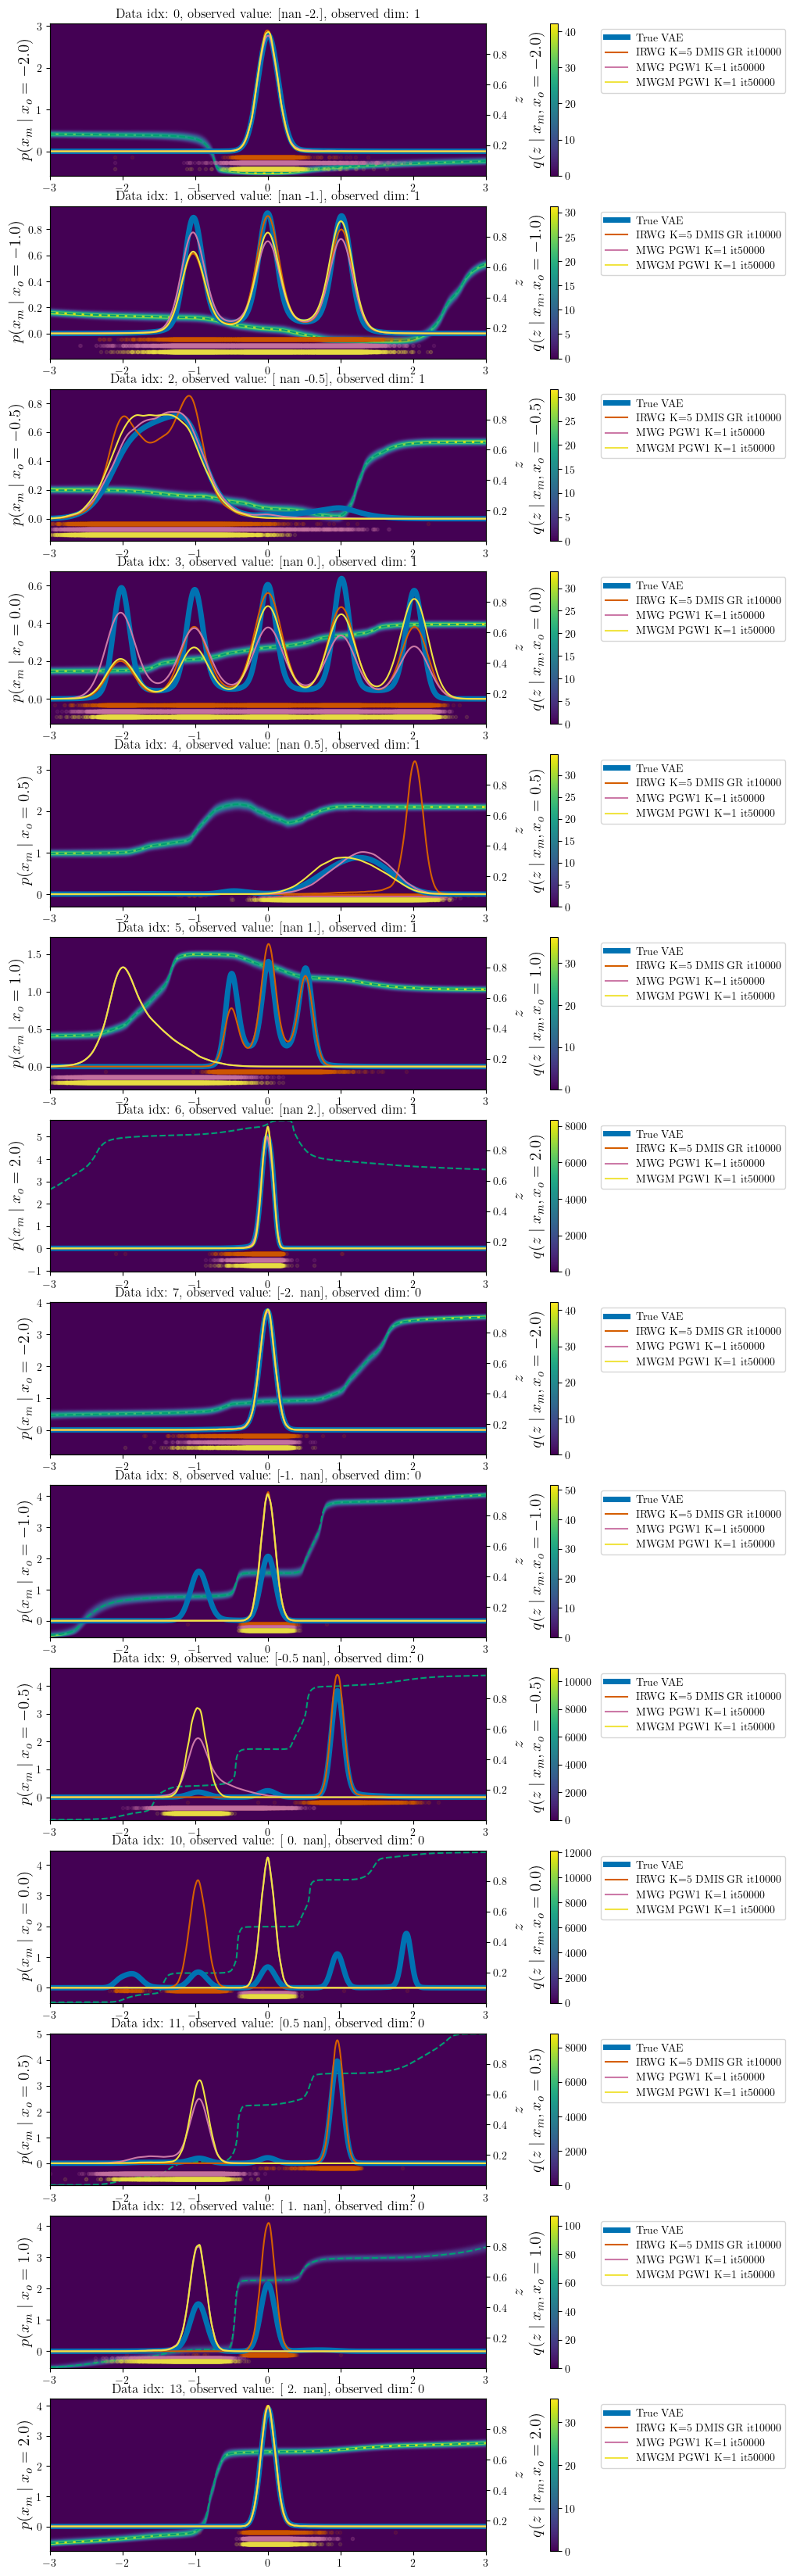

In [34]:
limits = (-3, 3)
bins = 5000

num_datapoints = 14
plot_mog = False


plot_var_latent = True
plot_true_latent = False
assert not (plot_var_latent and plot_true_latent)
latent_pdf_plot_log = False
plot_latent_joint_vae = False
var_temperature=None

pdf_plot_log = False

plot_scatter = True
scatter_alpha = 0.1
vae_integration_kwargs={'latent_min':0., 
                        'latent_max':1.+1e-8, 
                        'latent_bins': 500}
latent_x_bins = 5000
vae_latent_pdf_kwargs={'latent_min':0.+1e-6, 
                        'latent_max':1.-1e-6, 
                        'latent_bins': 500}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = colors + ['r', 'm', 'w', 'g', 'k', 'c', 'y', 'tomato']
color_idx = 0

vae = VAE.load_from_checkpoint(vae_path)
vae = vae.eval()

fig, ax = plt.subplots(num_datapoints, 1, figsize=(9, num_datapoints*3))

divergences = {}
for data_idx in range(num_datapoints):
    color_idx = 0
    divergences[data_idx] = {}
    for i, (method, cfg) in enumerate(imputation_cfgs.items()):
        divergences[data_idx][method] = {}
        imputations = load_imputations_from_experiment(cfg['path'])

        X_imp = imputations['imputations'][data_idx]
        M = imputations['masks'][data_idx, 0]
        miss_idx = np.where(~M)[0][0]
        X_imp = X_imp[..., miss_idx]
        X_imp = rearrange(X_imp, 'k t -> (k t)')

        X_true = imputations['true_X'][data_idx, 0]
        obs_idx = np.where(M)[0][0]

        x = np.linspace(limits[0], limits[1], bins, dtype=np.float32)
        dx = (limits[1] - limits[0]) / bins
        
        # Plot MoG
        if i == 0 and plot_mog:
            mog_logpdf = mog_compute_conditional_logpdf(x, X_true, M, params)
            mog_logpdf = asnumpy(mog_logpdf)
            mog_pdf = np.exp(asnumpy)
            ax[data_idx].plot(x, mog_logpdf if pdf_plot_log else mog_pdf ,linewidth=5., color=colors[color_idx], label='True MoG')
            color_idx += 1

        # Plot VAE
        if i == 0:
            vae_logpdf = vae_compute_conditional_logpdf(x, dx, X_true, M, vae, params, vae_integration_kwargs)
            vae_logpdf = asnumpy(vae_logpdf)
            vae_pdf = np.exp(vae_logpdf)
            ax[data_idx].plot(x, vae_logpdf if pdf_plot_log else vae_pdf ,linewidth=5., color=colors[color_idx], label='True VAE')
            
            color_idx += 1
            
            max_height = vae_pdf.max()
            
        # Plot var latent
        if i == 0 and plot_var_latent:
            latent_x = np.linspace(limits[0], limits[1], latent_x_bins, dtype=np.float32)
            
            ax_twin = ax[data_idx].twinx()
            
            encoder_z_exp_vals = vae_encoder_latent_posterior_expected_value_1d(latent_x, X_true, M, vae, temperature=var_temperature)
            ax_twin.plot(latent_x, encoder_z_exp_vals, color=colors[color_idx], linestyle='--')
            color_idx += 1
            
            q_logpdf = vae_encoder_latent_posterior_logpdf_1d(latent_x, M, X_true, vae, vae_latent_pdf_kwargs, temperature=var_temperature)
            q_logpdf = rearrange(asnumpy(q_logpdf), 'd z -> z d')
            q_pdf = np.exp(q_logpdf)
            if plot_latent_joint_vae:
                qp_logpdf = q_logpdf + vae_logpdf[None, :]
                qp_pdf = np.exp(qp_logpdf)
                im = ax_twin.imshow(qp_logpdf if latent_pdf_plot_log else qp_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower')
            else:
                im = ax_twin.imshow(q_logpdf if latent_pdf_plot_log else q_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower')
            fig.colorbar(im, ax=ax_twin, anchor=(0.5, 0.5))
            
            ax_twin.set_aspect('auto')
            ax_twin.set_zorder(ax[data_idx].get_zorder() - 1)
            
            latent_plotting_pdf_label_prefix = ''
            if latent_pdf_plot_log:
                latent_plotting_pdf_label_prefix = '\log'
            if plot_latent_joint_vae:
                ax_twin.set_ylabel(f'$z$\r\n${latent_plotting_pdf_label_prefix} pq(x_m, z \mid x_o={X_true[obs_idx]})$', fontsize=15)
            else:
                ax_twin.set_ylabel(f'$z$\r\n${latent_plotting_pdf_label_prefix} q(z \mid x_m, x_o={X_true[obs_idx]})$', fontsize=15)
            ax[data_idx].patch.set_alpha(0.)
            
        # Plot true latent
        if i == 0 and plot_true_latent:
            latent_x = np.linspace(limits[0], limits[1], latent_x_bins, dtype=np.float32)
            
            ax_twin = ax[data_idx].twinx()
            
            true_z_exp_vals = vae_true_latent_posterior_expected_value_1d(latent_x, X_true, M, vae, vae_latent_pdf_kwargs)
            ax_twin.plot(latent_x, true_z_exp_vals, color=colors[color_idx], linestyle='--')
            color_idx += 1
            
            pz_logpdf = vae_true_latent_posterior_logpdf_1d(latent_x, X_true, M, vae, vae_latent_pdf_kwargs)
            pz_logpdf = rearrange(asnumpy(pz_logpdf), 'd z -> z d')
            pz_pdf = np.exp(pz_logpdf)
            if plot_latent_joint_vae:
                pzp_logpdf = pz_logpdf + vae_logpdf[None, :]
                pzp_pdf = np.exp(pzp_logpdf)
                
                im = ax_twin.imshow(pzp_logpdf if latent_pdf_plot_log else pzp_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower')
            else:
                im = ax_twin.imshow(pz_logpdf if latent_pdf_plot_log else pz_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower')
            fig.colorbar(im, ax=ax_twin, anchor=(0.5, 0.5))
            
            ax_twin.set_aspect('auto')
            ax_twin.set_zorder(ax[data_idx].get_zorder() - 1)
            
            latent_plotting_pdf_label_prefix = ''
            if latent_pdf_plot_log:
                latent_plotting_pdf_label_prefix = '\log'
            if plot_latent_joint_vae:
                ax_twin.set_ylabel(f'$z$\r\n${latent_plotting_pdf_label_prefix} p(x_m, z \mid x_o={X_true[obs_idx]})$', fontsize=15)
            else:
                ax_twin.set_ylabel(f'$z$\r\n${latent_plotting_pdf_label_prefix} p(z \mid x_m, x_o={X_true[obs_idx]})$', fontsize=15)
            ax[data_idx].patch.set_alpha(0.)

            
        # Plot KDE
        kde_imp = sstats.gaussian_kde(X_imp)
        logpdf = kde_imp.logpdf(x)
        pdf = np.exp(logpdf)
        ax[data_idx].plot(x, logpdf if pdf_plot_log else pdf, color=colors[color_idx], label=method)
        
        if plot_scatter:
            scatter_height = max_height/20
            ax[data_idx].scatter(X_imp, np.zeros(X_imp.shape[0])-(i+1)*scatter_height, 
                                 marker='.', alpha=scatter_alpha,
                                 color=colors[color_idx])
            
        color_idx += 1
        
        plotting_pdf_label_prefix = ''
        if pdf_plot_log:
            plotting_pdf_label_prefix = '\log'
        ax[data_idx].set_ylabel(f'${plotting_pdf_label_prefix} p(x_m \mid x_o={X_true[obs_idx]})$', fontsize=15)
        
        ax[data_idx].set_title(f'Data idx: {data_idx}, observed value: {X_true}, observed dim: {obs_idx}')
        
        
        # Compute KL divergences
        kl_fow, kl_rev, jsd = compute_divergences_between_logpds_arrays(vae_logpdf, logpdf, dx)
        divergences[data_idx][method]['kl_fow'] = kl_fow
        divergences[data_idx][method]['kl_rev'] = kl_rev
        divergences[data_idx][method]['jsd'] = jsd
    divergences[data_idx]['title'] = f'Data idx: {data_idx}, observed value: {X_true}, observed dim: {obs_idx}'

#     ax[data_idx].legend(fancybox=True, framealpha=0.4)
    if plot_true_latent or plot_var_latent:
        ax[data_idx].legend(bbox_to_anchor=(1.7, 1.00))
    else:
        ax[data_idx].legend(bbox_to_anchor=(1.01, 1.00))
    ax[data_idx].set_xlim(limits[0], limits[1])

In [35]:
for data_idx, divs in divergences.items():
    print(divs['title'])
    divs = {m: d for (m, d) in divs.items() if m != 'title' }
    print(f'| {"Method":<35} | {"KL(p||q)":<11} | {"KL(q||p)":<11} | {"JSD(p||q)":<11} |')
    print('-'*60+'-'*16)
    smallest = {}
    for i, (method, metrics) in enumerate(divs.items()):
        for k, v in metrics.items():
            if i == 0 or smallest[k] > v:
                smallest[k] = v
                smallest[f'method_{k}'] = method
            
    for method, metrics in divs.items():
        klfow_star, klrev_star, jsd_star = '', '', ''
        if smallest['method_kl_fow'] == method:
            klfow_star = '*'
        if smallest['method_kl_rev'] == method:
            klrev_star = '*'
        if smallest['method_jsd'] == method:
            jsd_star = '*'
            
        print(f'| {method:<35} | {metrics["kl_fow"]:<8,.5f}{klfow_star:<3} | {metrics["kl_rev"]:<8,.5f}{klrev_star:<3} | {metrics["jsd"]:<8,.5f}{jsd_star:<3} |')
    print()

Data idx: 0, observed value: [nan -2.], observed dim: 1
| Method                              | KL(p||q)    | KL(q||p)    | JSD(p||q)   |
----------------------------------------------------------------------------
| IRWG K=5 DMIS GR it10000            | 0.14466     | 0.00934     | 0.00286     |
| MWG PGW1 K=1 it50000                | 0.00633 *   | 0.00303 *   | 0.00073 *   |
| MWGM PGW1 K=1 it50000               | 0.04199     | 0.00764     | 0.00236     |

Data idx: 1, observed value: [nan -1.], observed dim: 1
| Method                              | KL(p||q)    | KL(q||p)    | JSD(p||q)   |
----------------------------------------------------------------------------
| IRWG K=5 DMIS GR it10000            | 0.02064 *   | 0.01990 *   | 0.00502 *   |
| MWG PGW1 K=1 it50000                | 0.02086     | 0.02183     | 0.00530     |
| MWGM PGW1 K=1 it50000               | 0.02240     | 0.02232     | 0.00554     |

Data idx: 2, observed value: [ nan -0.5], observed dim: 1
| Method          

### Finetuned with ELBO (only encoder)

#### Long run, single "chains"

In [36]:
vae_model_name = 'vae_from_pretrained_comptrain_fixgenerator'
checkpoint_name = 'last'
vae_path = (f'../logs/{dataset}/imputation/{vae_model_name}/seed_m20220118_d20220118/lightning_logs/'
            f'version_0/checkpoints/{checkpoint_name}.ckpt')

imp_path_template = (f'../logs/{dataset}/imputation/sampling/{vae_model_name}/'
                     '{}/seed_m20220118_d20220118/lightning_logs/')
imputation_cfgs = {
    'IRWG K=5 DMIS GR it10000': {
        'path': imp_path_template.format('irwg_k5_dmis_gr_mult_it10000')
    },
    'MWG PGW1 K=1 it50000': {
        'path': imp_path_template.format('mwg_k1_no_warmup_it50000')
    },
    'MWGM PGW1 K=1 it50000': {
        'path': imp_path_template.format('mwgm_k1_no_warmup_it50000')
    },
}

/home/vaidas/miniconda3/envs/irwg/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'generator_network' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['generator_network'])`.
  rank_zero_warn(
/home/vaidas/miniconda3/envs/irwg/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'var_latent_network' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['var_latent_network'])`.
  rank_zero_warn(


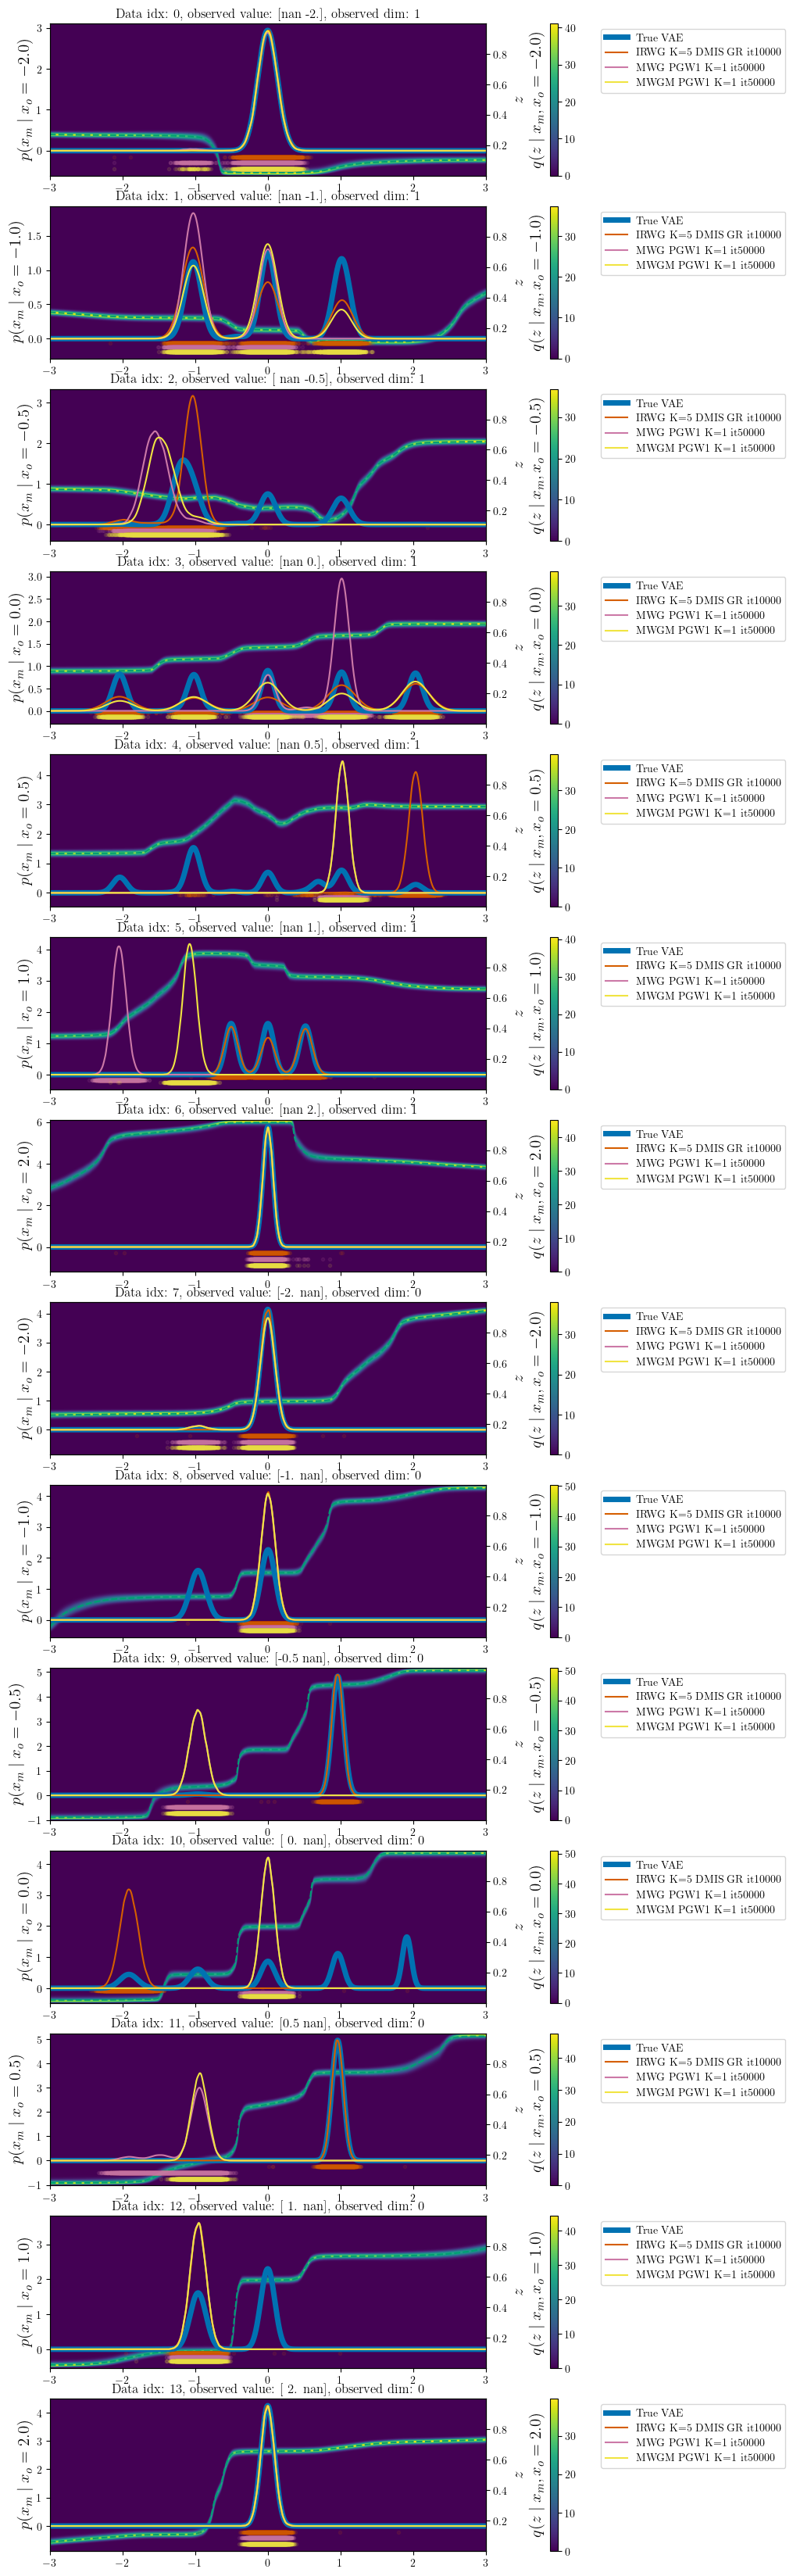

In [37]:
limits = (-3, 3)
bins = 5000

num_datapoints = 14
plot_mog = False


plot_var_latent = True
plot_true_latent = False
assert not (plot_var_latent and plot_true_latent)
latent_pdf_plot_log = False
plot_latent_joint_vae = False
var_temperature=None

pdf_plot_log = False

plot_scatter = True
scatter_alpha = 0.1
vae_integration_kwargs={'latent_min':0., 
                        'latent_max':1.+1e-8, 
                        'latent_bins': 500}
latent_x_bins = 5000
vae_latent_pdf_kwargs={'latent_min':0.+1e-6, 
                        'latent_max':1.-1e-6, 
                        'latent_bins': 500}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = colors + ['r', 'm', 'w', 'g', 'k', 'c', 'y', 'tomato']
color_idx = 0

vae = VAE.load_from_checkpoint(vae_path)
vae = vae.eval()

fig, ax = plt.subplots(num_datapoints, 1, figsize=(9, num_datapoints*3))

divergences = {}
for data_idx in range(num_datapoints):
    color_idx = 0
    divergences[data_idx] = {}
    for i, (method, cfg) in enumerate(imputation_cfgs.items()):
        divergences[data_idx][method] = {}
        imputations = load_imputations_from_experiment(cfg['path'])

        X_imp = imputations['imputations'][data_idx]
        M = imputations['masks'][data_idx, 0]
        miss_idx = np.where(~M)[0][0]
        X_imp = X_imp[..., miss_idx]
        X_imp = rearrange(X_imp, 'k t -> (k t)')

        X_true = imputations['true_X'][data_idx, 0]
        obs_idx = np.where(M)[0][0]

        x = np.linspace(limits[0], limits[1], bins, dtype=np.float32)
        dx = (limits[1] - limits[0]) / bins
        
        # Plot MoG
        if i == 0 and plot_mog:
            mog_logpdf = mog_compute_conditional_logpdf(x, X_true, M, params)
            mog_logpdf = asnumpy(mog_logpdf)
            mog_pdf = np.exp(asnumpy)
            ax[data_idx].plot(x, mog_logpdf if pdf_plot_log else mog_pdf ,linewidth=5., color=colors[color_idx], label='True MoG')
            color_idx += 1

        # Plot VAE
        if i == 0:
            vae_logpdf = vae_compute_conditional_logpdf(x, dx, X_true, M, vae, params, vae_integration_kwargs)
            vae_logpdf = asnumpy(vae_logpdf)
            vae_pdf = np.exp(vae_logpdf)
            ax[data_idx].plot(x, vae_logpdf if pdf_plot_log else vae_pdf ,linewidth=5., color=colors[color_idx], label='True VAE')
            
            color_idx += 1
            
            max_height = vae_pdf.max()
            
        # Plot var latent
        if i == 0 and plot_var_latent:
            latent_x = np.linspace(limits[0], limits[1], latent_x_bins, dtype=np.float32)
            
            ax_twin = ax[data_idx].twinx()
            
            encoder_z_exp_vals = vae_encoder_latent_posterior_expected_value_1d(latent_x, X_true, M, vae, temperature=var_temperature)
            ax_twin.plot(latent_x, encoder_z_exp_vals, color=colors[color_idx], linestyle='--')
            color_idx += 1
            
            q_logpdf = vae_encoder_latent_posterior_logpdf_1d(latent_x, M, X_true, vae, vae_latent_pdf_kwargs, temperature=var_temperature)
            q_logpdf = rearrange(asnumpy(q_logpdf), 'd z -> z d')
            q_pdf = np.exp(q_logpdf)
            if plot_latent_joint_vae:
                qp_logpdf = q_logpdf + vae_logpdf[None, :]
                qp_pdf = np.exp(qp_logpdf)
                im = ax_twin.imshow(qp_logpdf if latent_pdf_plot_log else qp_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower')
            else:
                im = ax_twin.imshow(q_logpdf if latent_pdf_plot_log else q_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower')
            fig.colorbar(im, ax=ax_twin, anchor=(0.5, 0.5))
            
            ax_twin.set_aspect('auto')
            ax_twin.set_zorder(ax[data_idx].get_zorder() - 1)
            
            latent_plotting_pdf_label_prefix = ''
            if latent_pdf_plot_log:
                latent_plotting_pdf_label_prefix = '\log'
            if plot_latent_joint_vae:
                ax_twin.set_ylabel(f'$z$\r\n${latent_plotting_pdf_label_prefix} pq(x_m, z \mid x_o={X_true[obs_idx]})$', fontsize=15)
            else:
                ax_twin.set_ylabel(f'$z$\r\n${latent_plotting_pdf_label_prefix} q(z \mid x_m, x_o={X_true[obs_idx]})$', fontsize=15)
            ax[data_idx].patch.set_alpha(0.)
            
        # Plot true latent
        if i == 0 and plot_true_latent:
            latent_x = np.linspace(limits[0], limits[1], latent_x_bins, dtype=np.float32)
            
            ax_twin = ax[data_idx].twinx()
            
            true_z_exp_vals = vae_true_latent_posterior_expected_value_1d(latent_x, X_true, M, vae, vae_latent_pdf_kwargs)
            ax_twin.plot(latent_x, true_z_exp_vals, color=colors[color_idx], linestyle='--')
            color_idx += 1
            
            pz_logpdf = vae_true_latent_posterior_logpdf_1d(latent_x, X_true, M, vae, vae_latent_pdf_kwargs)
            pz_logpdf = rearrange(asnumpy(pz_logpdf), 'd z -> z d')
            pz_pdf = np.exp(pz_logpdf)
            if plot_latent_joint_vae:
                pzp_logpdf = pz_logpdf + vae_logpdf[None, :]
                pzp_pdf = np.exp(pzp_logpdf)
                
                im = ax_twin.imshow(pzp_logpdf if latent_pdf_plot_log else pzp_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower')
            else:
                im = ax_twin.imshow(pz_logpdf if latent_pdf_plot_log else pz_pdf, 
                               extent=(limits[0], limits[1], 
                                       vae_latent_pdf_kwargs['latent_min'], vae_latent_pdf_kwargs['latent_max']), 
                               origin='lower')
            fig.colorbar(im, ax=ax_twin, anchor=(0.5, 0.5))
            
            ax_twin.set_aspect('auto')
            ax_twin.set_zorder(ax[data_idx].get_zorder() - 1)
            
            latent_plotting_pdf_label_prefix = ''
            if latent_pdf_plot_log:
                latent_plotting_pdf_label_prefix = '\log'
            if plot_latent_joint_vae:
                ax_twin.set_ylabel(f'$z$\r\n${latent_plotting_pdf_label_prefix} p(x_m, z \mid x_o={X_true[obs_idx]})$', fontsize=15)
            else:
                ax_twin.set_ylabel(f'$z$\r\n${latent_plotting_pdf_label_prefix} p(z \mid x_m, x_o={X_true[obs_idx]})$', fontsize=15)
            ax[data_idx].patch.set_alpha(0.)

            
        # Plot KDE
        kde_imp = sstats.gaussian_kde(X_imp)
        logpdf = kde_imp.logpdf(x)
        pdf = np.exp(logpdf)
        ax[data_idx].plot(x, logpdf if pdf_plot_log else pdf, color=colors[color_idx], label=method)
        
        if plot_scatter:
            scatter_height = max_height/20
            ax[data_idx].scatter(X_imp, np.zeros(X_imp.shape[0])-(i+1)*scatter_height, 
                                 marker='.', alpha=scatter_alpha,
                                 color=colors[color_idx])
            
        color_idx += 1
        
        plotting_pdf_label_prefix = ''
        if pdf_plot_log:
            plotting_pdf_label_prefix = '\log'
        ax[data_idx].set_ylabel(f'${plotting_pdf_label_prefix} p(x_m \mid x_o={X_true[obs_idx]})$', fontsize=15)
        
        ax[data_idx].set_title(f'Data idx: {data_idx}, observed value: {X_true}, observed dim: {obs_idx}')
        
        
        # Compute KL divergences
        kl_fow, kl_rev, jsd = compute_divergences_between_logpds_arrays(vae_logpdf, logpdf, dx)
        divergences[data_idx][method]['kl_fow'] = kl_fow
        divergences[data_idx][method]['kl_rev'] = kl_rev
        divergences[data_idx][method]['jsd'] = jsd
    divergences[data_idx]['title'] = f'Data idx: {data_idx}, observed value: {X_true}, observed dim: {obs_idx}'

#     ax[data_idx].legend(fancybox=True, framealpha=0.4)
    if plot_true_latent or plot_var_latent:
        ax[data_idx].legend(bbox_to_anchor=(1.7, 1.00))
    else:
        ax[data_idx].legend(bbox_to_anchor=(1.01, 1.00))
    ax[data_idx].set_xlim(limits[0], limits[1])

In [38]:
for data_idx, divs in divergences.items():
    print(divs['title'])
    divs = {m: d for (m, d) in divs.items() if m != 'title' }
    print(f'| {"Method":<35} | {"KL(p||q)":<11} | {"KL(q||p)":<11} | {"JSD(p||q)":<11} |')
    print('-'*60+'-'*16)
    smallest = {}
    for i, (method, metrics) in enumerate(divs.items()):
        for k, v in metrics.items():
            if i == 0 or smallest[k] > v:
                smallest[k] = v
                smallest[f'method_{k}'] = method
            
    for method, metrics in divs.items():
        klfow_star, klrev_star, jsd_star = '', '', ''
        if smallest['method_kl_fow'] == method:
            klfow_star = '*'
        if smallest['method_kl_rev'] == method:
            klrev_star = '*'
        if smallest['method_jsd'] == method:
            jsd_star = '*'
            
        print(f'| {method:<35} | {metrics["kl_fow"]:<8,.5f}{klfow_star:<3} | {metrics["kl_rev"]:<8,.5f}{klrev_star:<3} | {metrics["jsd"]:<8,.5f}{jsd_star:<3} |')
    print()

Data idx: 0, observed value: [nan -2.], observed dim: 1
| Method                              | KL(p||q)    | KL(q||p)    | JSD(p||q)   |
----------------------------------------------------------------------------
| IRWG K=5 DMIS GR it10000            | 0.00107 *   | 0.00335 *   | 0.00022 *   |
| MWG PGW1 K=1 it50000                | 0.01309     | 0.28894     | 0.00442     |
| MWGM PGW1 K=1 it50000               | 0.00265     | 0.04559     | 0.00080     |

Data idx: 1, observed value: [nan -1.], observed dim: 1
| Method                              | KL(p||q)    | KL(q||p)    | JSD(p||q)   |
----------------------------------------------------------------------------
| IRWG K=5 DMIS GR it10000            | 0.12780 *   | 0.14574     | 0.03260 *   |
| MWG PGW1 K=1 it50000                | 16.97028    | 0.44871     | 0.14107     |
| MWGM PGW1 K=1 it50000               | 0.14970     | 0.14306 *   | 0.03505     |

Data idx: 2, observed value: [ nan -0.5], observed dim: 1
| Method          